In [2]:
import numpy as np
import random
%matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import entropy
from sklearn.decomposition import PCA,  IncrementalPCA
import math
from sklearn import svm
from decimal import Decimal
import math
from sklearn import preprocessing
import heapq
figure_size = (5.5,5.5)

In [3]:
def iauc(P,Q):
    return 1- np.sum(np.min(P,Q))/np.sum(P)
def kl(p, q):
    """Kullback-Leibler divergence D(P || Q) for discrete distributions
    Parameters
    ----------
    p, q : array-like, dtype=float, shape=n
    Discrete probability distributions.
    """
    epsilon = 0.00001
    p = p +epsilon 
    p = p/np.sum(p)
    q = q + epsilon
    q = q/np.sum(q)

    return entropy(p, q)
def mkl(p,q):
    return np.max([kl(p,q), kl(q,p)])
def kl2(P,Q):
    """ Epsilon is used here to avoid conditional code for checking that neither P nor Q is equal to 0. """
    epsilon = 0.00001
    
     # You may want to instead make copies to avoid changing the np arrays.
    P = P+epsilon
    P = P/np.sum(P)
    Q = Q+epsilon
    Q = Q/np.sum(Q)
    

    divergence = np.sum(P*np.log(P/Q))
    divergence = 0
    for i in range(len(P)):
        
        divergence += np.max([P[i] * math.log(P[i]/Q[i]), Q[i]* math.log(Q[i]/P[i])])
    return divergence

In [4]:
import random
groud_truth = []
def generate_dataset(distribution_type, dim, length_chunk, mean, cov, change_value, change_type,change_param, num_chunk):
    global groud_truth
    out = []
    if distribution_type == "gauss":
        for i in range(num_chunk):
            generated_length_chunk = random.randint(length_chunk, length_chunk*3)
            
            #generated_length_chunk = length_chunk
            x = np.random.multivariate_normal(mean, cov, generated_length_chunk)

            if change_param == "mean":
                if change_type == "sudden":
                    for j  in range(len(mean)):
                        
                            mean[j] += change_value
                
                elif change_type == "incremental":
                    incremental_x = []
                    for t in range(5):
                        for j in range(len(mean)):
                            mean[j] += change_value/5
                        part_x = np.random.multivariate_normal(mean, cov, 1000)
                        for xi in part_x:
                            incremental_x.append(xi)
                elif change_type == "gradual":
                    gradual_x = []
                    new_mean = []
                    for j in range(len(mean)):
                        new_mean.append(mean[j] + change_value)
                    
                    for t in range(5):
                        threshold = (t+1)*10/5
                        r = random.randint(0,10)
                        if r < threshold:
                            part_x = np.random.multivariate_normal(new_mean, cov, 1000)
                        else:
                            part_x = np.random.multivariate_normal(mean, cov, 1000)
                        for xi in part_x:
                            gradual_x.append(xi)
                    mean = new_mean
                    
                    
                        
            elif change_param == "variance":
                if change_type == "sudden":
                    t = random.randint(0,2)
                    for j in range(len(cov[0])):
                        
                        if t% 2 == 0:
                            cov[j][j] = (math.sqrt(cov[j][j]) + change_value*math.sqrt(cov[j][j]))*(math.sqrt(cov[j][j]) + change_value*math.sqrt(cov[j][j]))
                        else:
                            cov[j][j] = (math.sqrt(cov[j][j]) - change_value*math.sqrt(cov[j][j]))*(math.sqrt(cov[j][j]) - change_value*math.sqrt(cov[j][j]))
                        for k in range(len(cov)):
                            if k != j and k < j:
                                cov[j][k] = 0.5 * cov[j][j]
                                cov[k][j] = cov[j][k]
                        
                    print(cov)
                elif change_type == "incremental":
                    incremental_x = []
                    t = random.randint(0,2)
                    for t_ in range(5):
                        for j in range(len(cov[0])):
                            
                            if t% 2 == 0:
                                cov[j][j] = (math.sqrt(cov[j][j]) + change_value*math.sqrt(cov[j][j])/5)*(math.sqrt(cov[j][j]) + change_value*math.sqrt(cov[j][j])/5)
                            else:
                                cov[j][j] = (math.sqrt(cov[j][j]) - change_value*math.sqrt(cov[j][j])/5)*(math.sqrt(cov[j][j]) - change_value*math.sqrt(cov[j][j])/5)
                            for k in range(len(cov)):
                                if k != j and k < j:
                                    cov[j][k] = 0.5 * cov[j][j]
                                    cov[k][j] = cov[j][k]
                        part_x = np.random.multivariate_normal(mean, cov, 1000)
                        for xi in part_x:
                            incremental_x.append(xi)
                        #print(cov)
                elif change_type == "gradual":
                    gradual_x = []
                    new_cov = cov
                    t = random.randint(0,2)
                    for j in range(len(new_cov[0])):
                        
                        if t% 2 == 0:
                            new_cov[j][j] = (math.sqrt(new_cov[j][j]) + change_value*math.sqrt(new_cov[j][j]))*(math.sqrt(new_cov[j][j]) + change_value*math.sqrt(new_cov[j][j]))
                        else:
                            new_cov[j][j] = (math.sqrt(new_cov[j][j]) - change_value*math.sqrt(new_cov[j][j]))*(math.sqrt(new_cov[j][j]) - change_value*math.sqrt(new_cov[j][j]))
                        for k in range(len(cov)):
                            if k != j and k < j:
                                new_cov[j][k] = 0.5 * new_cov[j][j]
                                new_cov[k][j] = new_cov[j][k]
                    for t_ in range(5):
                        threshold = (t_+1)/5*10
                        r = random.randint(0,10)
                        if r < threshold:
                            part_x = np.random.multivariate_normal(mean, new_cov, 1000)
                        else:
                            part_x = np.random.multivariate_normal(mean, cov, 1000)
                            
                        for xi in part_x:
                            gradual_x.append(xi)
                    #print(new_cov)
                    cov = new_cov
                                
                                
            elif change_param =="correlation":
                if change_type == "sudden":
                    for j in range(len(cov[0])):
                        for k in range(len(cov[0])):
                            if  j !=k and k < j:
                                if cov[j][k]+change_value * cov[j][j] < cov[j][j]:
                                    cov[j][k] += change_value * cov[j][j]
                                    cov[k][j] = cov[j][k]
                                else :
                                    cov[j][k] = 0.5 * cov[j][j]
                                    cov[k][j] = cov[j][k]
                    #print(cov)
            #x = x.reshape(int(len(x)/2),2)
                elif change_type == "incremental":
                    incremental_x = []
                    for t in range(5):
                        for j in range(len(cov[0])):
                            for k in range(len(cov[0])):
                                if  j !=k and k < j:
                                    if cov[j][k]+change_value/5 * cov[j][j] < cov[j][j]:
                                        cov[j][k] += change_value/5 * cov[j][j]
                                        cov[k][j] = cov[j][k]
                                    else :
                                        cov[j][k] = 0.5 * cov[j][j]
                                        cov[k][j] = cov[j][k]
                        #print(cov)
                        part_x = np.random.multivariate_normal(mean, cov, 1000)
                        for xi in part_x:
                            incremental_x.append(xi)
                elif change_type == "gradual":
                    gradual_x = []
                    new_cov = cov
                    for j in range(len(new_cov[0])):
                        for k in range(len(new_cov[0])):
                            if  j !=k and k < j:
                                if new_cov[j][k]+change_value * new_cov[j][j] < new_cov[j][j]:
                                    new_cov[j][k] += change_value * new_cov[j][j]
                                    new_cov[k][j] = new_cov[j][k]
                                else :
                                    new_cov[j][k] = 0.5 * new_cov[j][j]
                                    new_cov[k][j] = new_cov[j][k]
                    for t_ in range(5):
                        threshold = (t_+1)/5*10
                        r = random.randint(0,10)
                        if r < threshold:
                            part_x = np.random.multivariate_normal(mean, new_cov, 1000)
                        else:
                            part_x = np.random.multivariate_normal(mean, cov, 1000)
                            
                        for xi in part_x:
                            gradual_x.append(xi)
                    #print(new_cov)
                    cov = new_cov 
            if i > 0:
                groud_truth.append(len(out))
            if change_type == "sudden" or len(out) == 0:
                for xi in x:
                    out.append(xi)
            elif change_type == "incremental":
                for xi in x[5000:]:
                    out.append(xi)
                for xi in incremental_x:
                    out.append(xi)
            elif change_type == "gradual":
                for xi in x[5000:]:
                    out.append(xi)
                for xi in gradual_x:
                    out.append(xi)
            
    return np.array(out)

In [15]:
#process real_world dataset
groud_truth = []
selected_dims = []

def sample_a_segment(dataset, length_chunk_):
    return random.sample(list(dataset), length_chunk_)
        
def sample_dataset_no_change(filename, change_type, length_chunk_, num_chunk):
    global groud_truth
    global selected_dims
    
    dataset = np.loadtxt(filename,delimiter=",")
    
    random.seed(int(time.time()))
    no_change = []
    end_chunk_list = []
    for i in range(num_chunk):
        #length_chunk = random.randint(length_chunk_, length_chunk_*3)
        length_chunk = length_chunk_
        chunk = sample_a_segment(dataset, length_chunk)
        #change in random dim
        no_change.extend(chunk[:])
        end_chunk_list.append(len(no_change))
    
    return np.array(no_change), end_chunk_list
def add_change_to_data(no_change, end_chunk_list, change_type):
    global selected_dims
    global groud_truth
    ground_truth = end_chunk_list[0:len(end_chunk_list)-1]
    out = []
    dim = len(no_change[0])
    for i in range(end_chunk_list[0]):
        out.append(no_change[i][:])
    if change_type == "double":
        for i in range(1, len(end_chunk_list)):
            selected_dim = random.randint(0, len(no_change[0])-1)
            while(len(selected_dims) > 0 and selected_dim==selected_dims[-1]):
                selected_dim = random.randint(0, len(no_change[0])-1)
            selected_dims.append(selected_dim)
            start_idx = end_chunk_list[i-1]
            end_idx = end_chunk_list[i]
            for j in range(start_idx, end_idx):
                temp_data = []
                for k in range(dim):
                    if k!= selected_dim:
                        temp_data.append(no_change[j][k])
                    else:
                        temp_data.append(no_change[j][k] * 2)
                out.append(temp_data)
    elif change_type == "gaussian":
        for i in range(1, len(end_chunk_list)):
            selected_dim = random.randint(0, len(no_change[0])-1)
            while(len(selected_dims) > 0 and selected_dim==selected_dims[-1]):
                selected_dim = random.randint(0, len(no_change[0])-1)
            selected_dims.append(selected_dim)
            start_idx = end_chunk_list[i-1]
            end_idx = end_chunk_list[i]
            data_mean = np.mean(no_change[start_idx: end_idx][selected_dim])
            data_std = np.std(no_change[start_idx: end_idx][selected_dim])
            
            
            for j in range(start_idx, end_idx):
                temp_data = []
                for k in range(dim):
                    if k!= selected_dim:
                        temp_data.append(no_change[j][k])
                    else:
                        #add noise here
                        temp_data.append(no_change[j][k]+np.random.normal(data_mean/10, data_std/10,1) )
                out.append(temp_data)
    return np.array(out)
     
        


In [96]:
no_change,end_chunk_list = sample_dataset_no_change("VLDB/tao.txt", "double", 10000, 15)
d = add_change_to_data(no_change, end_chunk_list, "double")


NameError: name 'plot' is not defined

In [6]:
truncating_number = 4
def change_detection_truncate(data, window_size, slide_size):
    change_detection_time = 0
    threshold = 1.3*math.sqrt(window_size/slide_size)
    
    #time_for_getting_ref = 0
    
    #threshold = window_size/slide_size*0.5
    global truncating_number
    global alpha
    
    dim = len(data[0,:])
    #print("dim = "+ str(dim))
    start_idx = 0
    end_idx = window_size
    #get reference 
    reference_window = data[0:window_size,:]
    #print(reference_window[4999])
    ref_hists = []
    bin_edges = []
    num_selected_components = 0
    
    start_time = time.time()
    reference_window, bin_edges, dim, pca, ref_hists,num_selected_components = get_reference_window(reference_window, dim)
    change_detection_time += time.time() - start_time
    #time_for_getting_ref += time.time() - start_time
    #alpha = x1/(len(bin_edges)-1)
    #print("Num bin = " + str(len(bin_edges[0])))
    
    count_slide = 0
    start_idx += slide_size
    end_idx += slide_size
    ref_end_idx = end_idx
    distances = []
    lis_sequence = []
    changes = []
    
    possible_lis = 0
    
    
    
    current_hists = ref_hists[:]
    
    while(end_idx < len(data)):
        count_slide +=1
        
        #current_window = pca.transform(data[start_idx: end_idx])
        start_time = time.time()
        expired_slide = pca.transform(data[(start_idx-slide_size): start_idx])
        
        new_slide = pca.transform(data[(end_idx - slide_size): end_idx])
        #current_window = pca.transform(preprocessing.normalize(current_window, norm='l2'))
        #current_window = pca.transform(current_window)
        #get current hist
        expired_hists = get_hists(expired_slide,num_selected_components, bin_edges)
        
        #current_hists2 = get_hists(current_window,num_selected_components, bin_edges)
        new_hists = get_hists(new_slide,num_selected_components, bin_edges)
        
        #current_hists2 = update_hists(expired_slide,new_slide,current_hists,  num_selected_components, bin_edges )
        #for i in range(len(current_hists)):
         #   for j in range(len(current_hists[i])):
          #      current_hists[i][j] = current_hists[i][j] - expired_hists[i][j] + new_hists[i][j]
        current_hists = np.subtract(current_hists, expired_hists)
        current_hists = np.add(current_hists, new_hists)
        #current_hists = np.array(current_hists) - np.array(expired_hists) + np.array(new_hists)
        change_detection_time += time.time() - start_time    
        #distance = distance2(current_hists,ref_hists, pca)
        distance = distance_max2(current_hists,ref_hists,pca)
        #distance = distance_min2(current_hists,ref_hists,pca)
        distance = round (Decimal(distance),truncating_number)
        #distance = distance_min(current_hists,ref_hists, pca)
        #distance = distance_sum(current_hists,ref_hists, pca)
        #distance = distance_sum_square(current_hists,ref_hists, pca)
        #if count_slide %50000 == 0:
            
            #print("Count slide = "+ str(count_slide))
            #print("distance = "+ str(distance))
        if start_idx > ref_end_idx:
            distances.append(distance)
        
        
        
        
        if len(distances) > window_size/slide_size:
            del distances[0]
        #print(distance)
        if start_idx > ref_end_idx:
            possible_lis +=1 
        
        if possible_lis > threshold:
            lis = len(subsequence(distances))
            possible_lis = lis
            if start_idx > ref_end_idx and lis > threshold:
                #print("Change at "+ str(end_idx))
                changes.append(end_idx)
                #update reference
                #start_idx = end_idx
                #end_idx = start_idx + window_size
                start_time = time.time()
                reference_window, bin_edges, dim, pca , ref_hists, num_selected_components= get_reference_window(data[start_idx: end_idx], dim)
                change_detection_time += time.time() - start_time
                current_hists = ref_hists[:]
                #expired_slide = reference_window[0:slide_size]
                ref_end_idx = end_idx
                possible_lis = 0
                distances = []
        
        start_idx += slide_size
        end_idx += slide_size
        #lis_sequence.append(lis)
        
        
        
        
    #fig = plt.figure()
    #plt.plot(lis_sequence)
    #fig.show()
    
    return changes, change_detection_time
    

In [7]:
def get_reference_window(curren_window, dim):
    ref_hists = []
    bin_edges = []
    num_selected_components = 0
    
    pca = PCA(n_components=dim)
    #normalized_current_window = preprocessing.normalize(curren_window, norm='l2')
    pca.fit(curren_window)
    
    s = 0
    
    for i in range(len(pca.explained_variance_ratio_)):
        s+= pca.explained_variance_ratio_[i]
        if s >= 0.999:
            num_selected_components = i + 1
            break
    #print("Num selected components = "+ str(num_selected_components))
    reference_window = pca.transform(curren_window)
    for i in range(num_selected_components):
        hist, bin_edge = np.histogram(reference_window[:,i], 'auto')
        for j in range(len(hist)):
            hist[j] += 1
        ref_hists.append(hist)
        bin_edges.append(bin_edge)
    return reference_window, bin_edges, dim, pca, ref_hists, num_selected_components
def get_hists(current_window, dim, bin_edges):
    current_hists = []
    for i in range(dim):
        hist, edge = np.histogram(current_window[:,i], bin_edges[i])
        #for j in range(len(hist)):
         #   hist[j] += 1
        current_hists.append(hist)
    return current_hists

def update_hists(expired_slide,new_slide, current_hists,  dim, bin_edges ):
    for i in range(dim):
        expired_hist, edge = np.histogram(expired_slide[:,i], bin_edges[i])
        new_hist, edge = np.histogram(new_slide[:,i], bin_edges[i])
        
        current_hist = current_hists[i]
        current_hist = current_hist + new_hist - expired_hist
        #for j in range(len(current_hist)):
         #   current_hist[j] = current_hist[j] - expired_hist[j] + new_hist[j] 
        
            
    return current_hists
    
    
def distance1(hist1, hist2):
    dim = len(hist1)
    dlist=  []
    for i in range(dim):
        d1 = mkl(hist1[i], hist2[i])
        #d2 = kl(hist2[i], hist1[i])
        #print("d = "+str(d1))
        #print("d2 = "+str(d2))
        dlist.append(d1)

    return np.max(dlist)
def distance2(hist1, hist2, pca):
    dim = len(hist1)
    dlist=  []
    for i in range(dim):
        d1 = kl(hist1[i], hist2[i])
        #d2 = kl(hist2[i], hist1[i])
        #print("d = "+str(d1))W_precision = 0.9
        #print("d2 = "+str(d2))
        dlist.append(d1)

    return np.sum([dlist[i]*pca.explained_variance_ratio_[i] for i in range(len(dlist))])
def distance_max(hist1, hist2, pca):
    dim = len(hist1)
    dlist=  []
    for i in range(dim):
        d1 = kl(hist1[i], hist2[i])
        #d2 = kl(hist2[i], hist1[i])
        #print("d = "+str(d1))W_precision = 0.9
        #print("d2 = "+str(d2))
        dlist.append(d1)

    return np.max(dlist)
def distance_max2(hist1, hist2, pca):
    dim = len(hist1)
    dlist=  []
    for i in range(dim):
        d1 = kl2(hist1[i], hist2[i])
        #d2 = kl(hist2[i], hist1[i])
        #print("d = "+str(d1))W_precision = 0.9
        #print("d2 = "+str(d2))
        dlist.append(d1)

    return np.max(dlist)
def distance_sum(hist1, hist2, pca):
    dim = len(hist1)
    dlist=  []
    for i in range(dim):
        d1 = kl(hist1[i], hist2[i])
        #d2 = kl(hist2[i], hist1[i])
        #print("d = "+str(d1))W_precision = 0.9
        #print("d2 = "+str(d2))
        dlist.append(d1)

    return np.sum(dlist)
def distance_sum_square(hist1, hist2, pca):
    dim = len(hist1)
    dlist=  []
    for i in range(dim):
        d1 = kl(hist1[i], hist2[i])
        #d2 = kl(hist2[i], hist1[i])
        #print("d = "+str(d1))W_precision = 0.9
        #print("d2 = "+str(d2))
        dlist.append(d1)

    return np.sum([x*x for x in dlist])
def distance_min(hist1, hist2, pca):
    dim = len(hist1)
    dlist=  []
    for i in range(dim):
        d1 = kl(hist1[i], hist2[i])
        #d2 = kl(hist2[i], hist1[i])
        #print("d = "+str(d1))W_precision = 0.9
        #print("d2 = "+str(d2))
        dlist.append(d1)

    return np.min(dlist)

def distance_min2(hist1, hist2, pca):
    dim = len(hist1)
    dlist=  []
    for i in range(dim):
        d1 = kl2(hist1[i], hist2[i])
        #d2 = kl(hist2[i], hist1[i])
        #print("d = "+str(d1))W_precision = 0.9
        #print("d2 = "+str(d2))
        dlist.append(d1)

    return np.min(dlist)

In [8]:
def subsequence(seq):
    if not seq:
        return seq

    M = [None] * len(seq)    # offset by 1 (j -> j-1)
    P = [None] * len(seq)

    # Since we have at least one element in our list, we can start by 
    # knowing that the there's at least an increasing subsequence of length one:
    # the first element.
    L = 1
    M[0] = 0

    # Looping over the sequence starting from the second element
    for i in range(1, len(seq)):
        # Binary search: we want the largest j <= L
        #  such that seq[M[j]] < seq[i] (default j = 0),
        #  hence we want the lower bound at the end of the search process.
        lower = 0
        upper = L

        # Since the binary search will not look at the upper bound value,
        # we'll have to check that manually
        if seq[M[upper-1]] < seq[i]:
            j = upper

        else:
            # actual binary search loop
            while upper - lower > 1:
                mid = (upper + lower) // 2
                if seq[M[mid-1]] < seq[i]:
                    lower = mid
                else:
                    upper = mid

            j = lower    # this will also set the default value to 0

        P[i] = M[j-1]

        if j == L or seq[i] < seq[M[j]]:
            M[j] = i
            L = max(L, j+1)

    # Building the result: [seq[M[L-1]], seq[P[M[L-1]]], seq[P[P[M[L-1]]]], ...]
    result = []
    pos = M[L-1]
    for _ in range(L):
        result.append(seq[pos])
        pos = P[pos]

    return result[::-1]    # reversing
    

In [9]:
def compute_score(ground_truth, result, decay_factor, window_size):
    scores = [0 for x in result]
    for i in range(len(result)):
        #check if result[i] is the soonest detected change point in a distribution 
        rs = result[i]
        #----find the closest left ground_truth
        left = -1
        for j in range(len(ground_truth)):
            if ground_truth[j] <= rs and (i == 0 or (i > 0 and result[i-1] < ground_truth[j])) :
                left = ground_truth[j]
        if left != -1:
            scores[i] =  np.exp(-decay_factor*(int((rs - left)/window_size)))
    #print(scores)
    w_precision = np.sum(scores)/len(result)
    w_recall = np.sum(scores)/len(groud_truth)
    w_f1 = 2*w_precision*w_recall/(w_precision+w_recall)
    #print("W_precision = "+str(w_precision))
    #print("W_Recall = "+ str(w_recall))
    #print("W_f1 = "+str(w_f1))
    return w_precision, w_recall, w_f1
def compute_f1_score(groudtruths, all_outliers):
    scores = []
    precisions = []
    recalls = []
    
    score_of_trainsition = []
    for i in all_outliers:
        
        ground = groudtruths[i]
        outliers = all_outliers[i]
       
        if len(ground) > 0 and len(outliers) > 0:
            score = len(set(ground).intersection(set(outliers)))
            precision, recall = 0,0
            precision = score *1.0/len(outliers)
            recall =  score *1.0/len(ground)
            precisions.append(precision)
            recalls.append(recall)
            f1 = 0
            if precision + recall > 0:
                f1 = 2* precision * recall / (precision + recall)
                
            scores.append(f1)
               
                
            if i%50000 <= 1000:
                score_of_trainsition.append(f1)
        elif len(outliers) == 0 and len(ground) > 0:
            precisions.append(0)
            recalls.append(0)
            scores.append(0)
            
        #if i % 100 == 0:
            #print("finished "+ str(i))
    return np.sum(scores)/len(scores), np.sum(precisions)/len(precisions), np.sum(recalls)/len(recalls), np.sum(score_of_trainsition)/len(score_of_trainsition)


        
    

In [10]:
import time 
def oneClass_svm_outlier_detection(oneSVM, data, outlier_rate, is_need_retrain, test_data):
    
    outliers = []
    
    retrained = False
    
    if oneSVM == None or is_need_retrain:
        #if start_idx % 100000 == 0:
            #print("REtrain!")
        oneSVM = svm.OneClassSVM(nu=outlier_rate, kernel='linear')
        oneSVM.fit(data)
        retrained = True
       
    #start_predict_time = time.time()    
    results = oneSVM.predict(test_data)
    
    outliers = [idx for idx in range(len(results)) if results[idx] == -1]
    return outliers, oneSVM
def retrain_svm_outlier_detection2(data, window_size, slide_size, outlier_rate, num_data_points):
    outlier_detection_time = 0
    start_time = time.time()
    count_window = 0
    start_idx = 0
    end_idx = window_size
    oneclassSVM = None
    all_outliers = {}
    outliers = []
    num_retrain = 0
    while end_idx < len(data):
        
        need_retrain = False
        
        if (end_idx - window_size) % num_data_points == 0:
            need_retrain = True
        else:
            need_retrain = False
        
        
        #if need_retrain and (end_idx+window_size) <= len(data):
        if need_retrain or end_idx == window_size:
            num_retrain +=1 
            #start_idx = end_idx
            #end_idx = start_idx + window_size
            #update max, min
            max_bound = np.max(data[start_idx: end_idx], axis=0)
            min_bound = np.min(data[start_idx: end_idx], axis=0)
            normalized_train_data = normalize(data[start_idx: end_idx], max_bound, min_bound)
            
            outliers_,oneclassSVM = oneClass_svm_outlier_detection(oneclassSVM, normalized_train_data, outlier_rate,
                                                                   need_retrain, normalized_train_data )
            
            new_outliers = [(x + start_idx) for x in outliers_ ]
            #merge outliers
            #if len(outliers) > 0:
            #if end_idx > window_size:
             #   merged_outliers = []
              #  merged_outliers.extend(outliers)
               # merged_outliers.extend(new_outliers)
                #k = start_idx
                #while(k <= end_idx):
                 #   all_outliers[k] = [idx for idx in merged_outliers if idx >= k-window_size and idx <k]
                  #  k += slide_size
            #outliers = new_outliers
            #else:
             #   outliers = new_outliers[:]
              #  all_outliers[end_idx] = outliers
            #
            outliers = new_outliers[:]
            all_outliers[end_idx] = outliers
        else:
            
            normalized_test_data = normalize(data[(end_idx- slide_size): end_idx], max_bound, min_bound)
            #start_time = time.time()
            outliers_,oneclassSVM = oneClass_svm_outlier_detection(oneclassSVM, data[start_idx: end_idx], outlier_rate,
                                                                   need_retrain, normalized_test_data )
            #outlier_detection_time += time.time() - start_time
            
        
            outliers = [idx for idx in outliers if idx >= start_idx]
            outliers.extend([(x + start_idx + window_size - slide_size) for x in outliers_ ])
        
            all_outliers[end_idx] = outliers
        
        
    
        
        end_idx += slide_size
        start_idx += slide_size
        
        
        
        count_window  +=1
    outlier_detection_time += time.time() - start_time
    return all_outliers, num_retrain, outlier_detection_time
def change_detection_svm_outlier_detection(data, window_size, slide_size, outlier_rate, changes):
    outlier_detection_time = 0
    start_time = time.time()
    count_window = 0
    start_idx = 0
    end_idx = 0
    oneclassSVM = None
    all_outliers = {}
    outliers = []
    num_retrain = 0
    while end_idx <= len(data):
        
        need_retrain = False
        #if count_window %  1000 == 0:
            #print("window "+str(count_window))
        if count_window == 0 or end_idx in changes:
            need_retrain = True
            
        else:
            need_retrain = False
        
        
        
        
        
        if need_retrain and (end_idx+window_size) <= len(data):
            num_retrain +=1 
            start_idx = end_idx
            end_idx = start_idx + window_size
            #update max, min
            
            max_bound = np.max(data[start_idx: end_idx], axis=0)
            min_bound = np.min(data[start_idx: end_idx], axis=0)
            normalized_train_data = normalize(data[start_idx: end_idx], max_bound, min_bound)
            
            outliers_,oneclassSVM = oneClass_svm_outlier_detection(oneclassSVM, normalized_train_data, outlier_rate,need_retrain, normalized_train_data )
            
            new_outliers = [(x + start_idx) for x in outliers_ ]
            #merge outliers
            if len(outliers) > 0 and end_idx > window_size:
                merged_outliers = []
                merged_outliers.extend(outliers)
                merged_outliers.extend(new_outliers)
                k = start_idx
                while(k <= end_idx):
                    all_outliers[k] = [idx for idx in merged_outliers if idx >= k-window_size and idx <k]
                    k += slide_size
                outliers = new_outliers
            else:
                outliers = new_outliers[:]
                all_outliers[end_idx] = outliers
            #
            
            
        else:
            
            normalized_test_data = normalize(data[(end_idx- slide_size): end_idx], max_bound, min_bound)
            #start_time = time.time()
            outliers_,oneclassSVM = oneClass_svm_outlier_detection(oneclassSVM, data[start_idx: end_idx], outlier_rate,
                                                                   need_retrain, normalized_test_data )
            
            #outlier_detection_time += time.time() - start_time
        
            outliers = [idx for idx in outliers if idx >= start_idx]
            outliers.extend([(x + start_idx + window_size - slide_size) for x in outliers_ ])
        
            all_outliers[end_idx] = outliers
        
    
        
        
        end_idx += slide_size
        start_idx += slide_size
        
        
       
        
        count_window  +=1 
    outlier_detection_time += time.time() - start_time
    return all_outliers, num_retrain, outlier_detection_time
def groud_truth_svm_outlier_detection(data, window_size, slide_size, outlier_rate, changes):
    count_window = 0
    start_idx = 0
    end_idx = start_idx + window_size
    oneclassSVM = None
    all_outliers = {}
    outliers = []
    
    num_retrain = 0
    for i in range(len(changes)):
        
        end_idx = changes[i]
        start_idx = 0
        if i > 0:
            start_idx = changes[i-1]
            if start_idx >= end_idx:
                pass
        print("Start = "+ str(start_idx))
        print("End = "+ str(end_idx))
        max_bound = np.max(data[start_idx: end_idx], axis=0)
        min_bound = np.min(data[start_idx: end_idx], axis=0)
        normalized_train_data = normalize(data[start_idx: end_idx], max_bound, min_bound)
        outliers_, oneclassSVM = oneClass_svm_outlier_detection(oneclassSVM, normalized_train_data, outlier_rate,
                                                                   True, normalized_train_data )
        outliers.extend([(x + start_idx) for x in outliers_ ])
        num_retrain +=1
    end_idx = len(data)
    start_idx = changes[-1]
    if start_idx < end_idx:
        max_bound = np.max(data[start_idx: end_idx], axis=0)
        min_bound = np.min(data[start_idx: end_idx], axis=0)
        normalized_train_data = normalize(data[start_idx: end_idx], max_bound, min_bound)
        outliers_, oneclassSVM = oneClass_svm_outlier_detection(oneclassSVM, normalized_train_data, outlier_rate,
                                                                       True, normalized_train_data )
        outliers.extend([(x + start_idx) for x in outliers_ ])

    start_idx = 0
    end_idx = start_idx + window_size
    
    while end_idx <= len(data):
        current_outliers = [x for x in outliers if x >= start_idx and x < end_idx]
        all_outliers[end_idx] = current_outliers
        end_idx += slide_size
        start_idx += slide_size
        
    
    return all_outliers, num_retrain
def normalize(data, max_bound, min_bound):
    out_data = [(x-min_bound)/(max_bound - min_bound) for x in data]
    return out_data

In [10]:
import time

all_result = {}


outlier_rate = 0.05
window = 10000
slide = 20


mean = [0.01, 0.01]
cov = [[0.04, 0.02],[0.02, 0.04]]
groud_truth = [] 
change_value = 0.05
change_type = "sudden"
change_param = "correlation"
d = generate_dataset("gauss",2, 50000,mean, cov, change_value, change_type, change_param, 50)
#no_change,groud_truth = sample_dataset_no_change("VLDB/tao.txt", "double", 50000, 5)
#only for fc
#no_change = no_change[:,0:10]
#d = add_change_to_data(no_change, groud_truth, "double")

print(groud_truth)
print(len(d[0]))



truncating_number = 3
changes, running_time = change_detection_truncate(d, window, slide)
print("Change detection time = "+ str(running_time))


print(compute_score(groud_truth, changes, 0.05, window))

[50000, 100000, 150000, 200000, 250000, 300000, 350000, 400000, 450000, 500000, 550000, 600000, 650000, 700000, 750000, 800000, 850000, 900000, 950000, 1000000, 1050000, 1100000, 1150000, 1200000, 1250000, 1300000, 1350000, 1400000, 1450000, 1500000, 1550000, 1600000, 1650000, 1700000, 1750000, 1800000, 1850000, 1900000, 1950000, 2000000, 2050000, 2100000, 2150000, 2200000, 2250000, 2300000, 2350000, 2400000, 2450000]
2
Change detection time = 44.4809279442
(0.6574789186160536, 0.8855838495644803, 0.7546714544114703)


In [81]:
print(compute_score(groud_truth, changes, 0.1, window))

(0.8579796038251923, 0.9980579064905298, 0.9227327814723767)


In [27]:
import time

all_result = {}


outlier_rate = 0.05
window = 10000
slide = 100


mean = [0.01, 0.01, 0.01, 0.01, 0.01]
cov = [[0.04, 0.02, 0.02, 0.02, 0.02],[0.02, 0.04, 0.02, 0.02, 0.02],[0.02, 0.02, 0.04, 0.02, 0.02],[0.02, 0.02, 0.02, 0.04, 0.02],[0.02, 0.02, 0.02, 0.02, 0.04]]
groud_truth = [] 
change_value = 0.2
change_type = "sudden"
change_param = "correlation"
#d = generate_dataset("gauss",5, 25000,mean, cov, change_value, change_type, change_param, 50)
no_change,groud_truth = sample_dataset_no_change("household.txt", "gaussian", 25000, 50)
#only for fc
no_change = no_change[:,0:10]
d = add_change_to_data(no_change, groud_truth, "gaussian")

#print(groud_truth)
print(len(d[0]))


ground_truth_outliers, num_retrain = groud_truth_svm_outlier_detection(d, window,slide, outlier_rate, groud_truth[0:(len(groud_truth)-1)])


start_time = time.time()
truncating_number = 3
changes, running_time = change_detection_truncate(d, window, slide)
print("Change detection time = "+ str(running_time))


start_time = time.time()
CD_outliers, num_retrain, running_time = change_detection_svm_outlier_detection(d, window,slide, outlier_rate, changes)
running_time = time.time()-start_time
print("Change_detection_SVM time = "+ str(running_time))
print("Num Retrain = "+ str(num_retrain))
print("change_detection+ SVM score")
score = compute_f1_score(ground_truth_outliers, CD_outliers)
print(score)
all_result["CD-SVM"] = CD_outliers
print("---------------------------------")

for num_data_point_retrain in [ 5000, 10000, 20000, 50000, 1000000000]:

    
    retrain_outliers, num_retrain, running_time = retrain_svm_outlier_detection2(d, window, slide, outlier_rate, num_data_point_retrain )
    
    print("Retrain SVM, num_data_points="+str(num_data_point_retrain) +", time = "+ str(running_time))
    print("Num retrain = "+ str(num_retrain))
    print("Score")
    score = compute_f1_score(ground_truth_outliers, retrain_outliers)
    print(score)
    print("--------------------------------")
    all_result["Retrain SVM, t="+str(num_data_point_retrain)] = retrain_outliers












7
Start = 0
End = 67122
Start = 67122
End = 116447
Start = 116447
End = 145960
Start = 145960
End = 220602
Start = 220602
End = 296342
Start = 296342
End = 381384
Start = 381384
End = 424935
Start = 424935
End = 476702
Start = 476702
End = 575991
Start = 575991
End = 624289
Start = 624289
End = 688067
Start = 688067
End = 742354
Start = 742354
End = 810157
Start = 810157
End = 904589
Start = 904589
End = 980113
Start = 980113
End = 1009235
Start = 1009235
End = 1046877
Start = 1046877
End = 1109905
Start = 1109905
End = 1143711
Start = 1143711
End = 1183316
Start = 1183316
End = 1252035
Start = 1252035
End = 1335169
Start = 1335169
End = 1396558
Start = 1396558
End = 1470449
Start = 1470449
End = 1497626
Start = 1497626
End = 1528748
Start = 1528748
End = 1606009
Start = 1606009
End = 1642879
Start = 1642879
End = 1677310
Start = 1677310
End = 1702634
Start = 1702634
End = 1752634
Start = 1752634
End = 1833707
Start = 1833707
End = 1877360
Start = 1877360
End = 1955052
Start = 1955052


In [ ]:
truncating_number = 3
threshold_avg = 1.3
Sigma = 500
delta = 0.005
all_result = {}


outlier_rate = 0.05
window = 10000
slide = 100


mean = [0.01, 0.01, 0.01, 0.01, 0.01]
cov = [[0.04, 0.02, 0.02, 0.02, 0.02],[0.02, 0.04, 0.02, 0.02, 0.02],[0.02, 0.02, 0.04, 0.02, 0.02],[0.02, 0.02, 0.02, 0.04, 0.02],[0.02, 0.02, 0.02, 0.02, 0.04]]

#vary change value, sudden
for change_param in change_params:
    change_type = "sudden"
    
    for slide_size in slide_sizes:
        for change_value in change_values[change_param]:
            w_precisions = {"dlis":[], "avg":[], "phdt":[]}
            w_recalls = {"dlis":[], "avg":[], "phdt":[]}
            w_f1s = {"dlis":[], "avg":[], "phdt":[]}
            for time_ in range(1):
                #create data set
                groud_truth = []
                d = generate_dataset("gauss",2, 50000,mean, cov, change_value, change_type, change_param, 20)
                #dlis
                changes = change_detection_truncate(d, 10000, 20)
                w_p, w_r, w_f = compute_score( groud_truth,changes,decay_factor=0.1,window_size=10000)
                if not math.isnan(w_p+w_r+w_f):
                    w_precisions["dlis"].append(w_p)
                    w_recalls["dlis"].append(w_r)
                    w_f1s["dlis"].append(w_f)
                #avg
                changes = change_detection_AVG(d, 10000, 20)
                w_p, w_r, w_f = compute_score( groud_truth,changes,decay_factor=0.1,window_size=10000)
                if not math.isnan(w_p+w_r+w_f):
                    w_precisions["avg"].append(w_p)
                    w_recalls["avg"].append(w_r)
                    w_f1s["avg"].append(w_f)
                #phdt
                changes = change_detection_PHDT(d, 10000, 20)
                w_p, w_r, w_f = compute_score( groud_truth,changes,decay_factor=0.1,window_size=10000)
                if not math.isnan(w_p+w_r+w_f):
                    w_precisions["phdt"].append(w_p)
                    w_recalls["phdt"].append(w_r)
                    w_f1s["phdt"].append(w_f)
                #print(w_precisions)
                #print(w_recalls)
                #print(w_f1s)
            #print results
            print("change "+change_param +", slide size = " +str(slide_size) + "change value = "+str(change_value))
            print("DLIS")
            print(str(np.sum(w_precisions["dlis"])/len(w_precisions["dlis"])) +"-"+
                  str(np.sum(w_recalls["dlis"])/len(w_recalls["dlis"])) +"-"+str(np.sum(w_f1s["dlis"])/len(w_f1s["dlis"])) )
            print("AVG")
            print(str(np.sum(w_precisions["avg"])/len(w_precisions["avg"])) +"-"+
                  str(np.sum(w_recalls["avg"])/len(w_recalls["avg"])) +"-"+str(np.sum(w_f1s["avg"])/len(w_f1s["avg"])) )
            print("PHDT")
            print(str(np.sum(w_precisions["phdt"])/len(w_precisions["phdt"])) +"-"+
                  str(np.sum(w_recalls["phdt"])/len(w_recalls["phdt"])) +"-"+str(np.sum(w_f1s["phdt"])/len(w_f1s["phdt"])) )


<IPython.core.display.Javascript object>


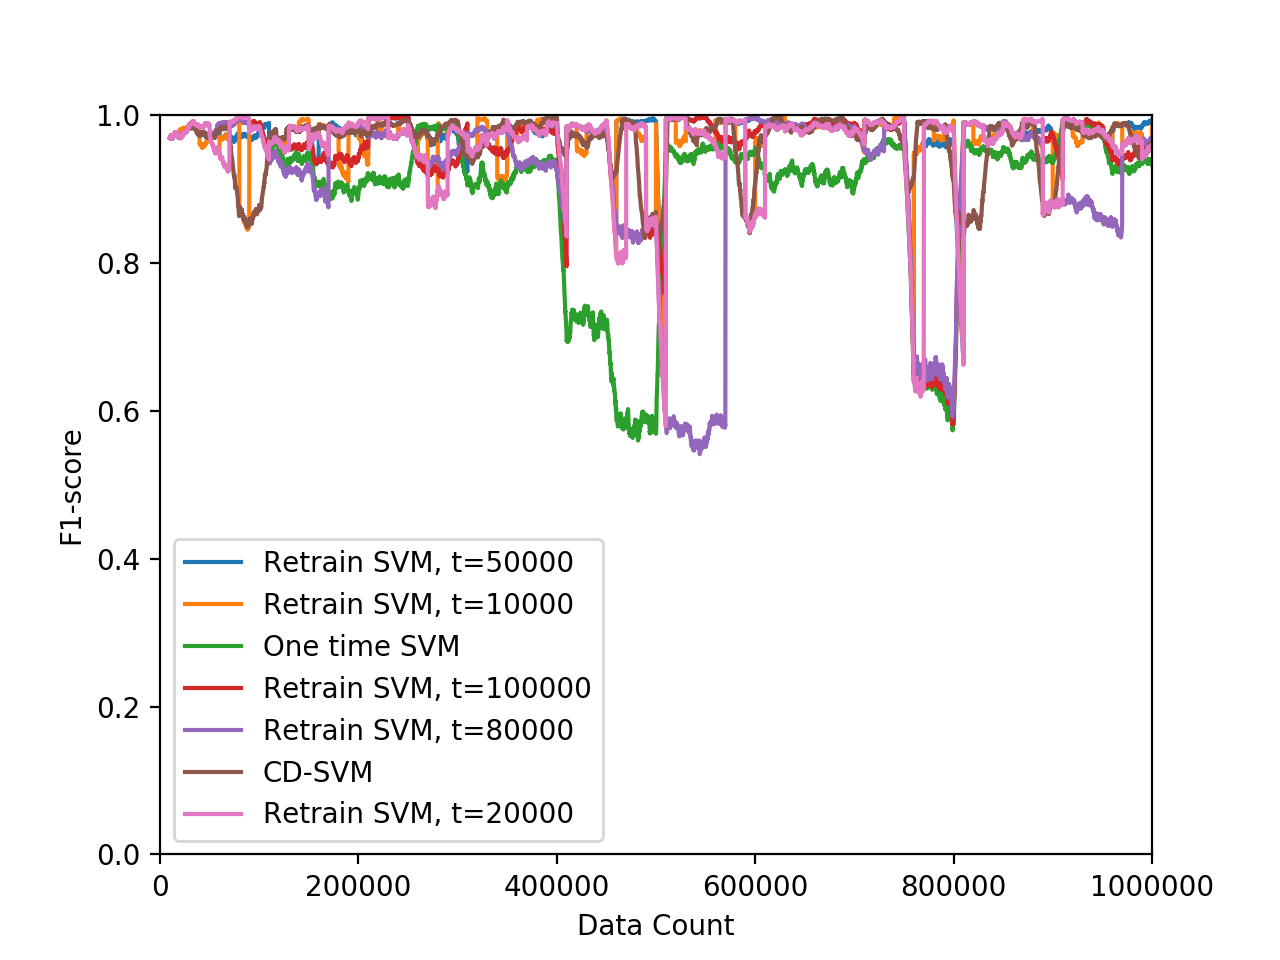

In [112]:

for alg in all_result:
    all_outliers  = all_result[alg]
    scores = []
    precisions = []
    recalls = []
    
    score_of_trainsition = []
    end_idx = []
    for i in sorted(all_outliers.keys()):
        
        ground = ground_truth_outliers[i]
        outliers = all_outliers[i]
       
        if len(ground) > 0 and len(outliers) > 0:
            score = len(set(ground).intersection(set(outliers)))
            precision, recall = 0,0
            precision = score *1.0/len(outliers)
            recall = score *1.0/len(ground)
            precisions.append(precision)
            recalls.append(recall)
            f1 = 0
            if precision + recall > 0:
                f1 = 2* precision * recall *1.0 / (precision + recall)
                
            scores.append(f1)
            end_idx.append(i)
                
            if i%50000 <= 1000:
                score_of_trainsition.append(f1)
        elif len(outliers) == 0 and len(ground) > 0:
            precisions.append(0)
            recalls.append(0)
            scores.append(0)
            end_idx.append(i)
        
    #print(scores) 
    if alg=='Retrain SVM, t=100000000':
        plt.plot(end_idx,scores, label="One time SVM")
    #elif alg in ["CD-SVM", "Retrain SVM, t=50000", "Retrain SVM, t=80000"]:
    else:
        plt.plot(end_idx, scores, label=alg)
plt.axis([0, 1000000, 0, 1])
plt.legend()
plt.xlabel("Data Count")
plt.ylabel("F1-score")
plt.show()

<IPython.core.display.Javascript object>


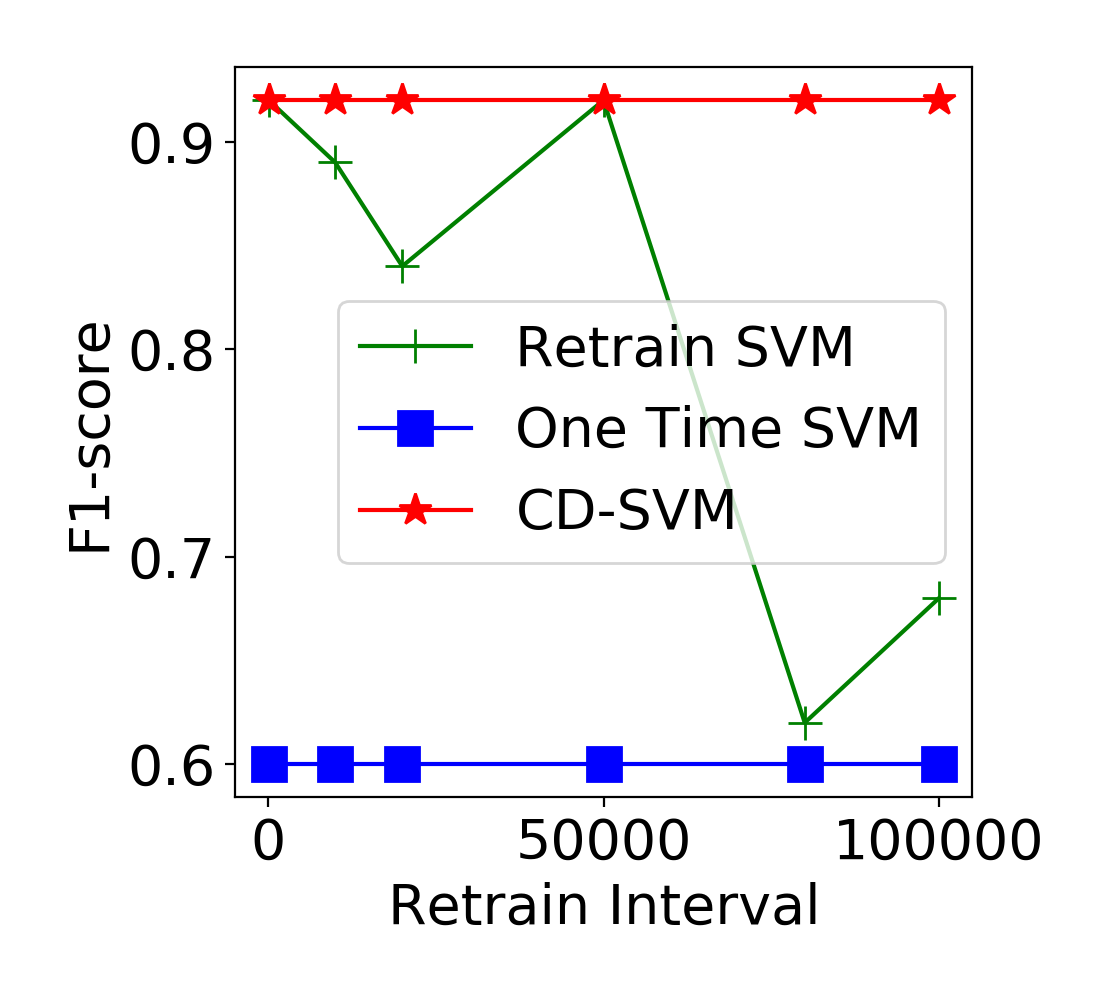

<IPython.core.display.Javascript object>


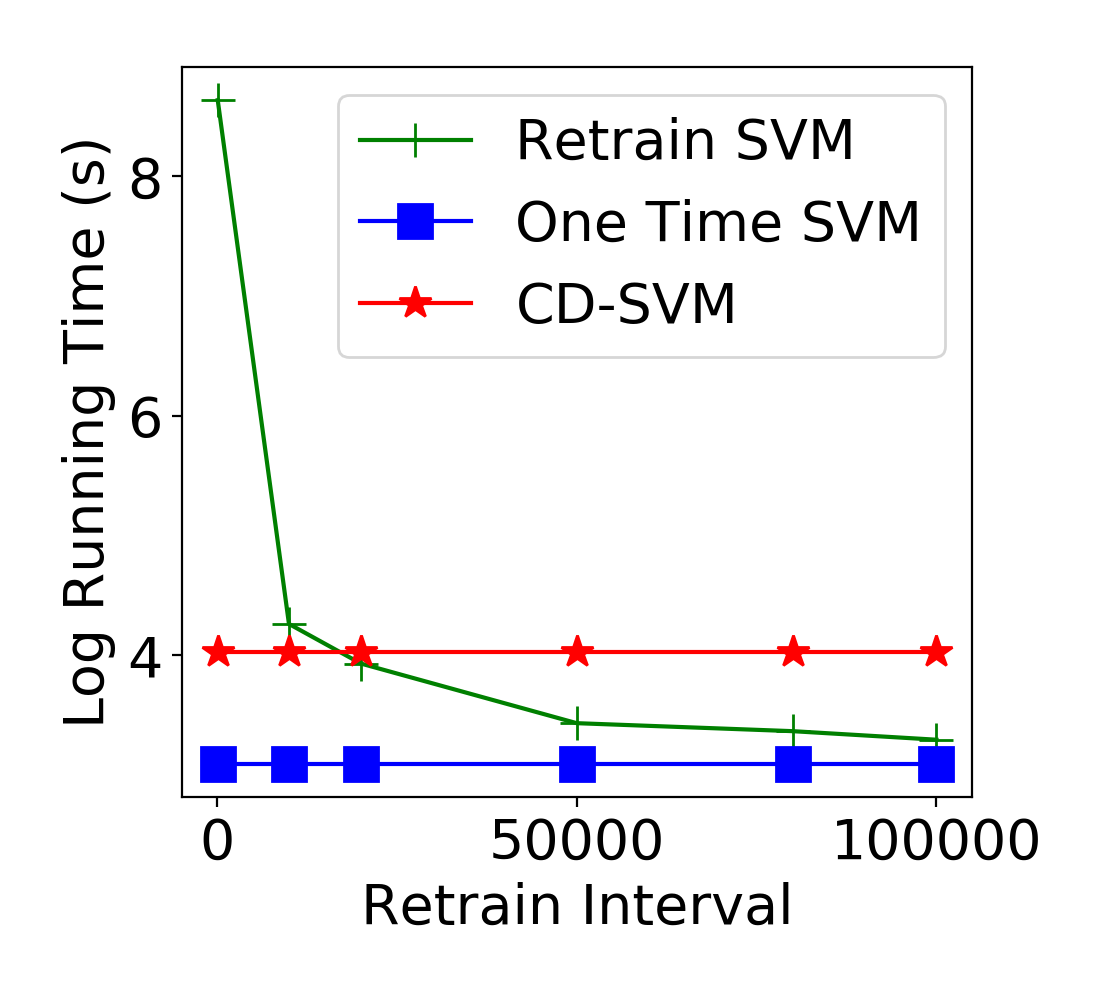

<IPython.core.display.Javascript object>


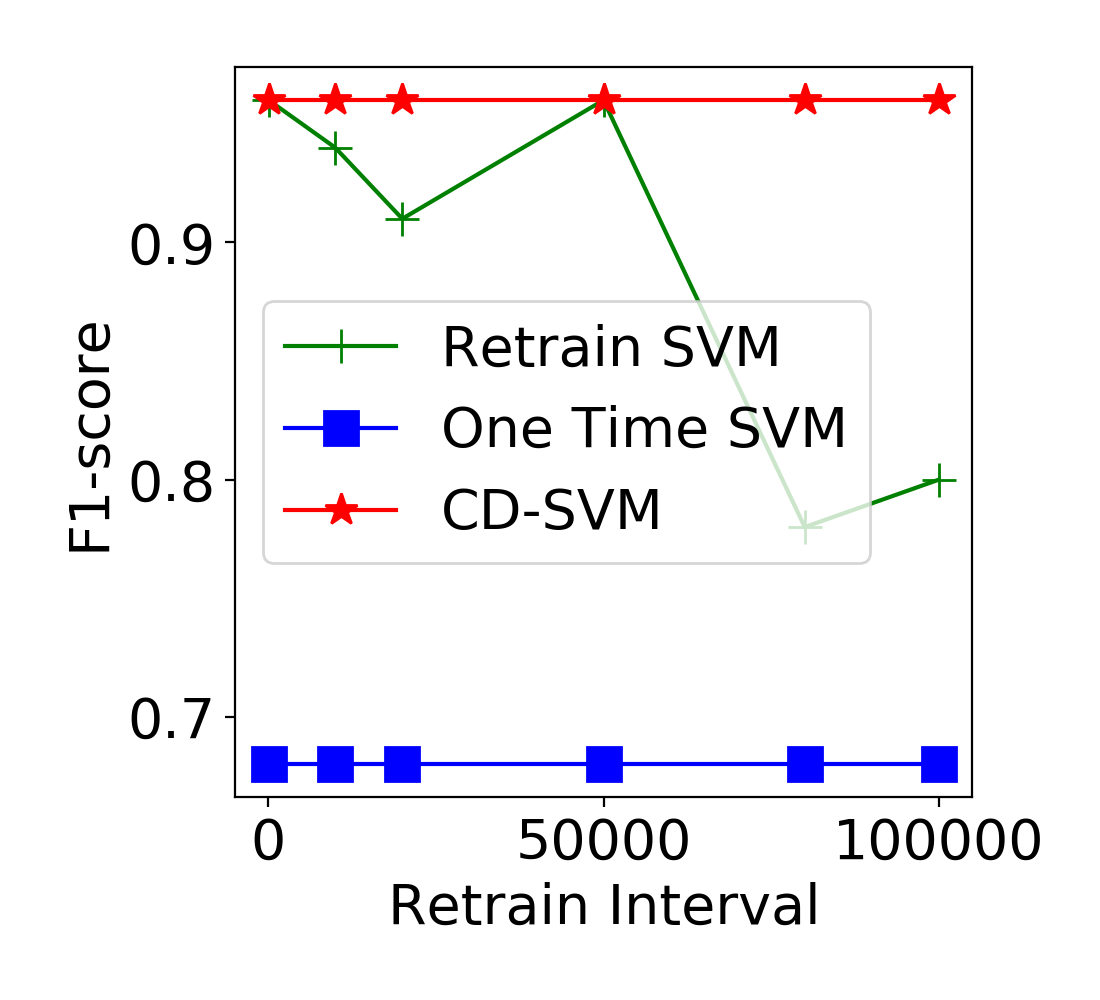

<IPython.core.display.Javascript object>


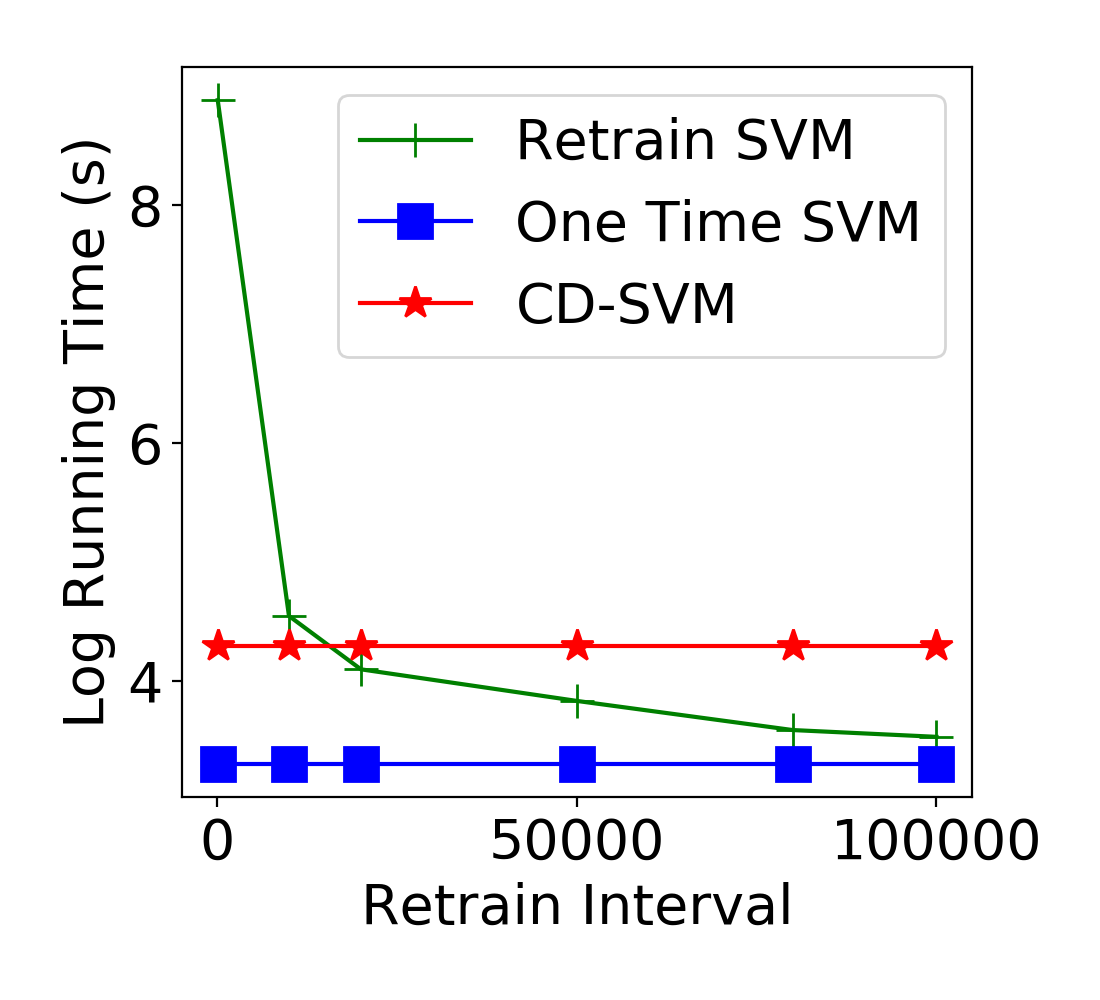

<IPython.core.display.Javascript object>


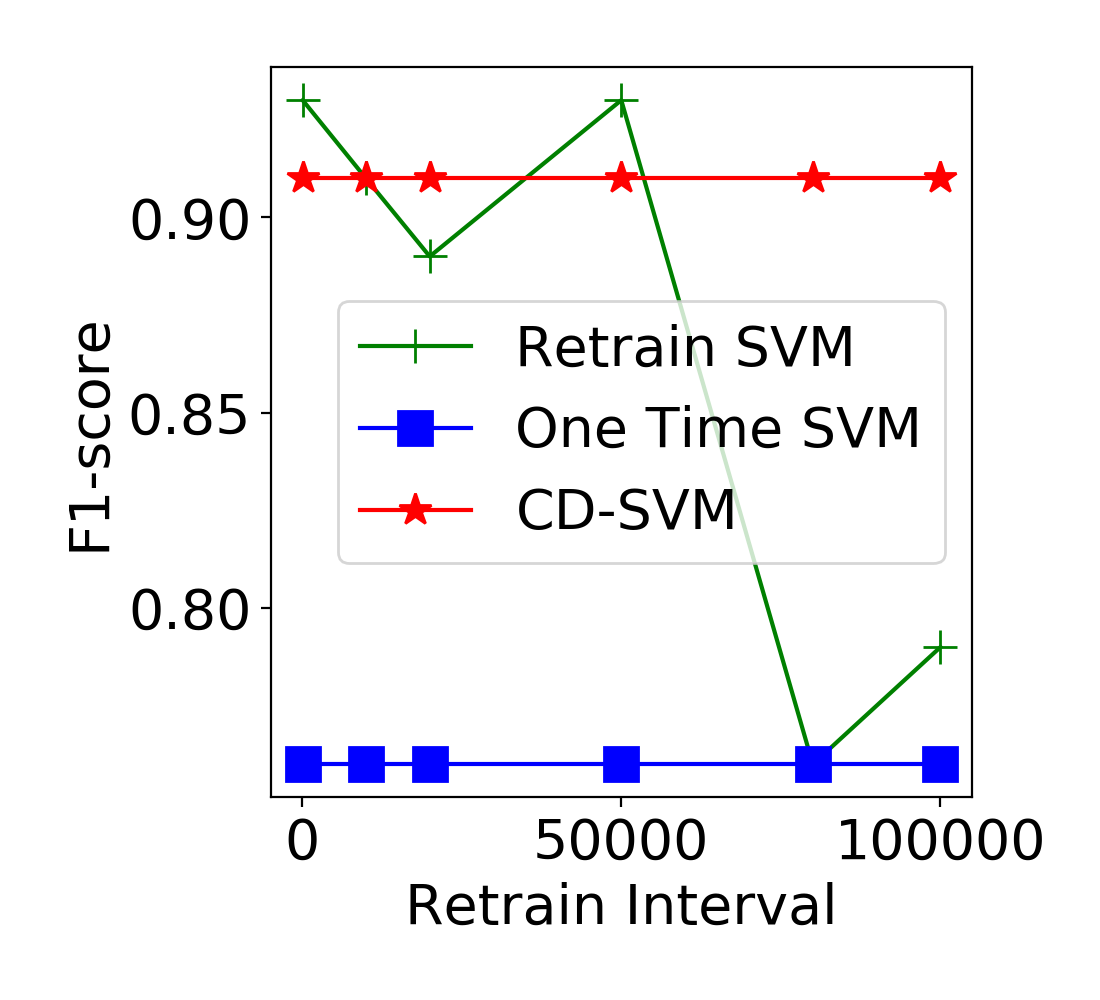

<IPython.core.display.Javascript object>


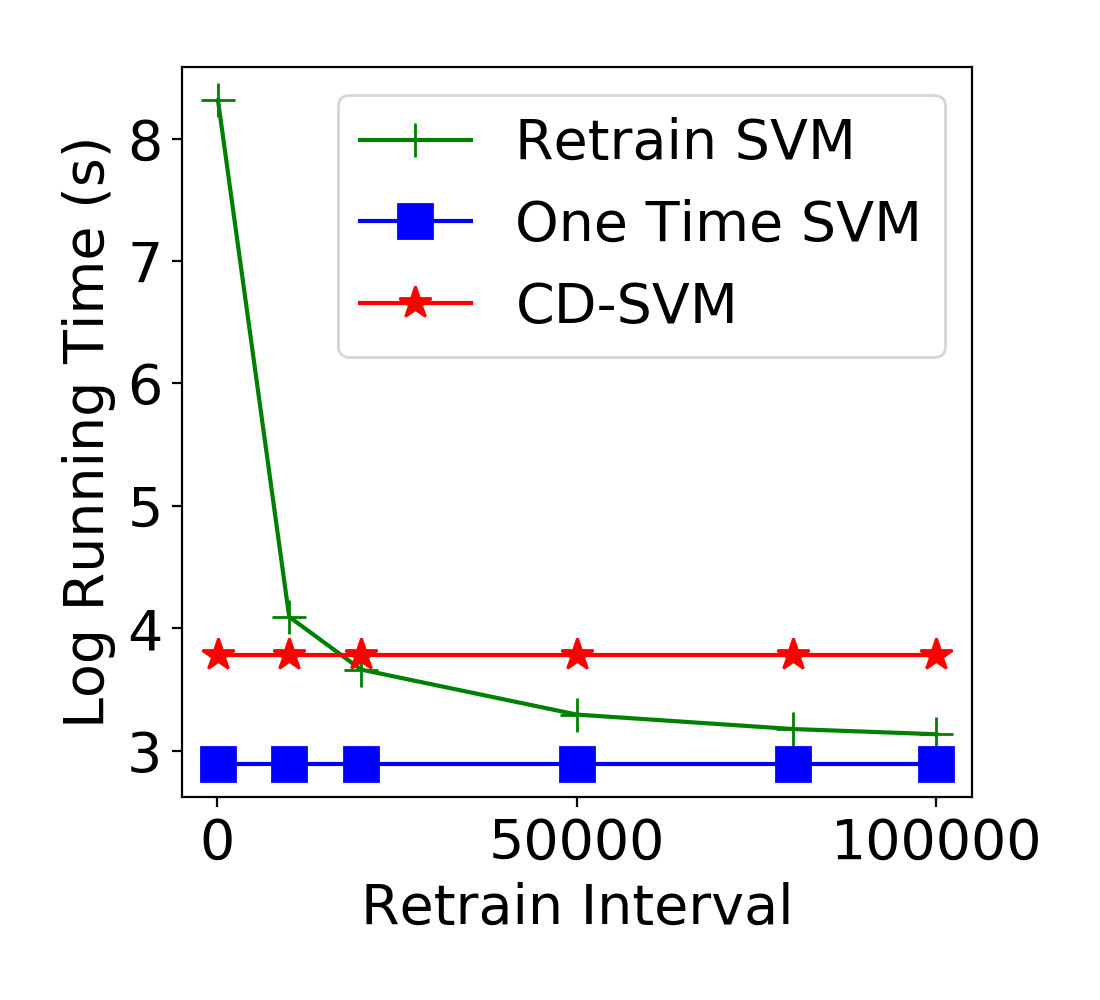

<IPython.core.display.Javascript object>


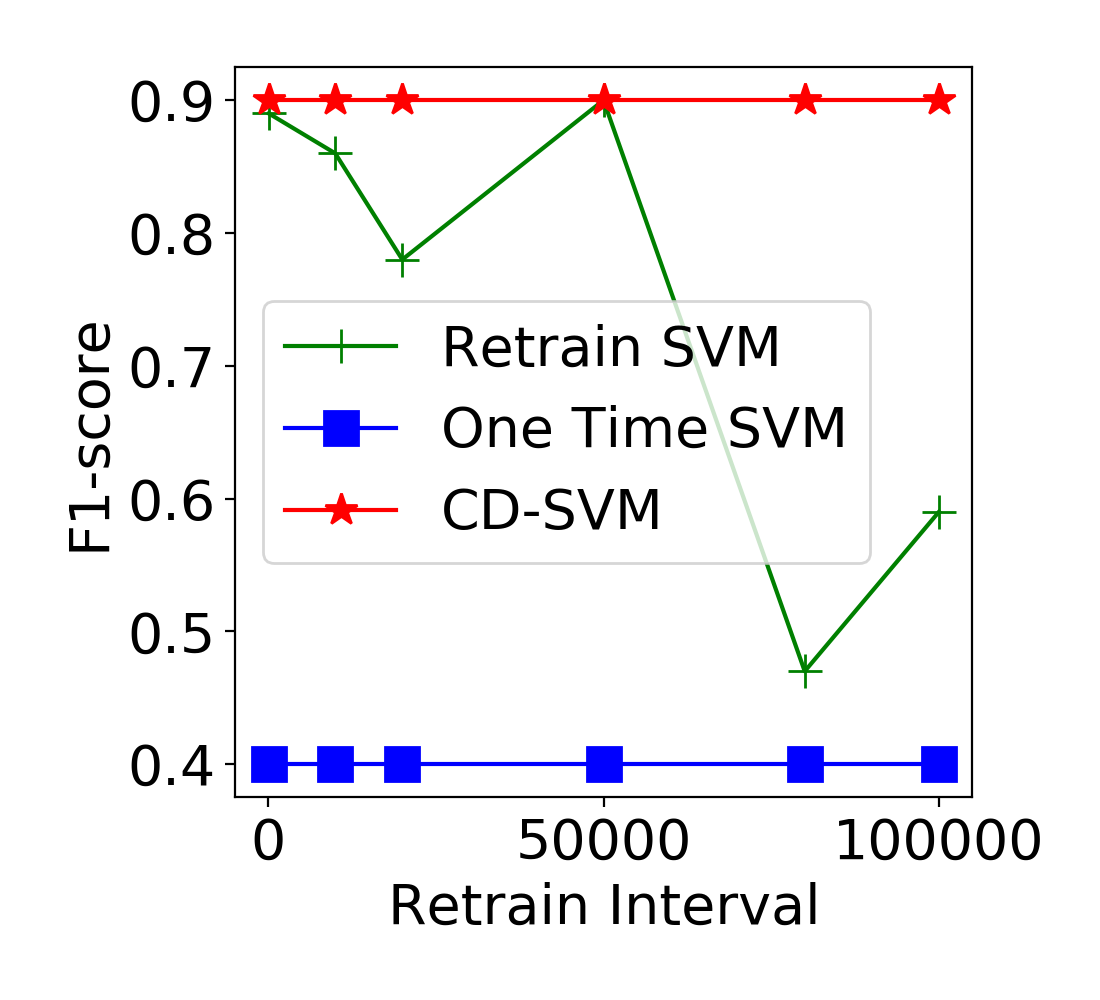

<IPython.core.display.Javascript object>


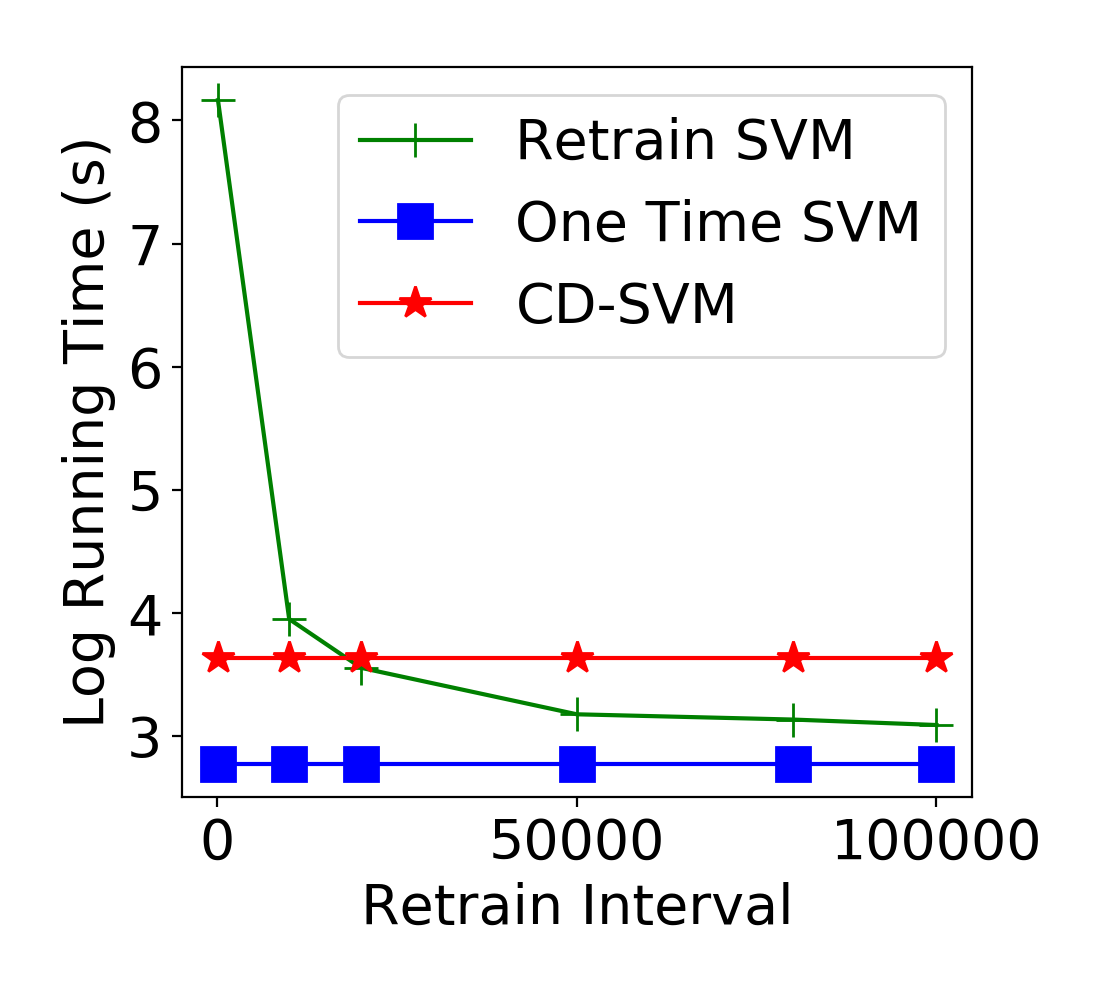

In [163]:
# Error Type: Double
#Fc dataset
# F1-score
plt.figure(figsize=figure_size)
retrain_intervals = [100, 10000, 20000, 50000, 80000, 100000]
retrain_score_fc = [0.92, 0.89, 0.84, 0.92, 0.62, 0.68]
one_time_fc = [0.60, 0.60, 0.60, 0.60, 0.60, 0.60]
cd_fc = [0.92, 0.92,0.92,0.92,0.92,0.92]
plt.plot(retrain_intervals, retrain_score_fc, color='g', marker='+',markersize=12, label="Retrain SVM")
plt.plot( retrain_intervals, one_time_fc,color='b', marker='s',markersize=12, label="One Time SVM")
plt.plot(retrain_intervals, cd_fc, color='r', marker='*',markersize=12, label="CD-SVM")
plt.legend()
plt.xlabel("Retrain Interval")
plt.ylabel("F1-score")
#plt.title("F1-score - FC, Error Type = Double")
plt.show()
plt.tight_layout()
plt.savefig("svm_f1_score_fc_double.pdf")
#Running Time
retrain_score_runtime = np.log([5633, 71.0, 51.0, 31.0, 29.0, 27.0])
one_time_fc_runtime = np.log([22, 22, 22, 22, 22, 22])
cd_fc_runtim = np.log([56, 56, 56, 56, 56, 56])
plt.figure(figsize=figure_size)
plt.plot(retrain_intervals, retrain_score_runtime, color='g', marker='+',markersize=12, label="Retrain SVM")
plt.plot( retrain_intervals, one_time_fc_runtime,color='b', marker='s',markersize=12, label="One Time SVM")
plt.plot(retrain_intervals, cd_fc_runtim, color='r', marker='*',markersize=12, label="CD-SVM")
plt.legend()
plt.xlabel("Retrain Interval")
plt.ylabel("Log Running Time (s)")
#plt.title("Log Running Time - FC, Error Type = Double")
plt.show()
plt.tight_layout()
plt.savefig("svm_runtime_fc_double.pdf")
# Ethylen dataset
# F1-score

retrain_score_ethyl = [0.96, 0.94, 0.91, 0.96, 0.78, 0.8]
one_time_ethyl = [0.68, 0.68, 0.68, 0.68, 0.68, 0.68]
cd_ethyl = [0.96,0.96,0.96,0.96,0.96,0.96]
plt.figure(figsize=figure_size)
plt.plot(retrain_intervals, retrain_score_ethyl, color='g', marker='+',markersize=12, label="Retrain SVM")
plt.plot( retrain_intervals, one_time_ethyl,color='b', marker='s',markersize=12, label="One Time SVM")
plt.plot(retrain_intervals, cd_ethyl, color='r', marker='*',markersize=12, label="CD-SVM")
plt.legend()
plt.xlabel("Retrain Interval")
plt.ylabel("F1-score")
#plt.title("F1-score - EM, Error Type = Double")
plt.show()
plt.tight_layout()
plt.savefig("svm_f1_score_em_double.pdf")
# Run time
retrain_score_runtime_ethyl = np.log([7200, 94, 60, 46, 36, 34])
one_time_ethyl_runtime = np.log([27,27,27,27,27,27])
cd_ethyl_runtim = np.log([73,73,73,73,73,73])
plt.figure(figsize=figure_size)
plt.plot(retrain_intervals, retrain_score_runtime_ethyl, color='g', marker='+',markersize=12, label="Retrain SVM")
plt.plot( retrain_intervals, one_time_ethyl_runtime,color='b', marker='s',markersize=12, label="One Time SVM")
plt.plot(retrain_intervals, cd_ethyl_runtim, color='r', marker='*',markersize=12, label="CD-SVM")
plt.legend()
plt.xlabel("Retrain Interval")
plt.ylabel("Log Running Time (s)")
#plt.title("Log Running Time - EM, Error Type = Double")
plt.show()
plt.tight_layout()
plt.savefig("svm_runtime_em_double.pdf")

# HPC dataset
# F1-score
retrain_score_hpc = [0.93, 0.91, 0.89, 0.93, 0.76, 0.79]
one_time_hpc = [0.76,0.76,0.76,0.76,0.76,0.76]
cd_hpc = [0.91,0.91,0.91,0.91,0.91,0.91]
plt.figure(figsize=figure_size)
plt.plot(retrain_intervals, retrain_score_hpc, color='g', marker='+',markersize=12, label="Retrain SVM")
plt.plot( retrain_intervals, one_time_hpc,color='b', marker='s',markersize=12, label="One Time SVM")
plt.plot(retrain_intervals, cd_hpc, color='r', marker='*',markersize=12, label="CD-SVM")
plt.legend()
plt.xlabel("Retrain Interval")
plt.ylabel("F1-score")
#plt.title("F1-score - HPC, Error Type = Double")
plt.show()
plt.tight_layout()
plt.savefig("svm_f1_score_hpc_double.pdf")
# Run time
retrain_score_runtime_hpc = np.log([4079, 60, 39, 27, 24, 23])
one_time_hpc_runtime = np.log([18,18,18,18,18,18])
cd_hpc_runtime = np.log([44,44,44,44,44,44])
plt.figure(figsize=figure_size)
plt.plot(retrain_intervals, retrain_score_runtime_hpc, color='g', marker='+',markersize=12, label="Retrain SVM")
plt.plot( retrain_intervals, one_time_hpc_runtime,color='b', marker='s',markersize=12, label="One Time SVM")
plt.plot(retrain_intervals, cd_hpc_runtime, color='r', marker='*',markersize=12, label="CD-SVM")
plt.legend()
plt.xlabel("Retrain Interval")
plt.ylabel("Log Running Time (s)")
#plt.title("Log Running Time - HPC, Error Type = Double")
plt.show()
plt.tight_layout()
plt.savefig("svm_runtime_hpc_double.pdf")
# TAO dataset
retrain_score_tao = [0.89, 0.86, 0.78, 0.9, 0.47, 0.59]
one_time_tao = [0.4, 0.4, 0.4, 0.4, 0.4, 0.4]
cd_tao = [0.9,0.9,0.9,0.9,0.9,0.9]
plt.figure(figsize=figure_size)
plt.plot(retrain_intervals, retrain_score_tao, color='g', marker='+',markersize=12, label="Retrain SVM")
plt.plot( retrain_intervals, one_time_tao, color='b', marker='s',markersize=12, label="One Time SVM")
plt.plot(retrain_intervals, cd_tao, color='r', marker='*',markersize=12, label="CD-SVM")
plt.legend()
plt.xlabel("Retrain Interval")
plt.ylabel("F1-score")
#plt.title("F1-score - TAO, Error Type = Double")
plt.show()
plt.tight_layout()
plt.savefig("svm_f1_score_tao_double.pdf")
# Run time
retrain_score_runtime_tao = np.log([3512, 52, 35, 24, 23, 22])
one_time_tao_runtime = np.log([16,16,16,16,16,16])
cd_tao_runtime = np.log([38,38,38,38,38,38])
plt.figure(figsize=figure_size)
plt.plot(retrain_intervals, retrain_score_runtime_tao, color='g', marker='+',markersize=12, label="Retrain SVM")
plt.plot( retrain_intervals, one_time_tao_runtime,color='b', marker='s',markersize=12, label="One Time SVM")
plt.plot(retrain_intervals, cd_tao_runtime, color='r', marker='*',markersize=12, label="CD-SVM")
plt.legend()
plt.xlabel("Retrain Interval")
plt.ylabel("Log Running Time (s)")
#plt.title("Log Running Time - TAO, Error Type = Double")
plt.show()
plt.tight_layout()
plt.savefig("svm_runtime_tao_double.pdf")


<IPython.core.display.Javascript object>


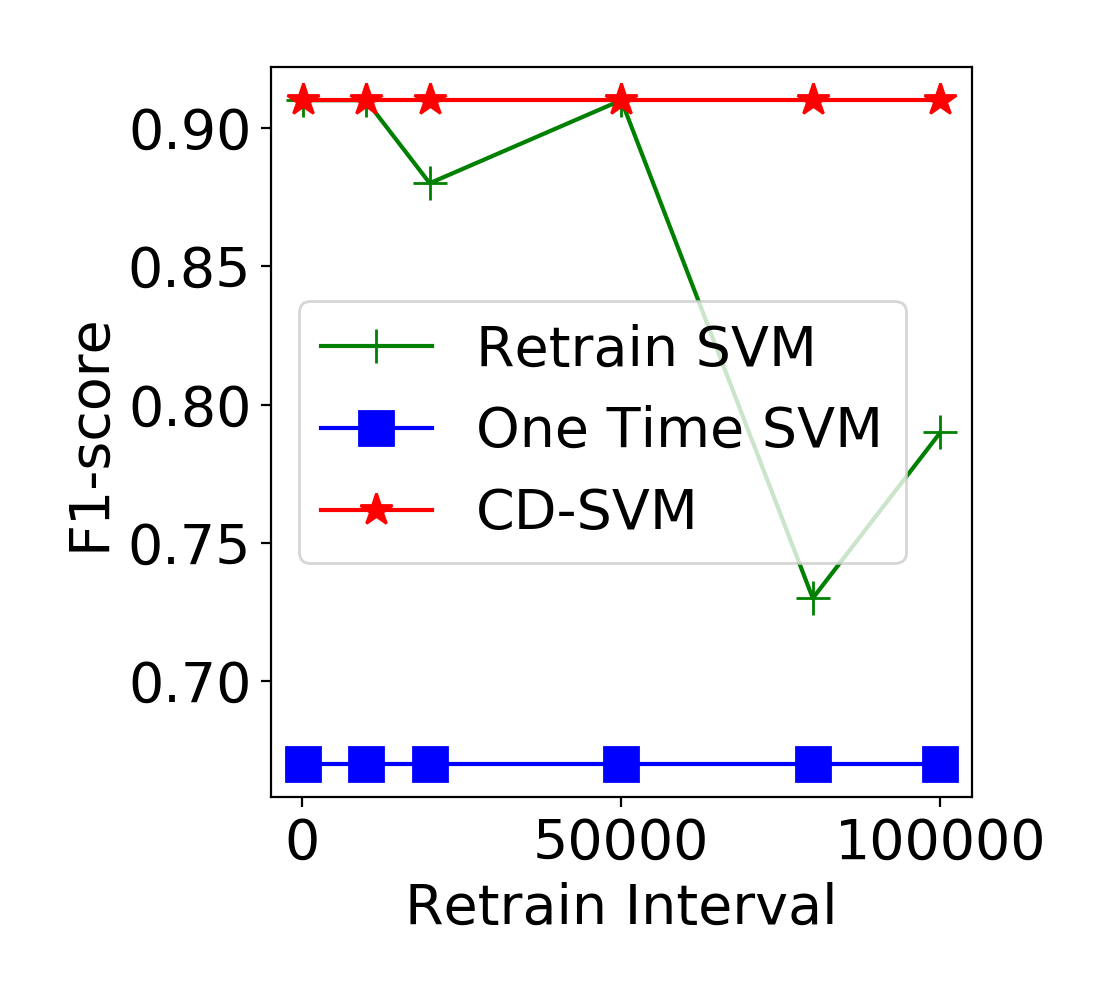

<IPython.core.display.Javascript object>


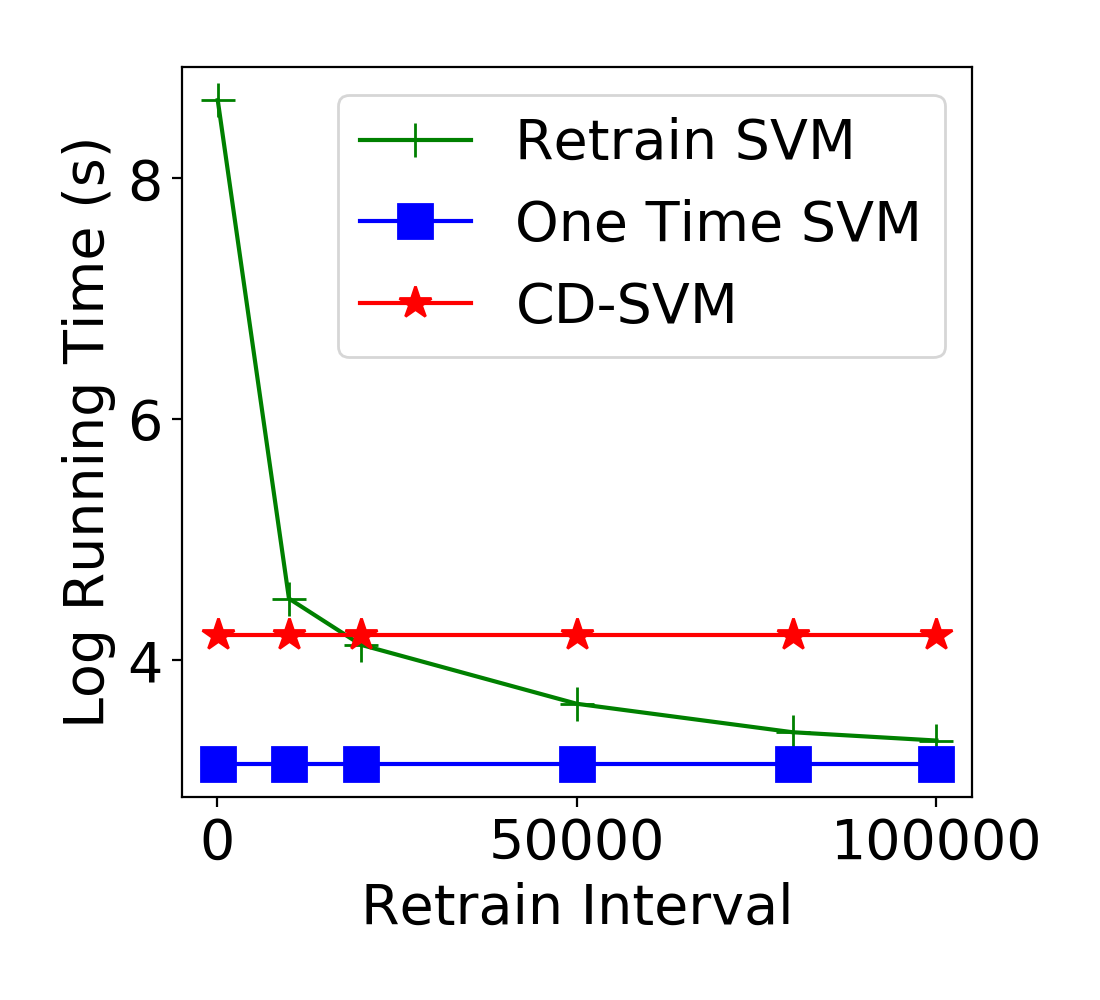

<IPython.core.display.Javascript object>


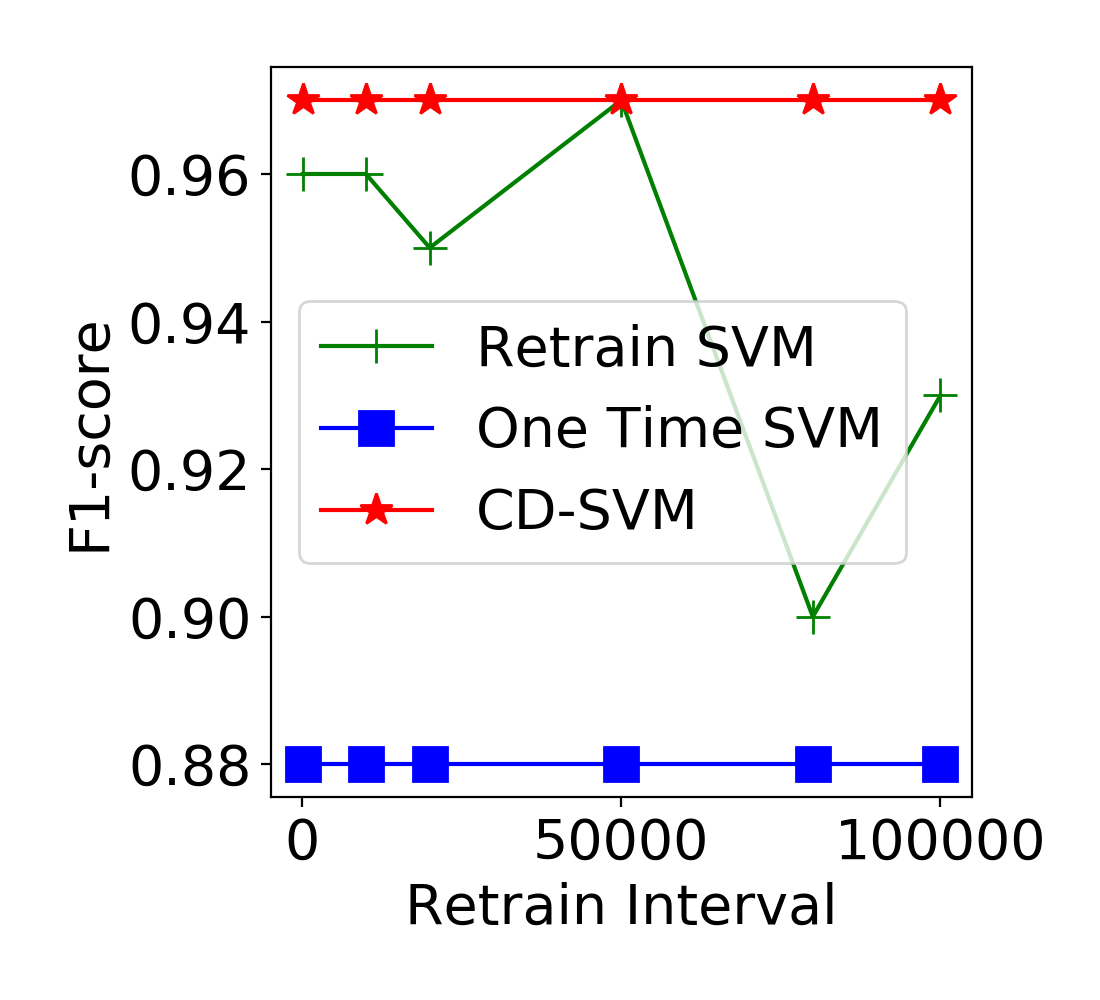

<IPython.core.display.Javascript object>


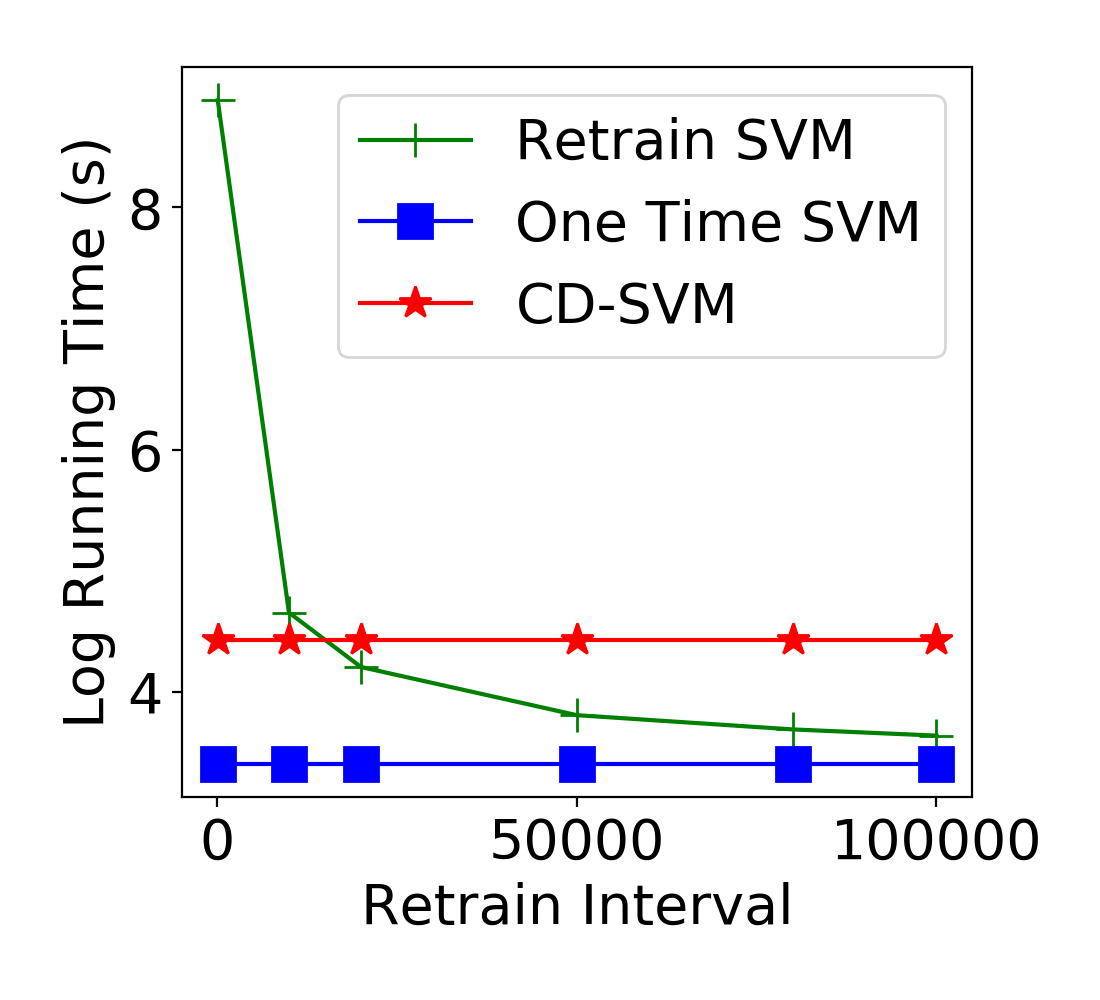

<IPython.core.display.Javascript object>


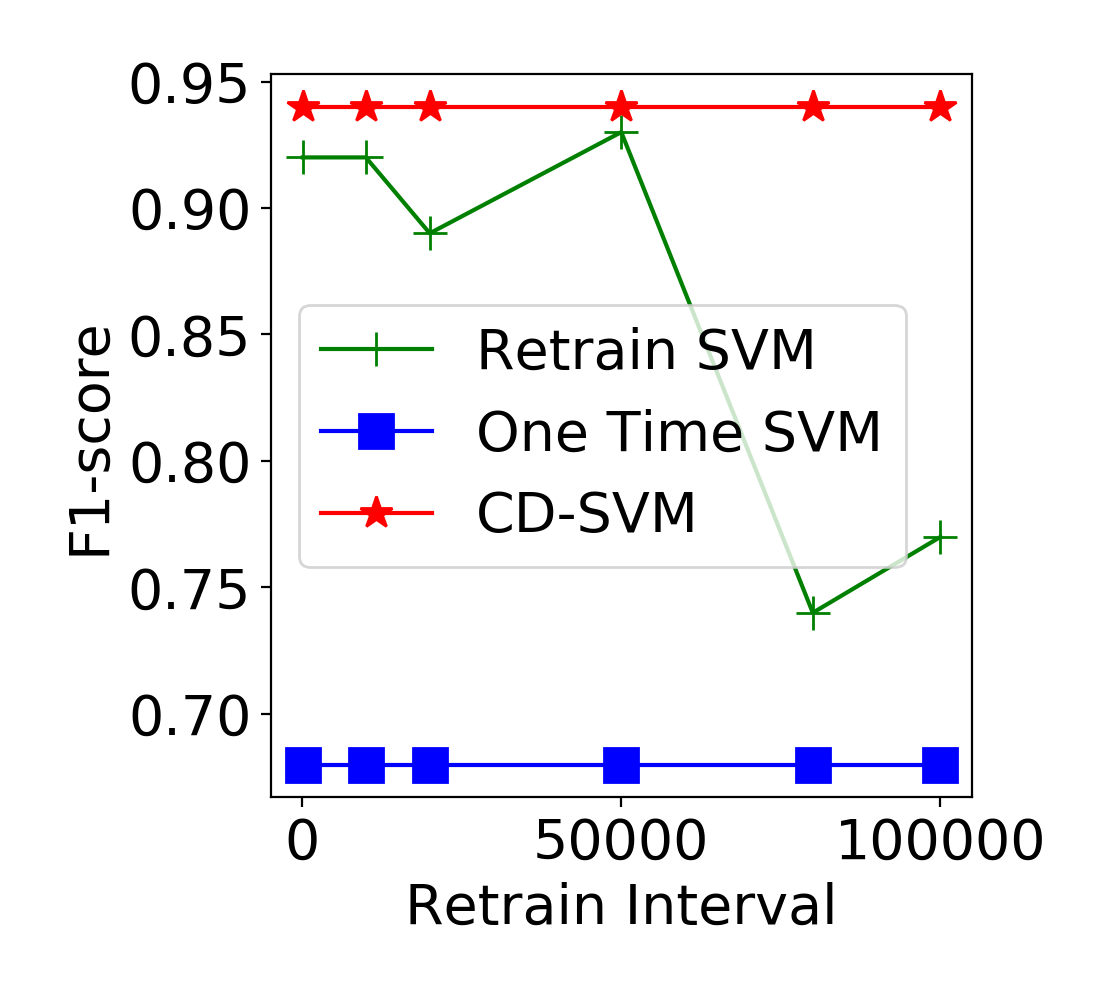

<IPython.core.display.Javascript object>


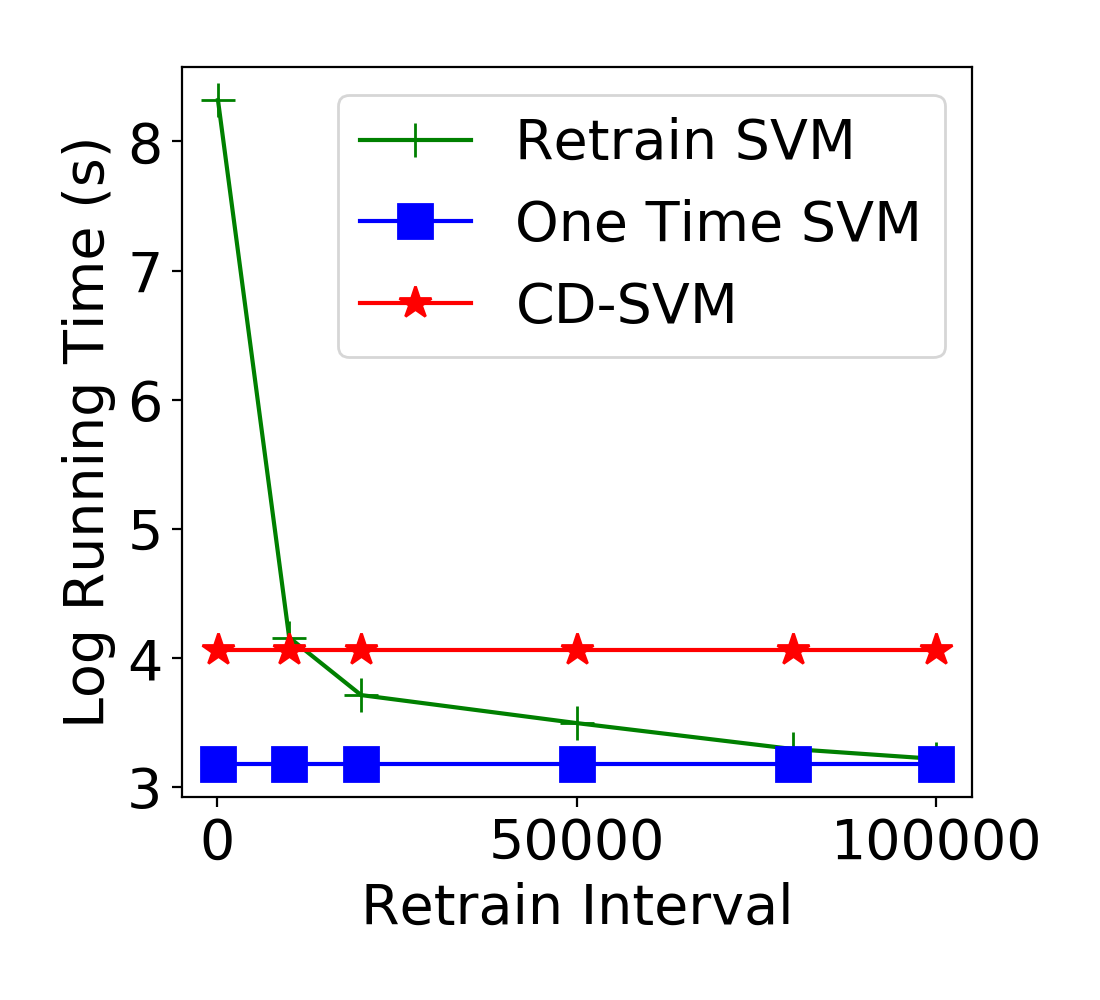

<IPython.core.display.Javascript object>


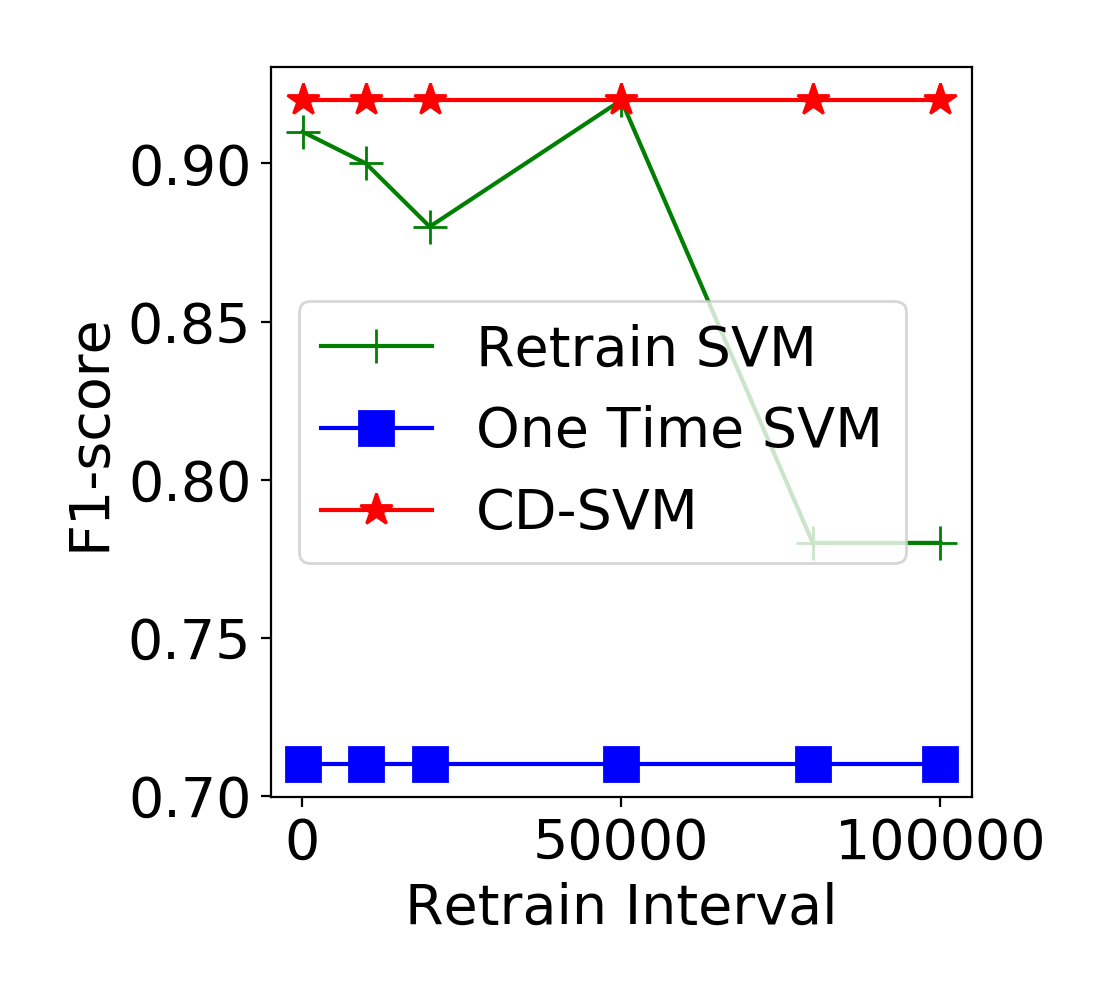

<IPython.core.display.Javascript object>


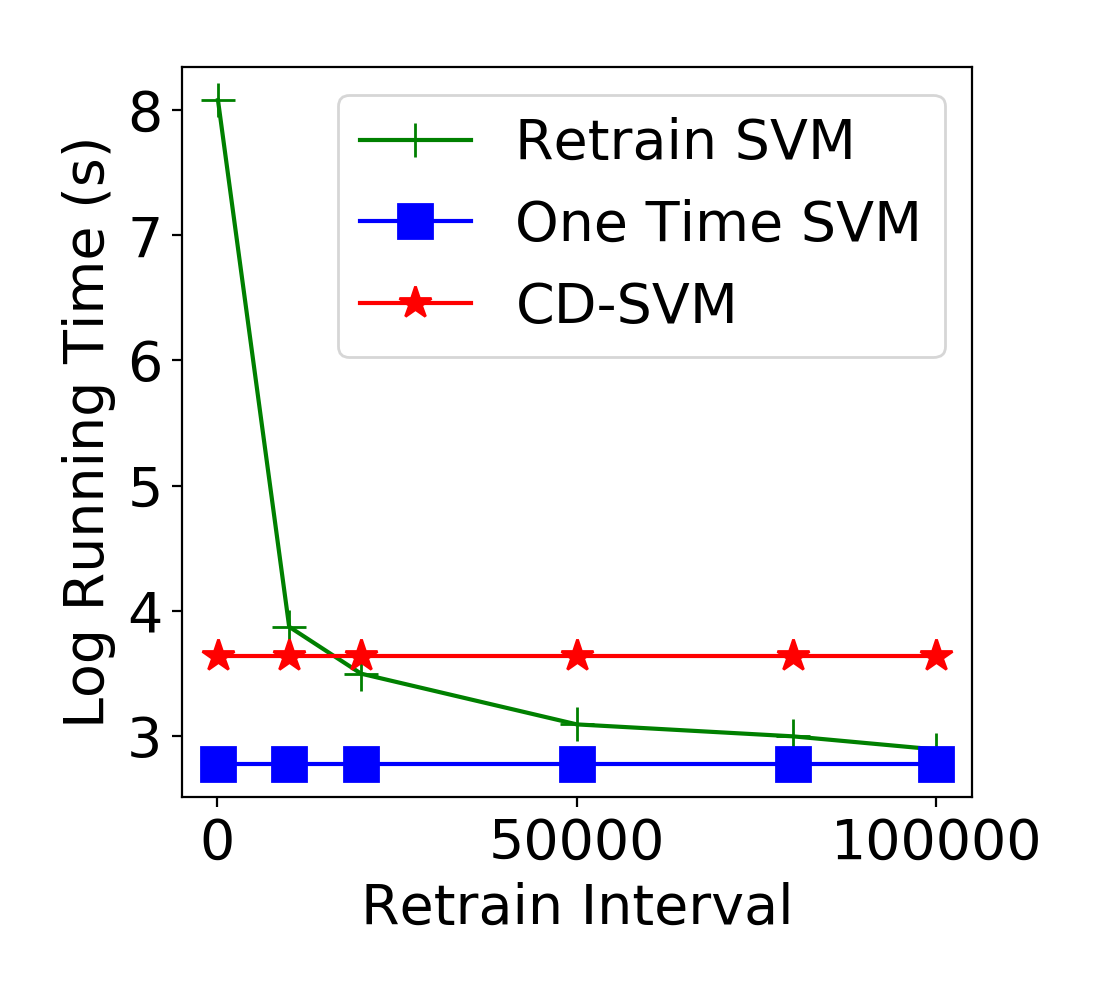

In [156]:
# Error Type: Gaussian
#Fc dataset
# F1-score
plt.figure(figsize=figure_size)
retrain_intervals = [100, 10000, 20000, 50000, 80000, 100000]
retrain_score_fc = [0.91, 0.91, 0.88, 0.91, 0.73, 0.79]
one_time_fc = [0.67, 0.67, 0.67, 0.67, 0.67, 0.67]
cd_fc = [0.91, 0.91, 0.91, 0.91, 0.91, 0.91]
plt.plot(retrain_intervals, retrain_score_fc, color='g', marker='+',markersize=12, label="Retrain SVM")
plt.plot( retrain_intervals, one_time_fc,color='b', marker='s',markersize=12, label="One Time SVM")
plt.plot(retrain_intervals, cd_fc, color='r', marker='*',markersize=12, label="CD-SVM")
plt.legend()
plt.xlabel("Retrain Interval")
plt.ylabel("F1-score")
#plt.title("F1-score - FC, Error Type = Gaussian")

plt.show()
plt.tight_layout()
plt.savefig("svm_f1_score_fc_gaussian.pdf")
#Running Time
retrain_score_runtime = np.log([5701, 91, 62, 38, 30, 28])
one_time_fc_runtime = np.log([23, 23, 23, 23, 23, 23])
cd_fc_runtim = np.log([67, 67, 67, 67, 67, 67])
plt.figure(figsize=figure_size)
plt.plot(retrain_intervals, retrain_score_runtime, color='g', marker='+',markersize=12, label="Retrain SVM")
plt.plot( retrain_intervals, one_time_fc_runtime,color='b', marker='s',markersize=12, label="One Time SVM")
plt.plot(retrain_intervals, cd_fc_runtim, color='r', marker='*',markersize=12, label="CD-SVM")
plt.legend()
plt.xlabel("Retrain Interval")
plt.ylabel("Log Running Time (s)")
#plt.title("Log Running Time - FC, Error Type = Gaussian")
plt.show()
plt.tight_layout()
plt.savefig("svm_runtime_fc_gaussian.pdf")
# Ethylen dataset
# F1-score

retrain_score_ethyl = [0.96, 0.96, 0.95, 0.97, 0.9, 0.93]
one_time_ethyl = [0.88, 0.88,0.88, 0.88,0.88, 0.88]
cd_ethyl = [0.97, 0.97, 0.97, 0.97, 0.97, 0.97]
plt.figure(figsize=figure_size)
plt.plot(retrain_intervals, retrain_score_ethyl, color='g', marker='+',markersize=12, label="Retrain SVM")
plt.plot( retrain_intervals, one_time_ethyl,color='b', marker='s',markersize=12, label="One Time SVM")
plt.plot(retrain_intervals, cd_ethyl, color='r', marker='*',markersize=12, label="CD-SVM")
plt.legend()
plt.xlabel("Retrain Interval")
plt.ylabel("F1-score")
#plt.title("F1-score - Ethylen, Error Type = Gaussian")
plt.show()
plt.tight_layout()
plt.savefig("svm_f1_score_em_gaussian.pdf")
# Run time
retrain_score_runtime_ethyl = np.log([7232, 105, 67, 45, 40, 38])
one_time_ethyl_runtime = np.log([30, 30, 30, 30, 30, 30])
cd_ethyl_runtim = np.log([84, 84, 84, 84, 84, 84])
plt.figure(figsize=figure_size)
plt.plot(retrain_intervals, retrain_score_runtime_ethyl, color='g', marker='+',markersize=12, label="Retrain SVM")
plt.plot( retrain_intervals, one_time_ethyl_runtime,color='b', marker='s',markersize=12, label="One Time SVM")
plt.plot(retrain_intervals, cd_ethyl_runtim, color='r', marker='*',markersize=12, label="CD-SVM")
plt.legend()
plt.xlabel("Retrain Interval")
plt.ylabel("Log Running Time (s)")
#plt.title("Log Running Time - Ethylen, Error Type = Gaussian")
plt.show()
plt.tight_layout()
plt.savefig("svm_runtime_em_gaussian.pdf")

# HPC dataset
# F1-score
retrain_score_hpc = [0.92, 0.92, 0.89, 0.93, 0.74, 0.77]
one_time_hpc = [0.68, 0.68, 0.68, 0.68, 0.68, 0.68]
cd_hpc = [0.94, 0.94, 0.94,0.94, 0.94, 0.94]
plt.figure(figsize=figure_size)
plt.plot(retrain_intervals, retrain_score_hpc, color='g', marker='+',markersize=12, label="Retrain SVM")
plt.plot( retrain_intervals, one_time_hpc,color='b', marker='s',markersize=12, label="One Time SVM")
plt.plot(retrain_intervals, cd_hpc, color='r', marker='*',markersize=12, label="CD-SVM")
plt.legend()
plt.xlabel("Retrain Interval")
plt.ylabel("F1-score")
#plt.title("F1-score - HPC, Error Type = Gaussian")
plt.show()
plt.tight_layout()
plt.savefig("svm_f1_score_hpc_gaussian.pdf")
# Run time
retrain_score_runtime_hpc = np.log([4102, 64, 41, 33, 27, 25])
one_time_hpc_runtime = np.log([24, 24, 24, 24, 24, 24])
cd_hpc_runtime = np.log([58, 58, 58, 58, 58, 58])
plt.figure(figsize=figure_size)
plt.plot(retrain_intervals, retrain_score_runtime_hpc, color='g', marker='+',markersize=12, label="Retrain SVM")
plt.plot( retrain_intervals, one_time_hpc_runtime,color='b', marker='s',markersize=12, label="One Time SVM")
plt.plot(retrain_intervals, cd_hpc_runtime, color='r', marker='*',markersize=12, label="CD-SVM")
plt.legend()
plt.xlabel("Retrain Interval")
plt.ylabel("Log Running Time (s)")
#plt.title("Log Running Time - HPC, Error Type = Gaussian")
plt.show()
plt.tight_layout()
plt.savefig("svm_runtime_hpc_gaussian.pdf")
# TAO dataset
retrain_score_tao = [0.91, 0.9, 0.88, 0.92, 0.78, 0.78]
one_time_tao = [0.71, 0.71,0.71, 0.71,0.71, 0.71]
cd_tao = [0.92, 0.92,0.92, 0.92,0.92, 0.92]
plt.figure(figsize=figure_size)
plt.plot(retrain_intervals, retrain_score_tao, color='g', marker='+',markersize=12, label="Retrain SVM")
plt.plot( retrain_intervals, one_time_tao, color='b', marker='s',markersize=12, label="One Time SVM")
plt.plot(retrain_intervals, cd_tao, color='r', marker='*',markersize=12, label="CD-SVM")
plt.legend()
plt.xlabel("Retrain Interval")
plt.ylabel("F1-score")
#plt.title("F1-score - TAO, Error Type = Gaussian")
plt.show()
plt.tight_layout()
plt.savefig("svm_f1_score_tao_gaussian.pdf")
# Run time
retrain_score_runtime_tao = np.log([3228, 48, 33, 22, 20, 18])
one_time_tao_runtime = np.log([16,16, 16, 16, 16, 16])
cd_tao_runtime = np.log([38, 38, 38, 38, 38, 38])
plt.figure(figsize=figure_size)
plt.plot(retrain_intervals, retrain_score_runtime_tao, color='g', marker='+',markersize=12, label="Retrain SVM")
plt.plot( retrain_intervals, one_time_tao_runtime,color='b', marker='s',markersize=12, label="One Time SVM")
plt.plot(retrain_intervals, cd_tao_runtime, color='r', marker='*',markersize=12, label="CD-SVM")
plt.legend()
plt.xlabel("Retrain Interval")
plt.ylabel("Log Running Time (s)")
#plt.title("Log Running Time - TAO, Error Type = Gaussian")
plt.show()
plt.tight_layout()

plt.savefig("svm_runtime_tao_gaussian.pdf")

<IPython.core.display.Javascript object>


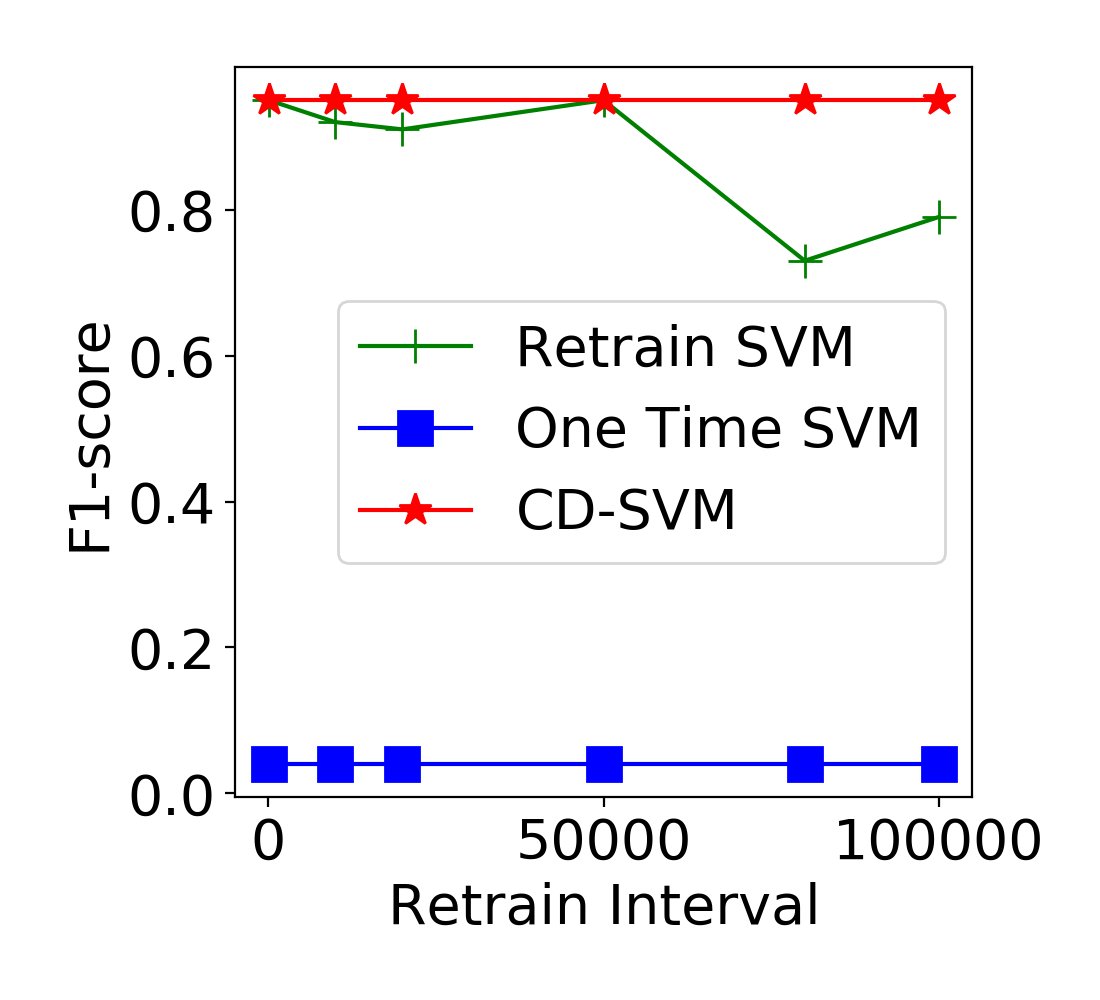

<IPython.core.display.Javascript object>


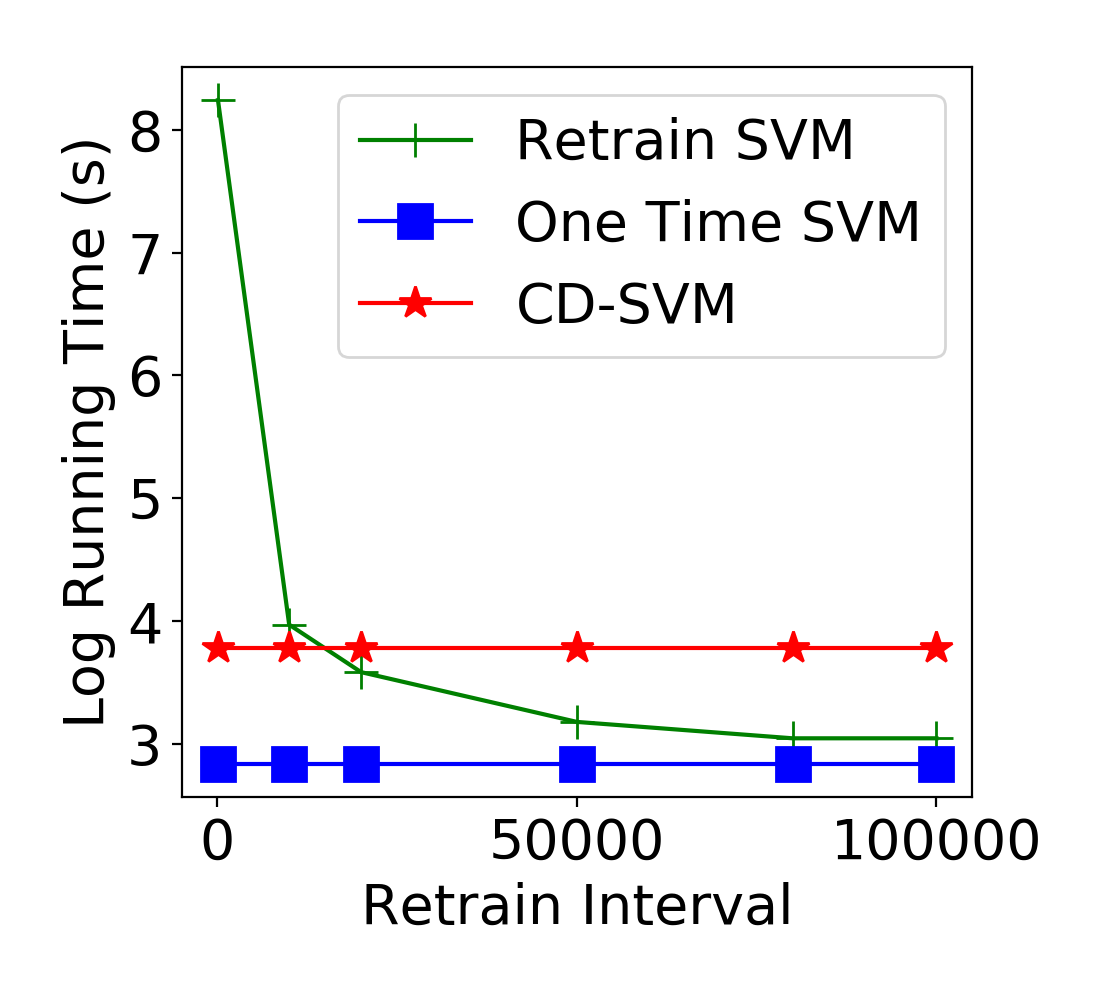

<IPython.core.display.Javascript object>


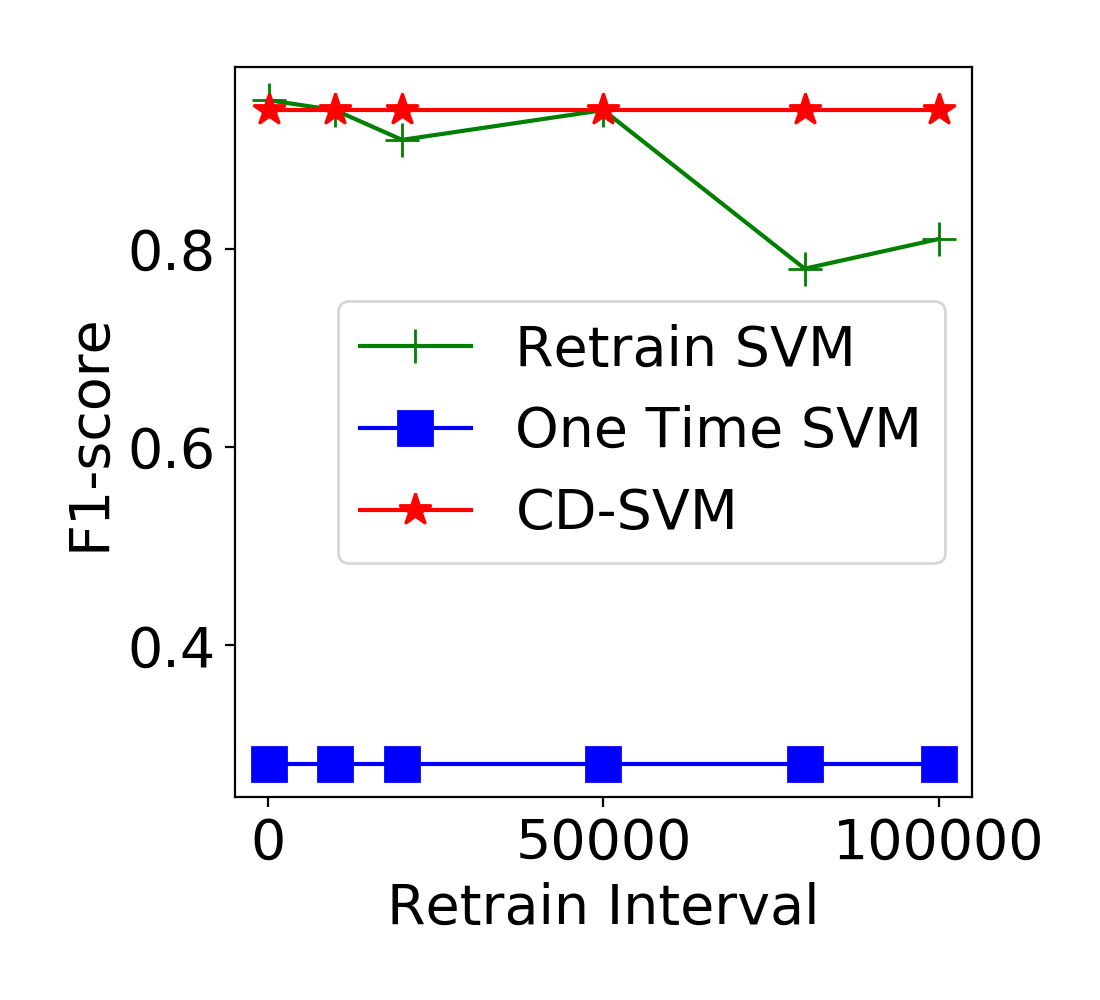

<IPython.core.display.Javascript object>


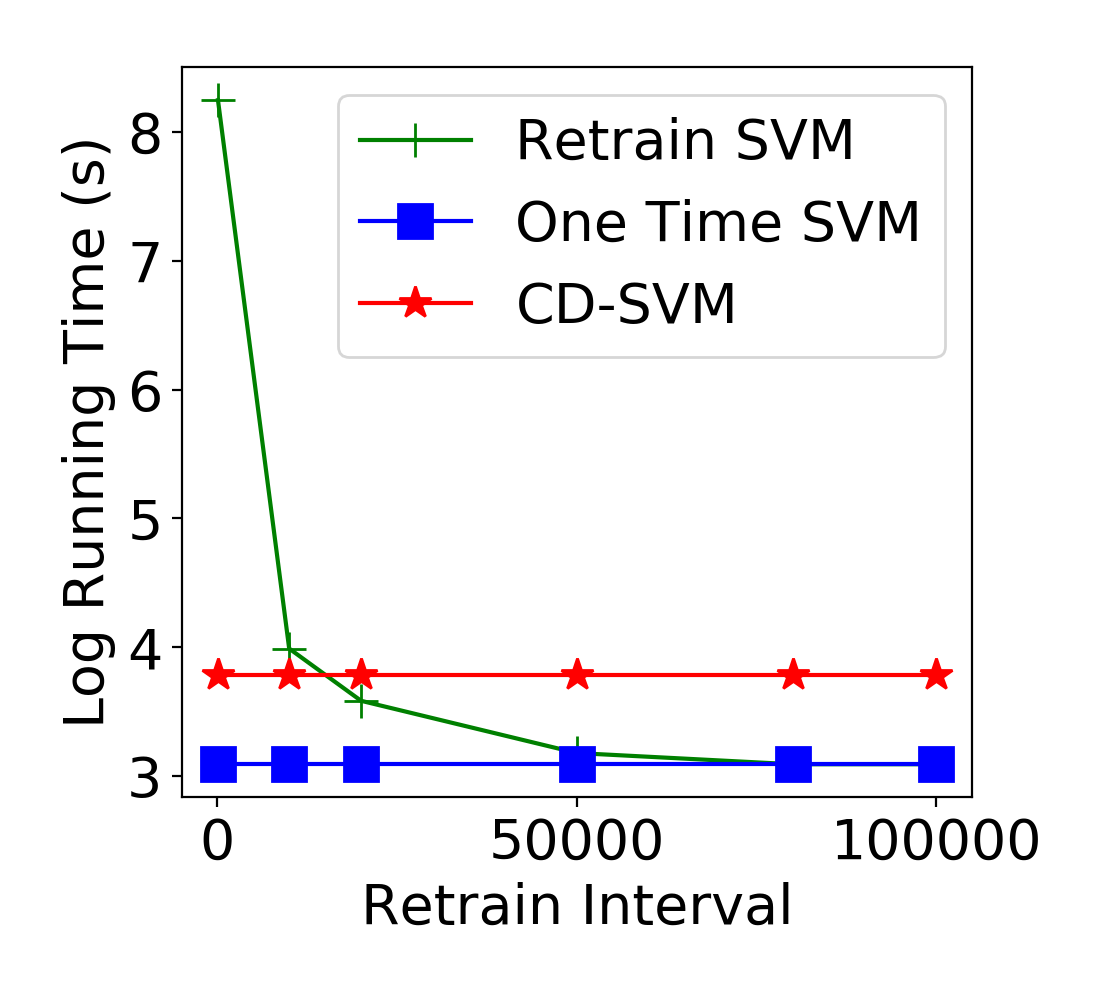

<IPython.core.display.Javascript object>


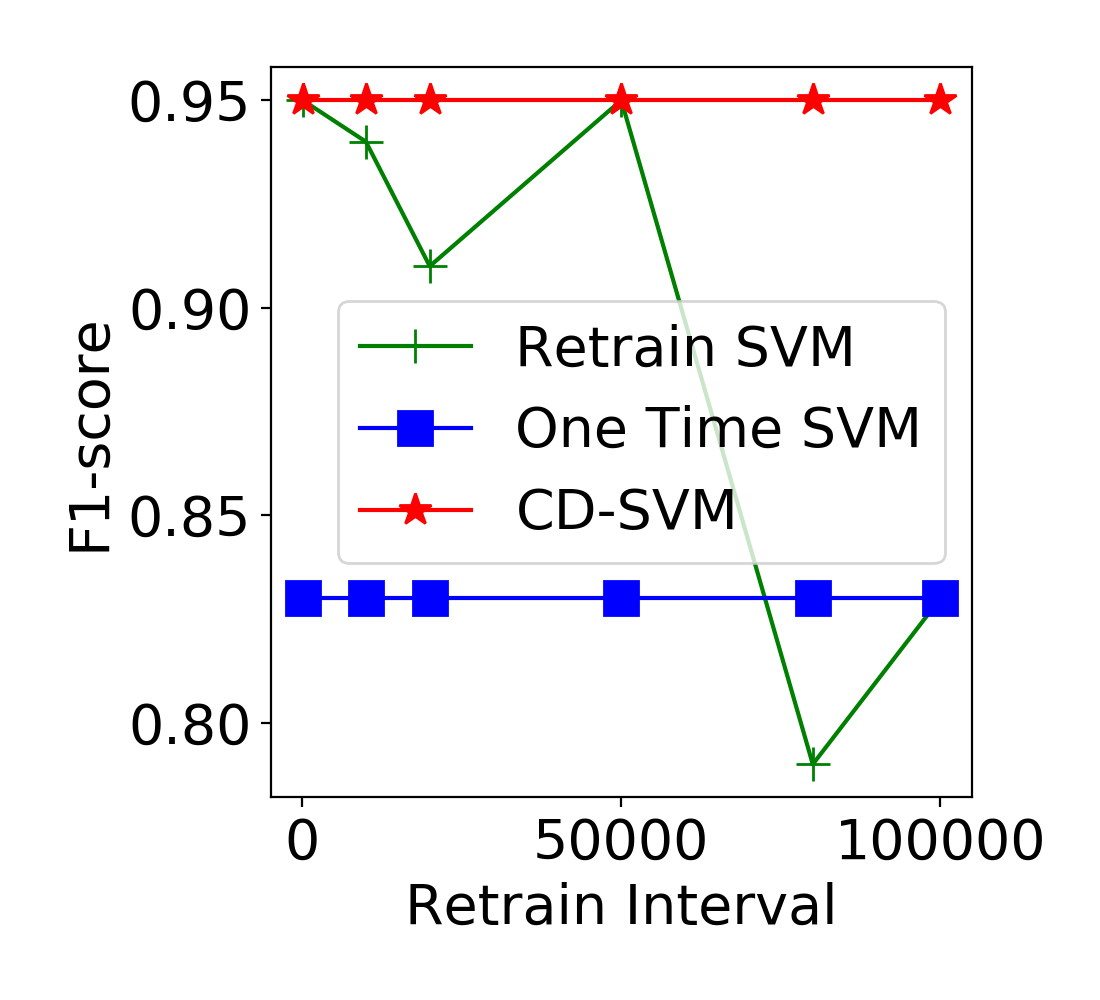

<IPython.core.display.Javascript object>


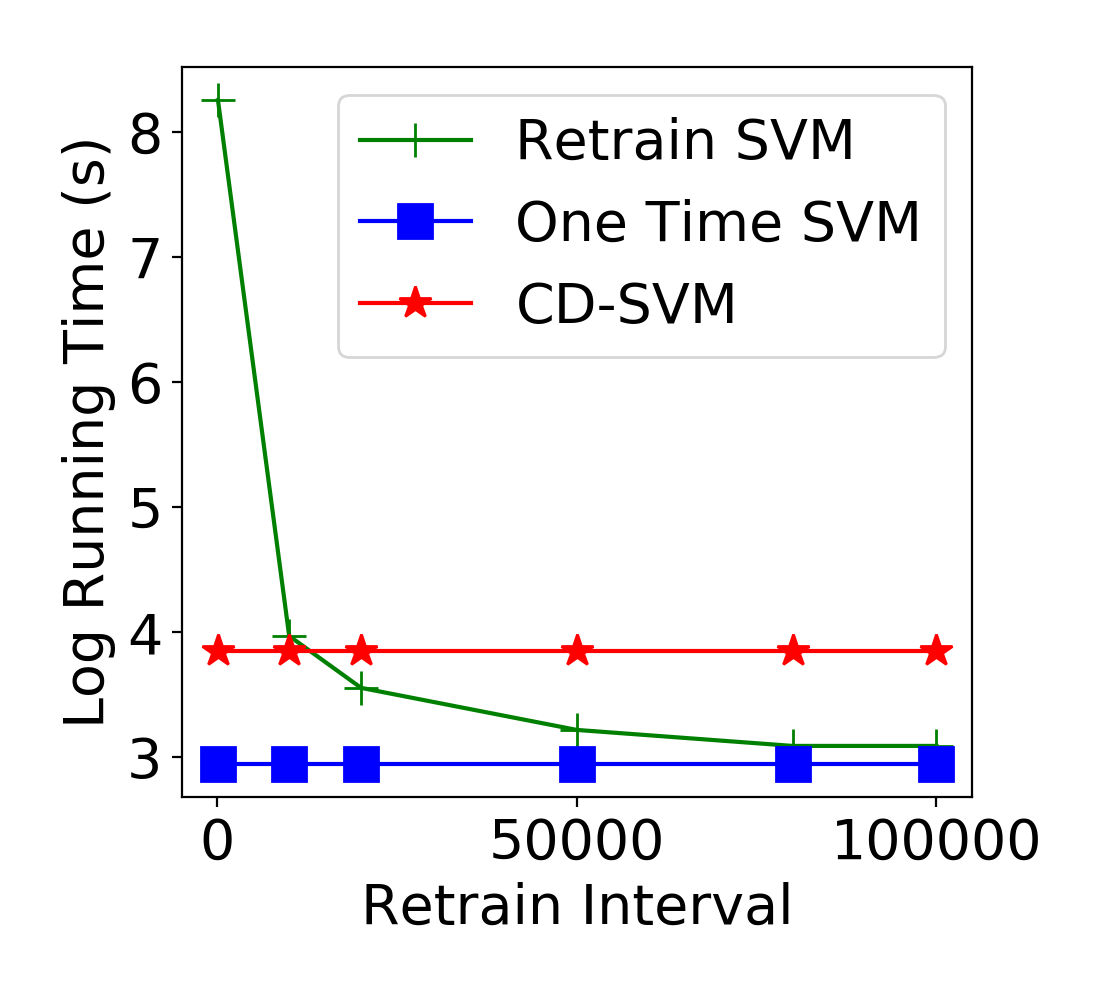

In [165]:
# Error Type: Gaussian
#Fc dataset
# F1-score
plt.figure(figsize=figure_size)
retrain_intervals = [100, 10000, 20000, 50000, 80000, 100000]
retrain_score_change_mean = [0.95, 0.92, 0.91, 0.95, 0.73,0.79]
one_time_change_mean = [0.04,0.04,0.04,0.04,0.04,0.04 ]
cd_change_mean = [0.95,0.95,0.95,0.95,0.95,0.95]
plt.plot(retrain_intervals, retrain_score_change_mean, color='g', marker='+',markersize=12, label="Retrain SVM")
plt.plot( retrain_intervals, one_time_change_mean,color='b', marker='s',markersize=12, label="One Time SVM")
plt.plot(retrain_intervals, cd_change_mean, color='r', marker='*',markersize=12, label="CD-SVM")
plt.legend()
plt.xlabel("Retrain Interval")
plt.ylabel("F1-score")
#plt.title("F1-score - Change Mean")
plt.show()
plt.tight_layout()
plt.savefig("svm_f1_score_change_mean.pdf")
#Running Time
retrain_score_runtime = np.log([3799, 53, 36, 24, 21, 21])
one_time_fc_runtime = np.log([17,17,17,17,17,17])
cd_fc_runtim = np.log([44, 44, 44, 44, 44, 44])
plt.figure(figsize=figure_size)
plt.plot(retrain_intervals, retrain_score_runtime, color='g', marker='+',markersize=12, label="Retrain SVM")
plt.plot( retrain_intervals, one_time_fc_runtime,color='b', marker='s',markersize=12, label="One Time SVM")
plt.plot(retrain_intervals, cd_fc_runtim, color='r', marker='*',markersize=12, label="CD-SVM")
plt.legend()
plt.xlabel("Retrain Interval")
plt.ylabel("Log Running Time (s)")
#plt.title("Log Running Time - Change Mean")
plt.show()
plt.tight_layout()
plt.savefig("svm_runtime_change_mean.pdf")


# Change STD
# F1-score
plt.figure(figsize=figure_size)
retrain_intervals = [100, 10000, 20000, 50000, 80000, 100000]
retrain_score_change_variance = [0.95, 0.94, 0.91, 0.94, 0.78, 0.81]
one_time_change_variance = [ 0.28,0.28, 0.28, 0.28,0.28,0.28]
cd_change_variance = [0.94, 0.94, 0.94, 0.94, 0.94, 0.94]
plt.plot(retrain_intervals, retrain_score_change_variance, color='g', marker='+',markersize=12, label="Retrain SVM")
plt.plot( retrain_intervals, one_time_change_variance,color='b', marker='s',markersize=12, label="One Time SVM")
plt.plot(retrain_intervals, cd_change_variance, color='r', marker='*',markersize=12, label="CD-SVM")
plt.legend()
plt.xlabel("Retrain Interval")
plt.ylabel("F1-score")
#plt.title("F1-score - Change STD")
plt.show()
plt.tight_layout()
plt.savefig("svm_f1_score_change_std.pdf")
#Running Time
retrain_score_change_variance_runtime = np.log([3813, 54, 36, 24, 22, 22])
one_time_change_variance_runtime = np.log([22, 22, 22, 22, 22, 22])
cd_change_variance_runtime = np.log([44, 44, 44, 44, 44, 44])
plt.figure(figsize=figure_size)
plt.plot(retrain_intervals, retrain_score_change_variance_runtime, color='g', marker='+',markersize=12, label="Retrain SVM")
plt.plot( retrain_intervals, one_time_change_variance_runtime,color='b', marker='s',markersize=12, label="One Time SVM")
plt.plot(retrain_intervals, cd_change_variance_runtime, color='r', marker='*',markersize=12, label="CD-SVM")
plt.legend()
plt.xlabel("Retrain Interval")
plt.ylabel("Log Running Time (s)")
#plt.title("Log Running Time - Change STD")
plt.show()
plt.tight_layout()
plt.savefig("svm_runtime_change_std.pdf")

# Change Correlation
# F1-score
plt.figure(figsize=figure_size)
retrain_intervals = [100, 10000, 20000, 50000, 80000, 100000]
retrain_score_change_correlation = [0.95, 0.94, 0.91, 0.95, 0.79, 0.83]
one_time_change_correlation = [ 0.83, 0.83, 0.83, 0.83, 0.83, 0.83]
cd_change_correlation = [0.95, 0.95, 0.95, 0.95, 0.95, 0.95]
plt.plot(retrain_intervals, retrain_score_change_correlation, color='g', marker='+',markersize=12, label="Retrain SVM")
plt.plot( retrain_intervals, one_time_change_correlation,color='b', marker='s',markersize=12, label="One Time SVM")
plt.plot(retrain_intervals, cd_change_correlation, color='r', marker='*',markersize=12, label="CD-SVM")
plt.legend()
plt.xlabel("Retrain Interval")
plt.ylabel("F1-score")
#plt.title("F1-score - Change Correlation")
plt.show()
plt.tight_layout()
plt.savefig("svm_f1_score_change_corr.pdf")
#Running Time
retrain_score_change_correlation_runtime = np.log([3850, 53, 35, 25, 22, 22])
one_time_change_correlation_runtime = np.log([19, 19, 19, 19, 19, 19])
cd_change_correlation_runtime = np.log([47, 47, 47, 47, 47, 47])
plt.figure(figsize=figure_size)
plt.plot(retrain_intervals, retrain_score_change_correlation_runtime, color='g', marker='+',markersize=12, label="Retrain SVM")
plt.plot( retrain_intervals, one_time_change_correlation_runtime,color='b', marker='s',markersize=12, label="One Time SVM")
plt.plot(retrain_intervals, cd_change_correlation_runtime, color='r', marker='*',markersize=12, label="CD-SVM")
plt.legend()
plt.xlabel("Retrain Interval")
plt.ylabel("Log Running Time (s)")
#plt.title("Log Running Time - Change Correlation")
plt.show()
plt.tight_layout()
plt.savefig("svm_runtime_change_corr.pdf")

In [11]:
def pca_outlier_detection2(pca,  train_data, outlier_rate, is_need_retrain, test_data, 
                           centroid, pca_type="normal", batch_size=100, count=0):
    
    dim = len(train_data[0])
    if pca == None or is_need_retrain == True:
        #compute pca
        if pca_type =="normal":
            pca = PCA(n_components=dim)
            pca.fit(train_data)
        elif pca_type =="incremental":
            if pca == None:
                pca = IncrementalPCA(n_components=dim)
                pca.fit(train_data)
            pca.partial_fit(test_data)
        
    eigenvalues = pca.explained_variance_ratio_
    pca_dim = dim
    # compute pca_dim
    #s = 0
    #for i in range(dim):
        #s += pca.explained_variance_ratio_[i]
        #if s >= 0.999:
            #pca_dim = i+1
            #break
   
     
    transformed_test_data = np.array(pca.transform(test_data))
    
    #if retrain, recompute centroid
    if is_need_retrain:
        centroid = np.array([np.sum(transformed_test_data[:,i], axis=0)/len(transformed_test_data) for i in range(dim)])
    else:
        # update centroid 
        new_centroid = np.array([np.sum(transformed_test_data[:,i], axis=0)/len(transformed_test_data) for i in range(dim)])
        centroid = (centroid * count + new_centroid*len(transformed_test_data))/(count +len(transformed_test_data) )
        
    scores = []
    
    
    
    for i in range(len(transformed_test_data)):
        score = 0
        for k in range(pca_dim):
            score += (transformed_test_data[i][k] - centroid[k])*(transformed_test_data[i][k] - centroid[k])/eigenvalues[k]
        scores.append(score)
   
    return scores,pca, centroid

def ground_truth_pca_outlier_detection(data, window_size, slide_size, outlier_rate, changes):
    count_window = 0
    start_idx = 0
    end_idx = 0
    pca = None
    centroid = None
    all_outliers = {}
    
    outliers = []
    scores_ = []
    global running_time
    num_retrain = 0
    for i in range(len(changes)):
        end_idx = changes[i]
        start_idx = 0
        if i > 0:
            start_idx = changes[i-1]
            
        max_bound = np.max(data[start_idx: end_idx], axis=0)
        min_bound = np.min(data[start_idx: end_idx], axis=0)
        normalized_train_data = normalize(data[start_idx: end_idx], max_bound, min_bound)
        
        scores_,pca, centroid = pca_outlier_detection2(pca, normalized_train_data, outlier_rate,
                                                                   True, normalized_train_data, centroid)
        
        num_out = int(outlier_rate* (end_idx - start_idx))
        outliers_ = heapq.nlargest(num_out, range(len(scores_)), scores_.__getitem__)
        #print("Num outliers = "+ str(len(outliers_)))
        #print(sorted(outliers_))
        
        outliers.extend([(x + start_idx) for x in outliers_ ])
        num_retrain +=1
    
    # The last distribution. 
    end_idx = len(data)
    start_idx = changes[-1]
    num_out = int(outlier_rate* (end_idx - start_idx))
    
    max_bound = np.max(data[start_idx: end_idx], axis=0)
    min_bound = np.min(data[start_idx: end_idx], axis=0)
    normalized_train_data = normalize(data[start_idx: end_idx], max_bound, min_bound)
    
    scores_,pca, centroid = pca_outlier_detection2(pca, normalized_train_data, outlier_rate,
                                                                   True, normalized_train_data, centroid)
    
    
    outliers_ = heapq.nlargest(num_out, range(len(scores_)), scores_.__getitem__)
    
    
    outliers.extend([(x + start_idx) for x in outliers_ ])
    
    
    # Extract outliers for each sliding windows. 
    start_idx = 0
    end_idx = start_idx + window_size
    
    while end_idx <= len(data):
        current_outliers = [x for x in outliers if x >= start_idx and x < end_idx]
        all_outliers[end_idx] = current_outliers
        end_idx += slide_size
        start_idx += slide_size
        
    
    return all_outliers, num_retrain

def retrain_pca_outlier_detection2(data, window_size, slide_size, outlier_rate, num_data_points, pca_type="normal"):
    count_window = 0
    start_idx = 0
    end_idx = start_idx + window_size
    pca = None
    centroid = None
    all_outliers = {}
    outliers = []
    scores_ = []
    num_out = int(window_size * outlier_rate)
    #global running_time
    running_time = 0 
    num_retrain = 0
    while end_idx < len(data):
        need_retrain = False
        if (end_idx - window_size)% num_data_points  == 0:
            need_retrain = True
        else:
            need_retrain = False
        
        
        
        
        
        
        if need_retrain:
            start_time = time.time()
            
            max_bound = np.max(data[start_idx: end_idx], axis=0)
            min_bound = np.min(data[start_idx: end_idx], axis=0)
            
            if pca_type=="normal":
                normalized_train_data = normalize(data[start_idx: end_idx], max_bound, min_bound)
            
                num_retrain +=1
            
                scores_,pca, centroid = pca_outlier_detection2(pca, normalized_train_data, outlier_rate,need_retrain,
                                                           normalized_train_data, centroid, pca_type=pca_type)
            elif pca_type=="incremental":
                normalized_train_data = normalize(data[start_idx: end_idx], max_bound, min_bound)
                normalized_test_data = normalize(data[(end_idx- slide_size): end_idx], max_bound, min_bound)
                num_retrain +=1
                if start_idx > 0:
                    new_slide_scores,pca, centroid = pca_outlier_detection2(pca, normalized_train_data, outlier_rate,need_retrain,
                                                           normalized_test_data, centroid, pca_type=pca_type)
                else:
                    new_slide_scores,pca, centroid = pca_outlier_detection2(pca, normalized_train_data, outlier_rate,need_retrain,
                                                           normalized_train_data, centroid, pca_type=pca_type)
                if len(scores_) > slide_size:
                    scores_ = scores_[slide_size:]
                scores_.extend(new_slide_scores)
            #print("Num scores_ = "+ str(len(scores_)))
            outliers_ = heapq.nlargest(num_out, range(len(scores_)), scores_.__getitem__)
            #print("Num out = "+ str(num_out))
            #print("Num outliers_ = "+ str(len(outliers_)))
            outliers = [(x + start_idx) for x in outliers_ ]
            running_time += time.time()- start_time
            
        else:
            start_time = time.time()
            normalized_test_data = normalize(data[(end_idx- slide_size): end_idx], max_bound, min_bound)
            
            
            new_slide_scores,pca, centroid = pca_outlier_detection2(pca, normalized_train_data, outlier_rate,need_retrain, 
                                                                    normalized_test_data, centroid,pca_type=pca_type)
            
            
            #merge with old scores
            scores_ = scores_[slide_size:]
            scores_.extend(new_slide_scores)
            
            
            outliers_ = heapq.nlargest(num_out, range(len(scores_)), scores_.__getitem__)
            outliers = [(x + start_idx) for x in outliers_ ]
            
            
            running_time += time.time()- start_time
        
        
        all_outliers[end_idx] = outliers
        
        #print("Num outlier = "+ str(len(outliers)))
        end_idx += slide_size
        start_idx += slide_size
        
        
        
        count_window  +=1 
    return all_outliers, num_retrain, running_time

def change_detection_pca_outlier_detection2(data, window_size,slide_size, outlier_rate, changes):
    count_window = 0
    start_idx = 0
    end_idx = start_idx + window_size
    pca = None
    centroid = None
    all_outliers = {}
    outliers = []
    num_out = int(window_size * outlier_rate)
    #global running_time
    running_time = 0
    num_retrain = 0
    count = 0 
    while end_idx <= len(data):
        
        need_retrain = False
        if count_window == 0 or end_idx in changes:
            need_retrain = True
        else:
            need_retrain = False
        
        
        
        
        
        if need_retrain and (end_idx+window_size) <= len(data):
            num_retrain +=1
            
            start_idx = end_idx - slide_size
            end_idx = start_idx + window_size - slide_size
            
            start_time = time.time()
            
            max_bound = np.max(data[start_idx: end_idx], axis=0)
            min_bound = np.min(data[start_idx: end_idx], axis=0)
            normalized_train_data = normalize(data[start_idx: end_idx], max_bound, min_bound)
            
            
            scores_,pca, centroid = pca_outlier_detection2(pca, normalized_train_data, outlier_rate,
                                                                   need_retrain, normalized_train_data, centroid )
            
            #print("Num out = "+ str(num_out))
            
            outliers_ = heapq.nlargest(num_out, range(len(scores_)), scores_.__getitem__)
            
            #outliers = [(x + start_idx) for x in outliers_ ]
            
            new_outliers = [(x + start_idx) for x in outliers_ ]
            #merge outliers
            if len(outliers) > 0 and end_idx > window_size:
                merged_outliers = []
                merged_outliers.extend(outliers)
                merged_outliers.extend(new_outliers)
                k = start_idx
                while(k <= end_idx):
                    all_outliers[k] = [idx for idx in merged_outliers if idx >= k-window_size and idx <k]
                    k += slide_size
                outliers = new_outliers
            else:
                outliers = new_outliers[:]
                all_outliers[end_idx] = outliers
            
            running_time += time.time()- start_time
            count = window_size
            
            
        else:
            start_time = time.time()
            count += slide_size
            #max_bound = np.max([max_bound, np.max(data[start_idx: end_idx], axis=0)], axis=0)
            #min_bound = np.min([min_bound, np.min(data[start_idx: end_idx], axis=0)], axis=0)
            normalized_test_data = normalize(data[(end_idx- slide_size): end_idx], max_bound, min_bound)
            
            
            new_slide_scores,pca, centroid = pca_outlier_detection2(pca, normalized_train_data, outlier_rate,
                                                                   need_retrain, normalized_test_data, centroid, count)
            
            
            #merge with old scores
            scores_ = scores_[slide_size:]
            scores_.extend(new_slide_scores)
            
            #print("Num out = "+ str(num_out))
            outliers_ = heapq.nlargest(num_out, range(len(scores_)), scores_.__getitem__)
            outliers = [(x + start_idx) for x in outliers_ ]
            #print("Num outlier = "+ str(len(outliers)))
            
            running_time += time.time()- start_time
        
        all_outliers[end_idx] = outliers
        
        
        end_idx += slide_size
        start_idx += slide_size
        
       
        
        count_window  +=1 
    return all_outliers, num_retrain, running_time


In [14]:
import time

for data_name in ["covtype.data", "ethylene.txt", "tao.txt", "household.txt"]:
    for error_type in ["gaussian", "double"]:
        print("----------------------------------------------")
        print("Data name = "+ str(data_name))
        print("Error type = "+ str(error_type))

        all_result = {}


        outlier_rate = 0.05
        window = 10000
        slide = 100


        mean = [0.01, 0.01, 0.01, 0.01, 0.01]
        cov = [[0.04, 0.02, 0.02, 0.02, 0.02],[0.02, 0.04, 0.02, 0.02, 0.02],[0.02, 0.02, 0.04, 0.02, 0.02],[0.02, 0.02, 0.02, 0.04, 0.02],[0.02, 0.02, 0.02, 0.02, 0.04]]
        groud_truth = [] 
        change_value = 0.1
        #change_type = "sudden"
        #change_param = "correlation"
        #d = generate_dataset("gauss",5, 25000,mean, cov, change_value, change_type, change_param, 50)
        no_change,groud_truth = sample_dataset_no_change(data_name, error_type, 25000, 50)
        #only for fc
        #no_change = no_change[:,0:10]
        #print(groud_truth)
        d = add_change_to_data(no_change, groud_truth, error_type)

        #print(groud_truth)
        #print(len(d[0]))


        ground_truth_outliers, num_retrain = ground_truth_pca_outlier_detection(d, window,slide, outlier_rate, groud_truth[0:(len(groud_truth)-1)])

        start_time = time.time()

        truncating_number = 4
        changes, running_time = change_detection_truncate(d, window, slide)
        print("Change detection time = "+ str(running_time))

        CD_outliers, num_retrain, running_time = change_detection_pca_outlier_detection2(d, window,slide, outlier_rate, changes)
        #running_time = time.time()-start_time
        print("Change_detection_PCA time = "+ str(running_time))
        print("Num Retrain = "+ str(num_retrain))
        print("change_detection+ PCA score")
        score = compute_f1_score(ground_truth_outliers, CD_outliers)
        print(score)
        all_result["CD-PCA"] = CD_outliers
        print("---------------------------------")

        for num_data_point_retrain in [ 5000, 10000, 20000, 50000, 1000000000]:
        #for num_data_point_retrain in [  50000]:

            retrain_outliers, num_retrain, running_time = retrain_pca_outlier_detection2(d, window, slide, outlier_rate, num_data_point_retrain,pca_type="normal")

            print("Retrain PCA, num_data_points="+str(num_data_point_retrain) +", time = "+ str(running_time))
            print("Num retrain = "+ str(num_retrain))
            print("Score")
            score = compute_f1_score(ground_truth_outliers, retrain_outliers)
            print(score)
            print("--------------------------------")
            all_result["Retrain PCA, t="+str(num_data_point_retrain)] = retrain_outliers


        # For incremental PCA
        num_data_point_retrain = slide
        incremental_outliers, num_retrain, running_time = retrain_pca_outlier_detection2(d, window, slide, outlier_rate, num_data_point_retrain, pca_type="incremental")

        print("Incremental  PCA,time = "+ str(running_time))
        print("Num retrain = "+ str(num_retrain))
        print("Score")
        score = compute_f1_score(ground_truth_outliers, incremental_outliers)
        print(score)
        print("--------------------------------")
        all_result["Incremental  PCA"] = incremental_outliers











----------------------------------------------
Data name = covtype.data
Error type = gaussian
Change detection time = 18.5199186802
Change_detection_PCA time = 53.7987704277
Num Retrain = 147
change_detection+ PCA score
(0.9033881581272295, 0.89842479828136335, 0.91160389884258652, 0.89358105564753998)
---------------------------------
Retrain PCA, num_data_points=5000, time = 156.692018509
Num retrain = 451
Score
(0.91036359637300424, 0.91032030903116956, 0.9110528324671987, 0.93520700144080837)
--------------------------------
Retrain PCA, num_data_points=10000, time = 140.036559343
Num retrain = 226
Score
(0.87709660883819807, 0.87706509191013227, 0.87775291634573327, 0.93520700144080837)
--------------------------------
Retrain PCA, num_data_points=20000, time = 113.877913475
Num retrain = 113
Score
(0.82321684429504072, 0.82310620726400852, 0.82391998906563502, 0.8468594409177892)
--------------------------------
Retrain PCA, num_data_points=50000, time = 105.024909496
Num retrain

Retrain PCA, num_data_points=20000, time = 115.275295734
Num retrain = 137
Score
(0.86435331444702834, 0.86441525765633598, 0.8648830408460072, 0.88208374170146864)
--------------------------------
Retrain PCA, num_data_points=50000, time = 107.333237171
Num retrain = 55
Score
(0.81453563656389261, 0.81466444159178442, 0.81496332470026644, 0.76579791658826579)
--------------------------------
Retrain PCA, num_data_points=1000000000, time = 103.139784336
Num retrain = 1
Score
(0.80677270618141372, 0.80680528149642405, 0.80729008607343555, 0.81284668130039572)
--------------------------------
Incremental  PCA,time = 680.129568577
Num retrain = 27265
Score
(0.88807872852644076, 0.8880898587933248, 0.88867313311833041, 0.8950031248677961)
--------------------------------
----------------------------------------------
Data name = household.txt
Error type = gaussian
Change detection time = 21.120244503
Change_detection_PCA time = 57.2781255245
Num Retrain = 162
change_detection+ PCA score
(0

<IPython.core.display.Javascript object>


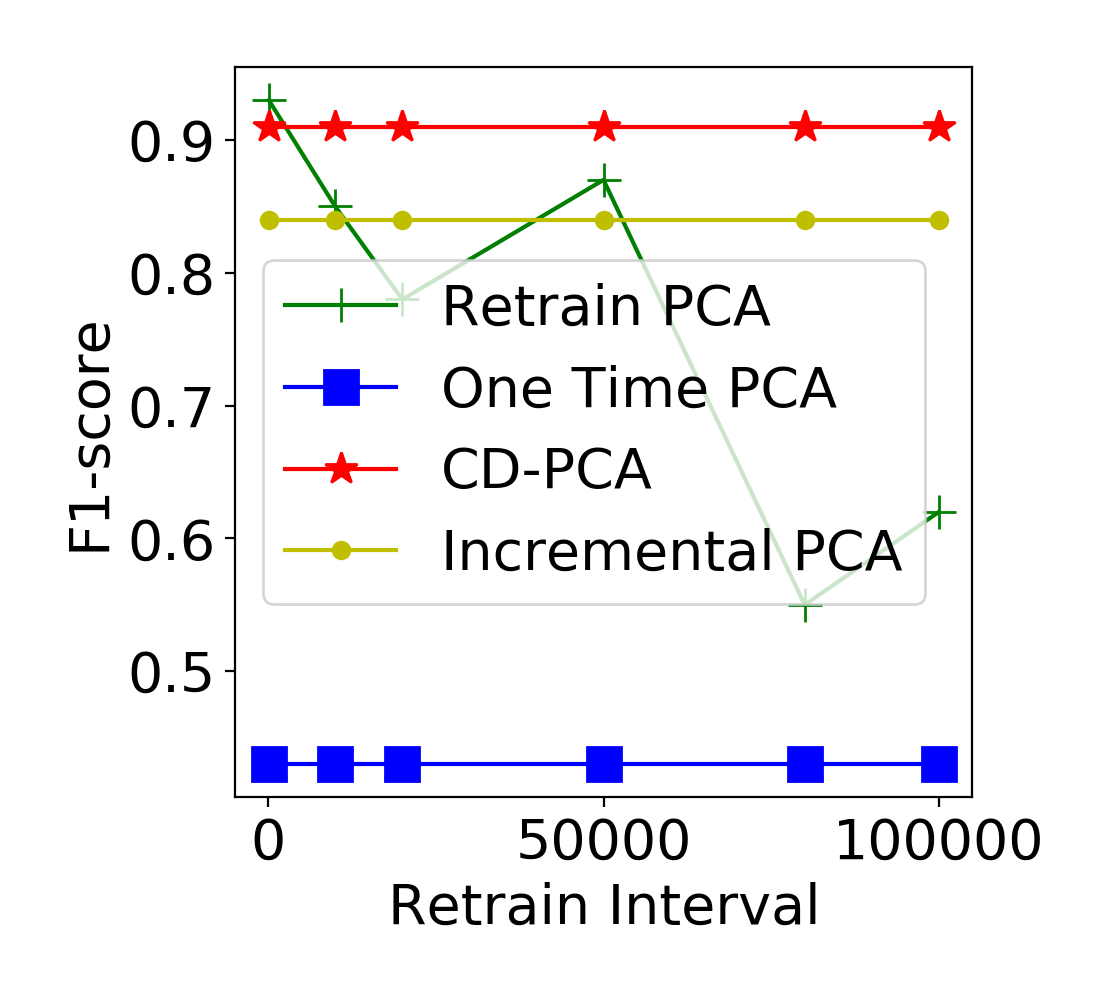

<IPython.core.display.Javascript object>


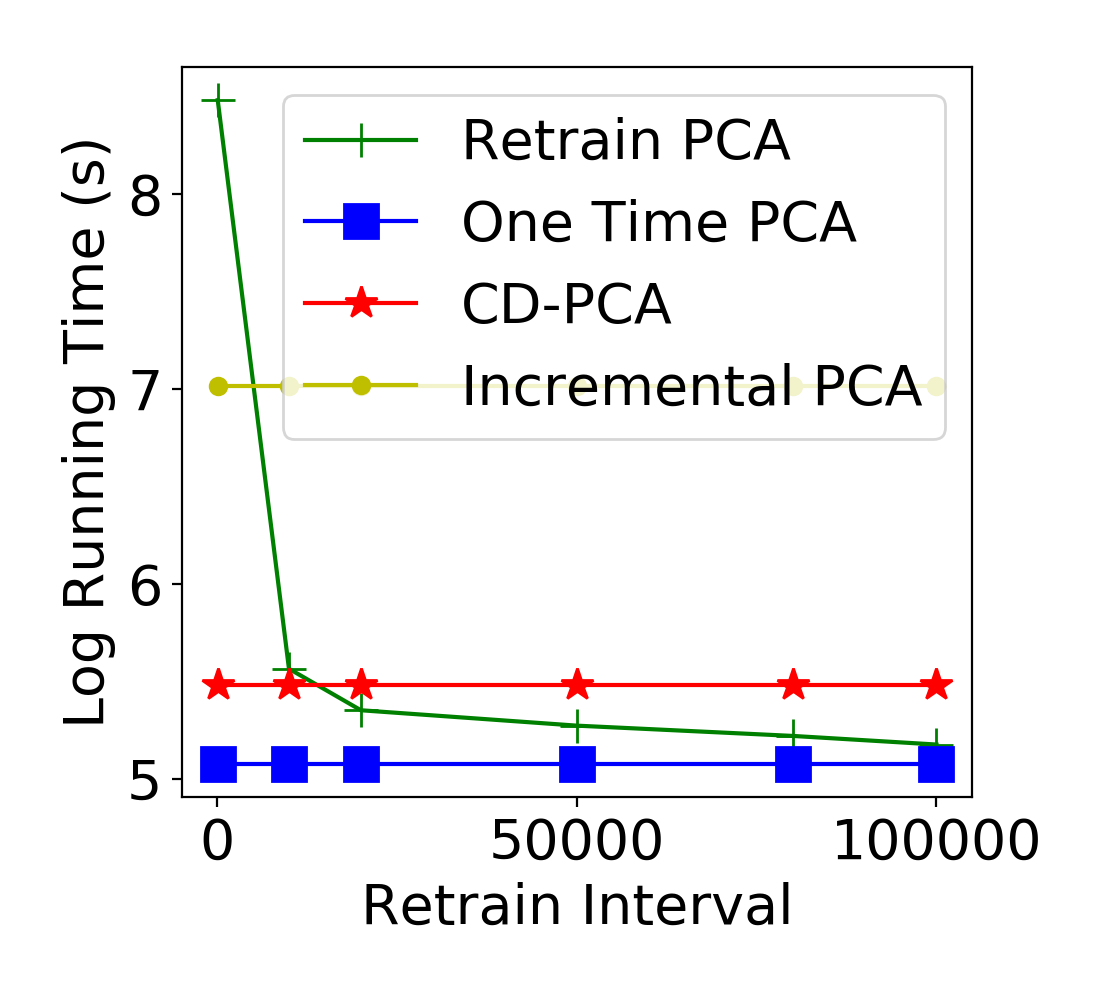

<IPython.core.display.Javascript object>


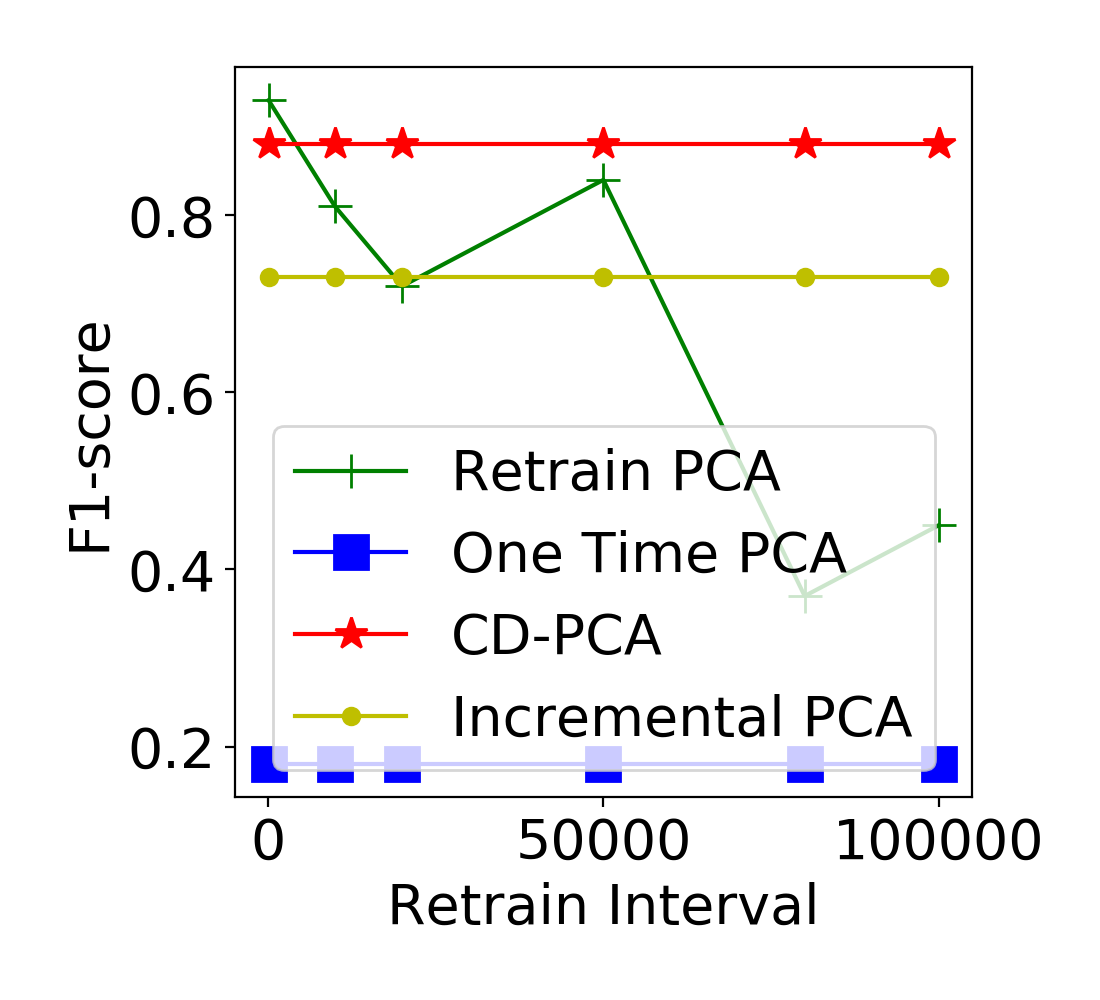

<IPython.core.display.Javascript object>


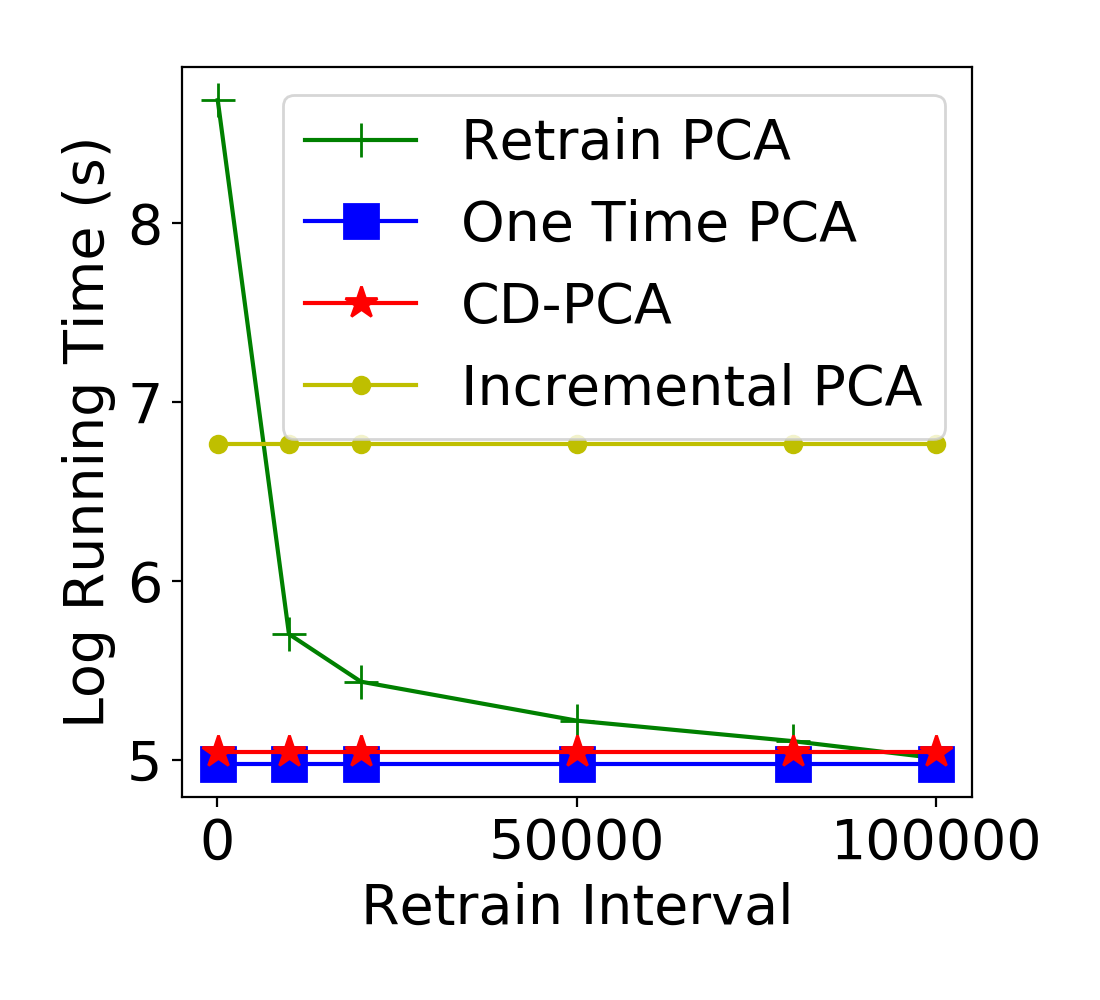

<IPython.core.display.Javascript object>


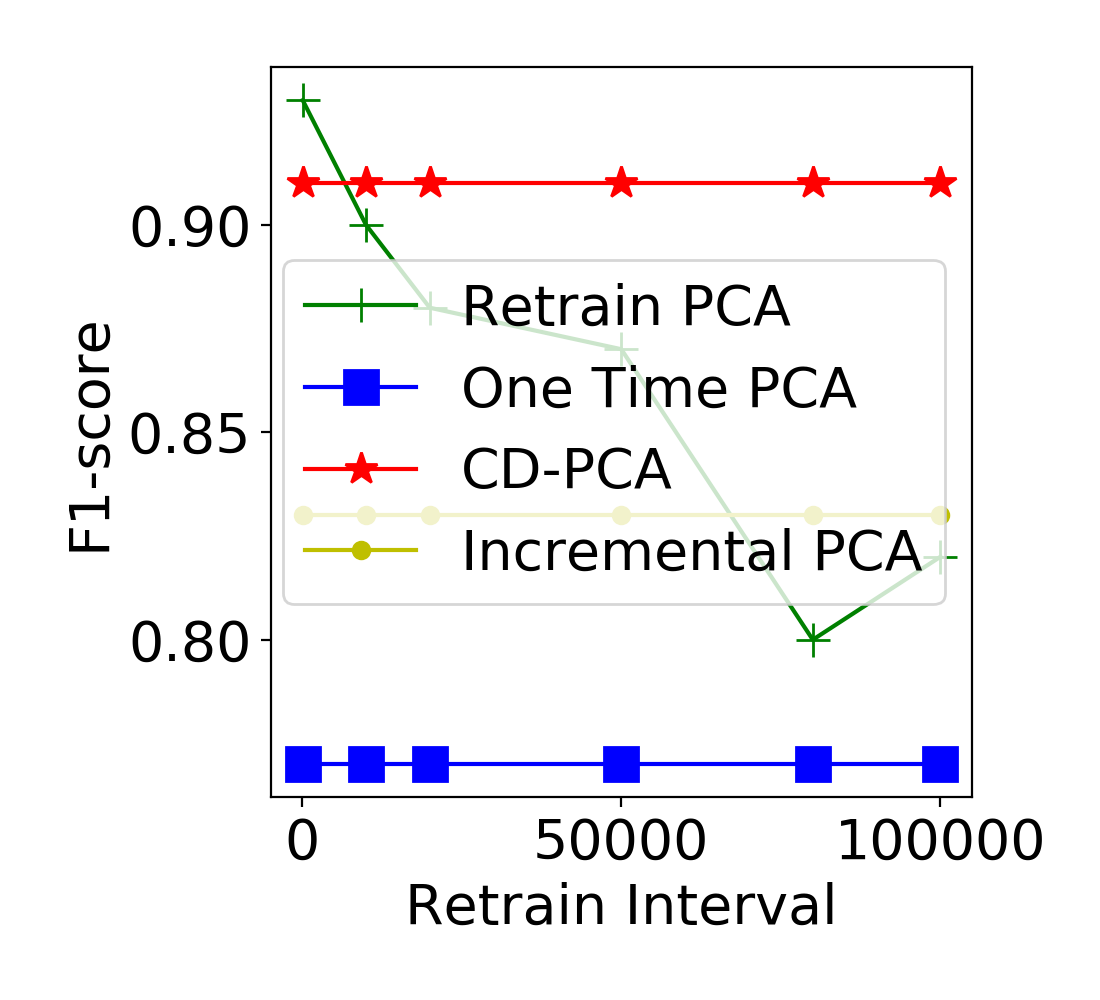

<IPython.core.display.Javascript object>


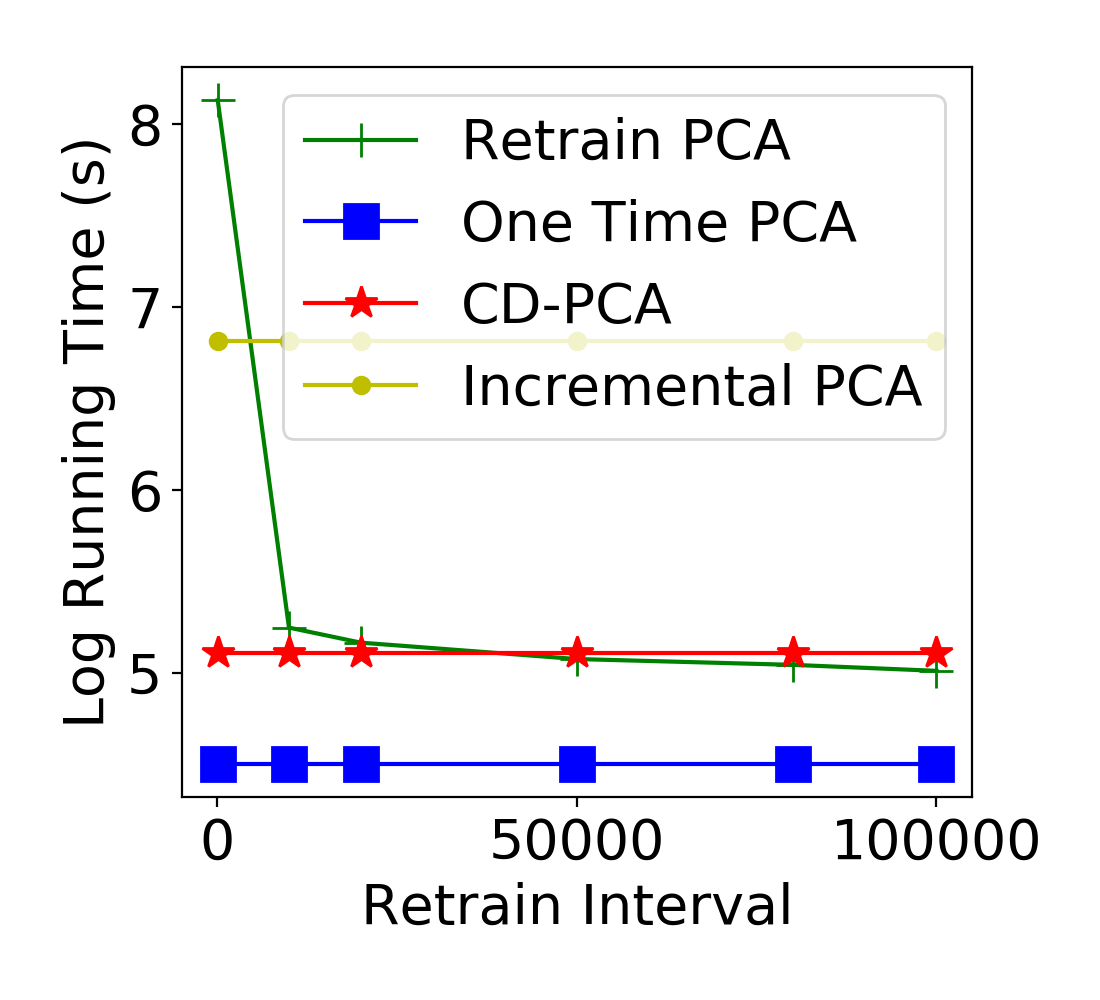

<IPython.core.display.Javascript object>


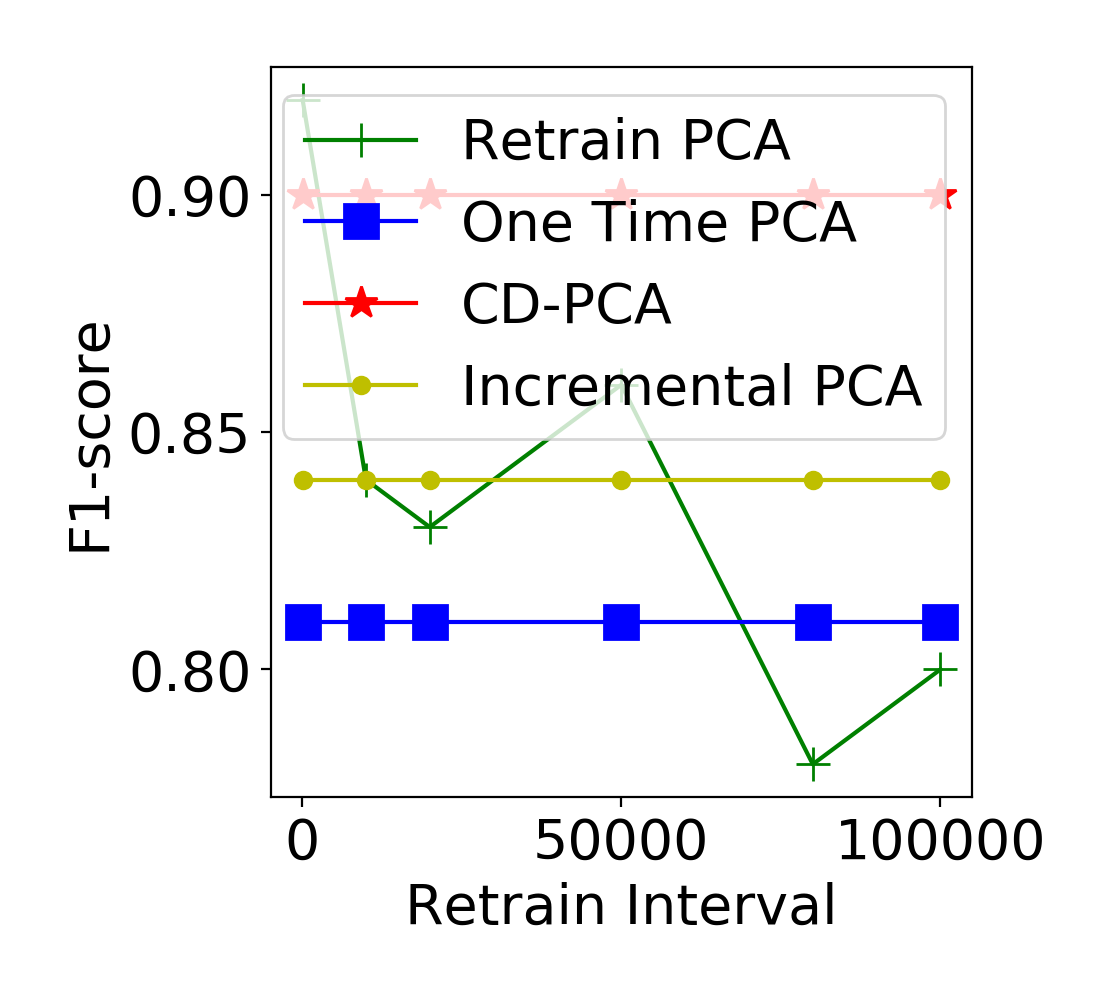

<IPython.core.display.Javascript object>


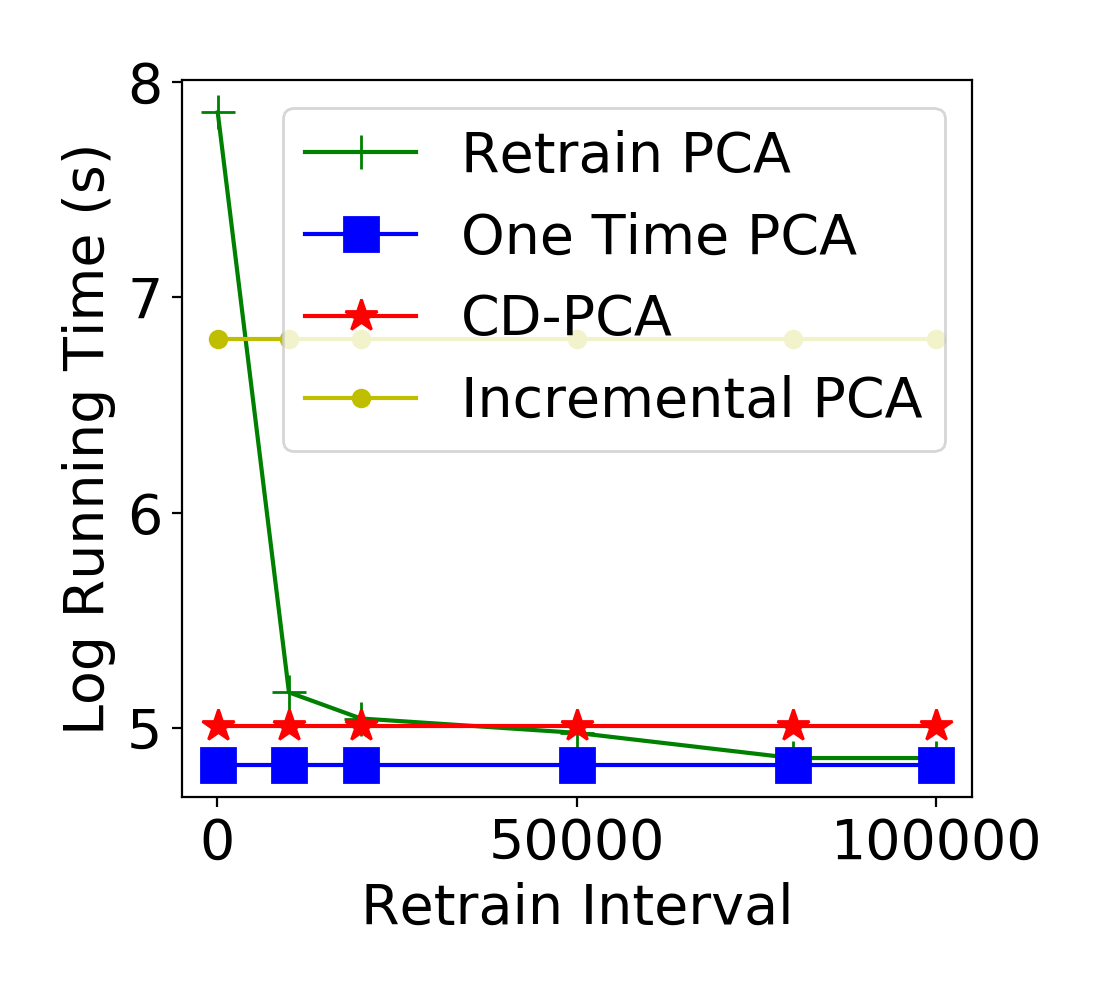

In [166]:
# Error Type: Double
#Fc dataset
# F1-score
plt.figure(figsize=figure_size)
retrain_intervals = [100, 10000, 20000, 50000, 80000, 100000]
retrain_score_fc = [0.93, 0.85, 0.78, 0.87, 0.55, 0.62]
one_time_fc = [0.43, 0.43, 0.43, 0.43, 0.43, 0.43]
cd_fc = [0.91, 0.91, 0.91, 0.91, 0.91, 0.91]
incremental_fc = [0.84, 0.84, 0.84, 0.84, 0.84, 0.84]
plt.plot(retrain_intervals, retrain_score_fc, color='g', marker='+',markersize=12, label="Retrain PCA")
plt.plot( retrain_intervals, one_time_fc,color='b', marker='s',markersize=12, label="One Time PCA")
plt.plot(retrain_intervals, cd_fc, color='r', marker='*',markersize=12, label="CD-PCA")
plt.plot(retrain_intervals, incremental_fc, color='y', marker='.',markersize=12, label="Incremental PCA")
plt.legend()
plt.xlabel("Retrain Interval")
plt.ylabel("F1-score")
#plt.title("F1-score - FC, Error Type = Double")
plt.show()
plt.tight_layout()
plt.savefig("pca_f1_score_fc_double.pdf")
#Running Time
retrain_score_runtime = np.log([4809, 261, 211, 195, 185, 177])
one_time_fc_runtime = np.log([160, 160, 160, 160, 160, 160])
cd_fc_runtime = np.log([240, 240, 240, 240, 240, 240])
incremental_fc_runtime = np.log([1114, 1114, 1114, 1114, 1114, 1114])
plt.figure(figsize=figure_size)
plt.plot(retrain_intervals, retrain_score_runtime, color='g', marker='+',markersize=12, label="Retrain PCA")
plt.plot( retrain_intervals, one_time_fc_runtime,color='b', marker='s',markersize=12, label="One Time PCA")
plt.plot(retrain_intervals, cd_fc_runtime, color='r', marker='*',markersize=12, label="CD-PCA")
plt.plot(retrain_intervals, incremental_fc_runtime, color='y', marker='.',markersize=12, label="Incremental PCA")

plt.legend()
plt.xlabel("Retrain Interval")
plt.ylabel("Log Running Time (s)")
#plt.title("Log Running Time - FC, Error Type = Double")
plt.show()
plt.tight_layout()
plt.savefig("pca_runtime_fc_double.pdf")
# Ethylen dataset
# F1-score

retrain_score_ethyl = [0.93, 0.81, 0.72, 0.84, 0.37, 0.45]
one_time_ethyl = [0.18,0.18,0.18,0.18,0.18,0.18]
cd_ethyl = [0.88,0.88,0.88,0.88,0.88,0.88]
incremental_ethyl = [0.73,0.73,0.73,0.73,0.73,0.73]
plt.figure(figsize=figure_size)
plt.plot(retrain_intervals, retrain_score_ethyl, color='g', marker='+',markersize=12, label="Retrain PCA")
plt.plot( retrain_intervals, one_time_ethyl,color='b', marker='s',markersize=12, label="One Time PCA")
plt.plot(retrain_intervals, cd_ethyl, color='r', marker='*',markersize=12, label="CD-PCA")
plt.plot(retrain_intervals, incremental_ethyl, color='y', marker='.',markersize=12, label="Incremental PCA")
plt.legend()
plt.xlabel("Retrain Interval")
plt.ylabel("F1-score")
#plt.title("F1-score - EM, Error Type = Double")
plt.show()
plt.tight_layout()
plt.savefig("pca_f1_score_em_double.pdf")
# Run time
retrain_score_runtime_ethyl = np.log([5923, 300, 230, 185, 165, 150])
one_time_ethyl_runtime = np.log([145, 145, 145, 145, 145, 145])
cd_ethyl_runtime = np.log([155, 155, 155, 155, 155, 155])
incremental_ethyl_runtime = np.log([870, 870, 870, 870, 870, 870])
plt.figure(figsize=figure_size)
plt.plot(retrain_intervals, retrain_score_runtime_ethyl, color='g', marker='+',markersize=12, label="Retrain PCA")
plt.plot( retrain_intervals, one_time_ethyl_runtime,color='b', marker='s',markersize=12, label="One Time PCA")
plt.plot(retrain_intervals, cd_ethyl_runtime, color='r', marker='*',markersize=12, label="CD-PCA")
plt.plot(retrain_intervals, incremental_ethyl_runtime, color='y', marker='.',markersize=12, label="Incremental PCA")
plt.legend()
plt.xlabel("Retrain Interval")
plt.ylabel("Log Running Time (s)")
#plt.title("Log Running Time - EM, Error Type = Double")
plt.show()
plt.tight_layout()
plt.savefig("pca_runtime_em_double.pdf")

# HPC dataset
# F1-score
retrain_score_hpc = [0.93, 0.9, 0.88, 0.87, 0.8, 0.82]
one_time_hpc = [0.77, 0.77, 0.77, 0.77, 0.77, 0.77]
cd_hpc = [0.91, 0.91, 0.91, 0.91, 0.91, 0.91]
incremental_hpc = [0.83, 0.83, 0.83, 0.83, 0.83, 0.83]
plt.figure(figsize=figure_size)
plt.plot(retrain_intervals, retrain_score_hpc, color='g', marker='+',markersize=12, label="Retrain PCA")
plt.plot( retrain_intervals, one_time_hpc,color='b', marker='s',markersize=12, label="One Time PCA")
plt.plot(retrain_intervals, cd_hpc, color='r', marker='*',markersize=12, label="CD-PCA")
plt.plot(retrain_intervals, incremental_hpc, color='y', marker='.',markersize=12, label="Incremental PCA")
plt.legend()
plt.xlabel("Retrain Interval")
plt.ylabel("F1-score")
#plt.title("F1-score - HPC, Error Type = Double")
plt.show()
plt.tight_layout()
plt.savefig("pca_f1_score_hpc_double.pdf")
# Run time
retrain_score_runtime_hpc = np.log([3400, 190, 175, 160, 155, 150])
one_time_hpc_runtime = np.log([90, 90, 90, 90, 90, 90])
cd_hpc_runtime = np.log([165, 165, 165, 165, 165, 165])
incremental_hpc_runtime = np.log([910, 910, 910, 910, 910, 910])
plt.figure(figsize=figure_size)
plt.plot(retrain_intervals, retrain_score_runtime_hpc, color='g', marker='+',markersize=12, label="Retrain PCA")
plt.plot( retrain_intervals, one_time_hpc_runtime,color='b', marker='s',markersize=12, label="One Time PCA")
plt.plot(retrain_intervals, cd_hpc_runtime, color='r', marker='*',markersize=12, label="CD-PCA")
plt.plot(retrain_intervals, incremental_hpc_runtime, color='y', marker='.',markersize=12, label="Incremental PCA")
plt.legend()
plt.xlabel("Retrain Interval")
plt.ylabel("Log Running Time (s)")
#plt.title("Log Running Time - HPC, Error Type = Double")
plt.show()
plt.tight_layout()
plt.savefig("pca_runtime_hpc_double.pdf")
# TAO dataset
retrain_score_tao = [0.92, 0.84, 0.83, 0.86, 0.78, 0.8]
one_time_tao = [0.81, 0.81, 0.81, 0.81, 0.81, 0.81]
cd_tao = [0.9, 0.9, 0.9, 0.9, 0.9, 0.9]
incremental_tao = [0.84, 0.84, 0.84, 0.84, 0.84, 0.84]
plt.figure(figsize=figure_size)
plt.plot(retrain_intervals, retrain_score_tao, color='g', marker='+',markersize=12, label="Retrain PCA")
plt.plot( retrain_intervals, one_time_tao, color='b', marker='s',markersize=12, label="One Time PCA")
plt.plot(retrain_intervals, cd_tao, color='r', marker='*',markersize=12, label="CD-PCA")
plt.plot(retrain_intervals, incremental_tao, color='y', marker='.',markersize=12, label="Incremental PCA")
plt.legend()
plt.xlabel("Retrain Interval")
plt.ylabel("F1-score")
#plt.title("F1-score - TAO, Error Type = Double")
plt.show()
plt.tight_layout()
plt.savefig("pca_f1_score_tao_double.pdf")
# Run time
retrain_score_runtime_tao = np.log([2586, 175, 155, 145, 129, 129])
one_time_tao_runtime = np.log([125, 125, 125, 125, 125, 125])
cd_tao_runtime = np.log([150, 150, 150, 150,150, 150])
incremental_tao_runtime = np.log([902, 902, 902, 902, 902, 902])
plt.figure(figsize=figure_size)
plt.plot(retrain_intervals, retrain_score_runtime_tao, color='g', marker='+',markersize=12, label="Retrain PCA")
plt.plot( retrain_intervals, one_time_tao_runtime,color='b', marker='s',markersize=12, label="One Time PCA")
plt.plot(retrain_intervals, cd_tao_runtime, color='r', marker='*',markersize=12, label="CD-PCA")
plt.plot(retrain_intervals, incremental_tao_runtime, color='y', marker='.',markersize=12, label="Incremental PCA")
plt.legend()
plt.xlabel("Retrain Interval")
plt.ylabel("Log Running Time (s)")
#plt.title("Log Running Time - TAO, Error Type = Double")
plt.show()
plt.tight_layout()
plt.savefig("pca_runtime_tao_double.pdf")



<IPython.core.display.Javascript object>


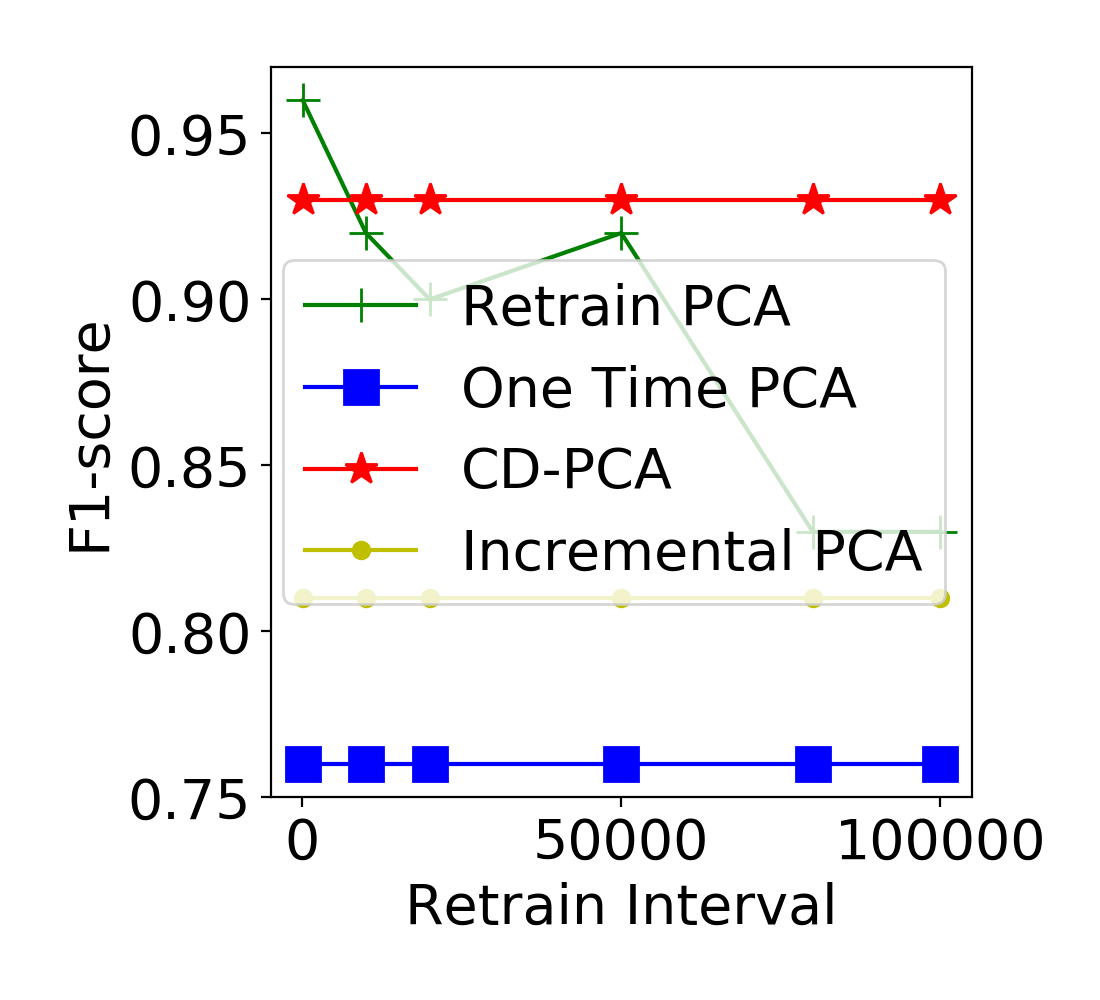

<IPython.core.display.Javascript object>


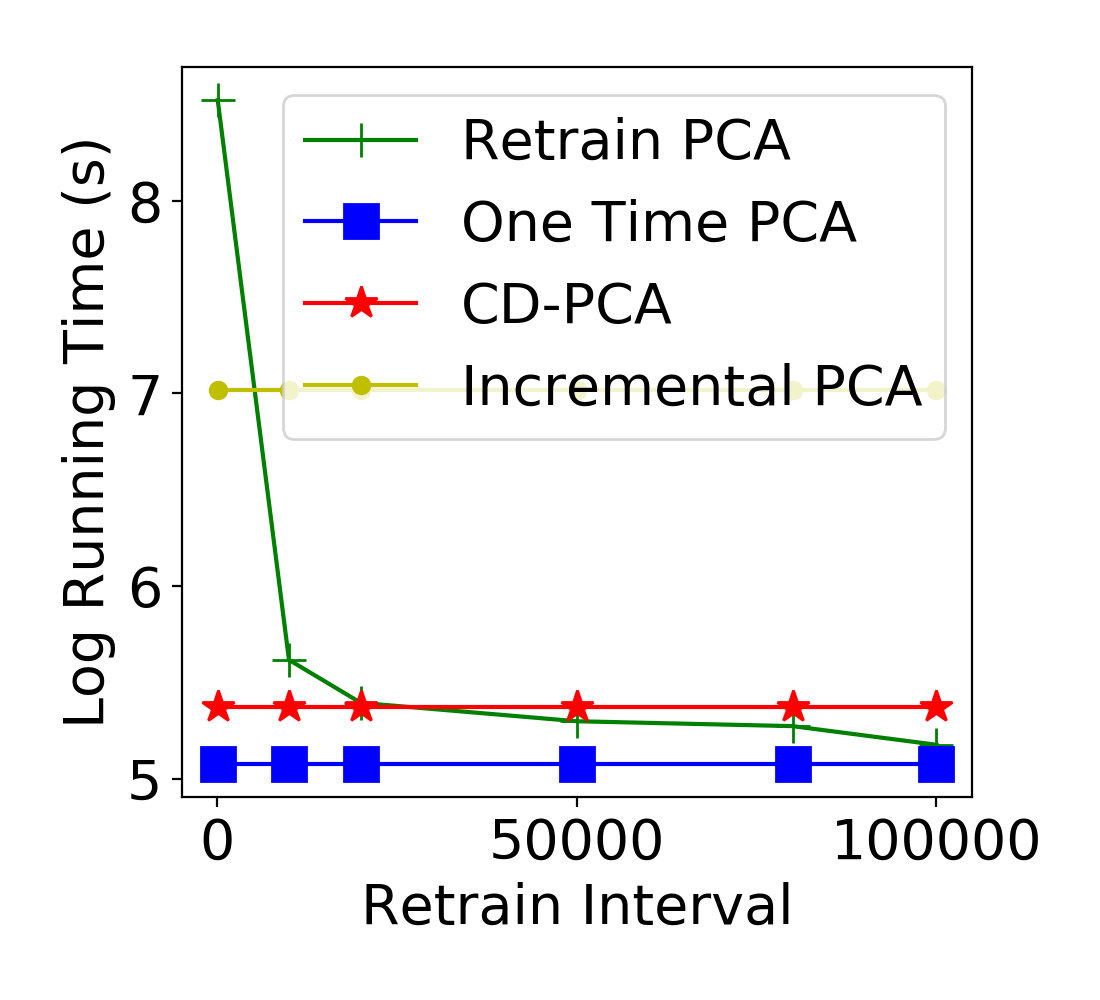

<IPython.core.display.Javascript object>


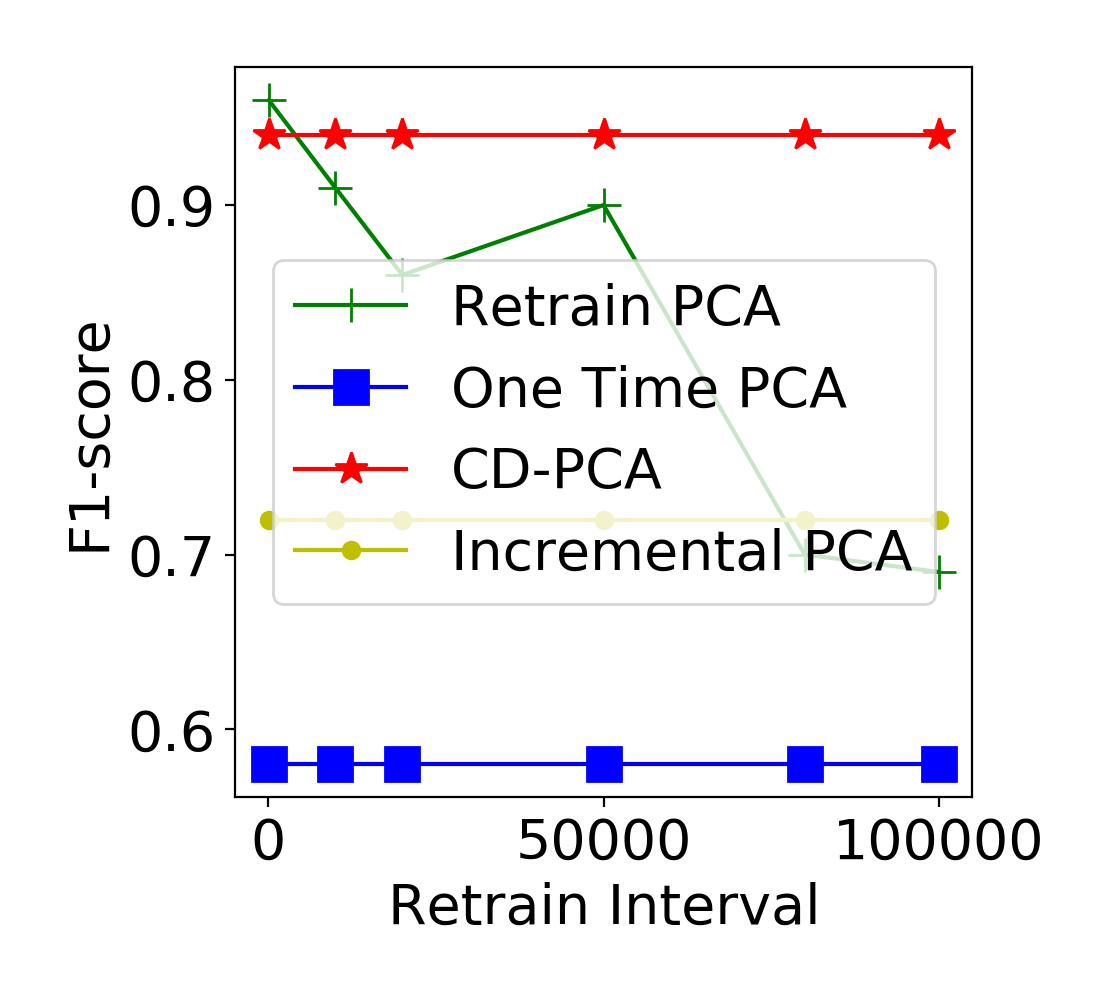

<IPython.core.display.Javascript object>


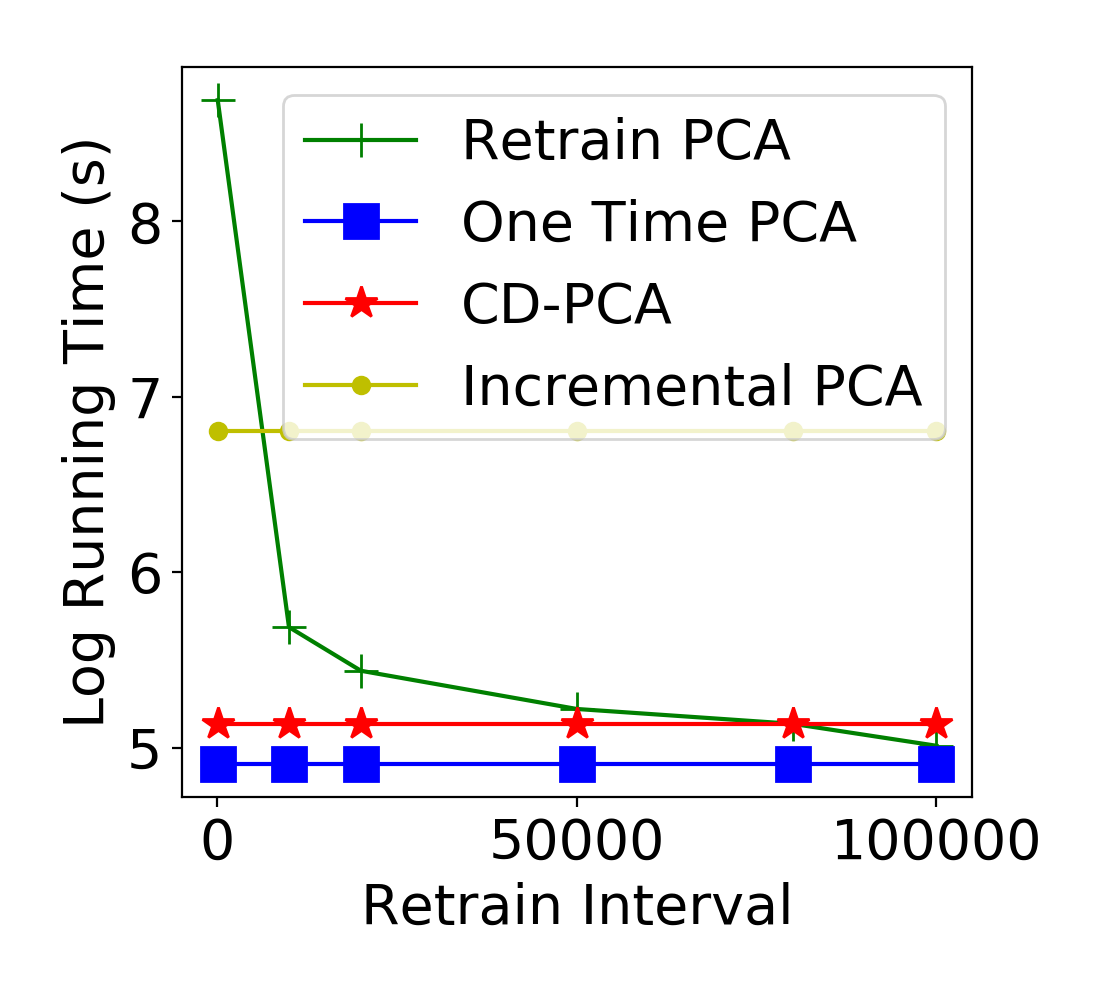

<IPython.core.display.Javascript object>


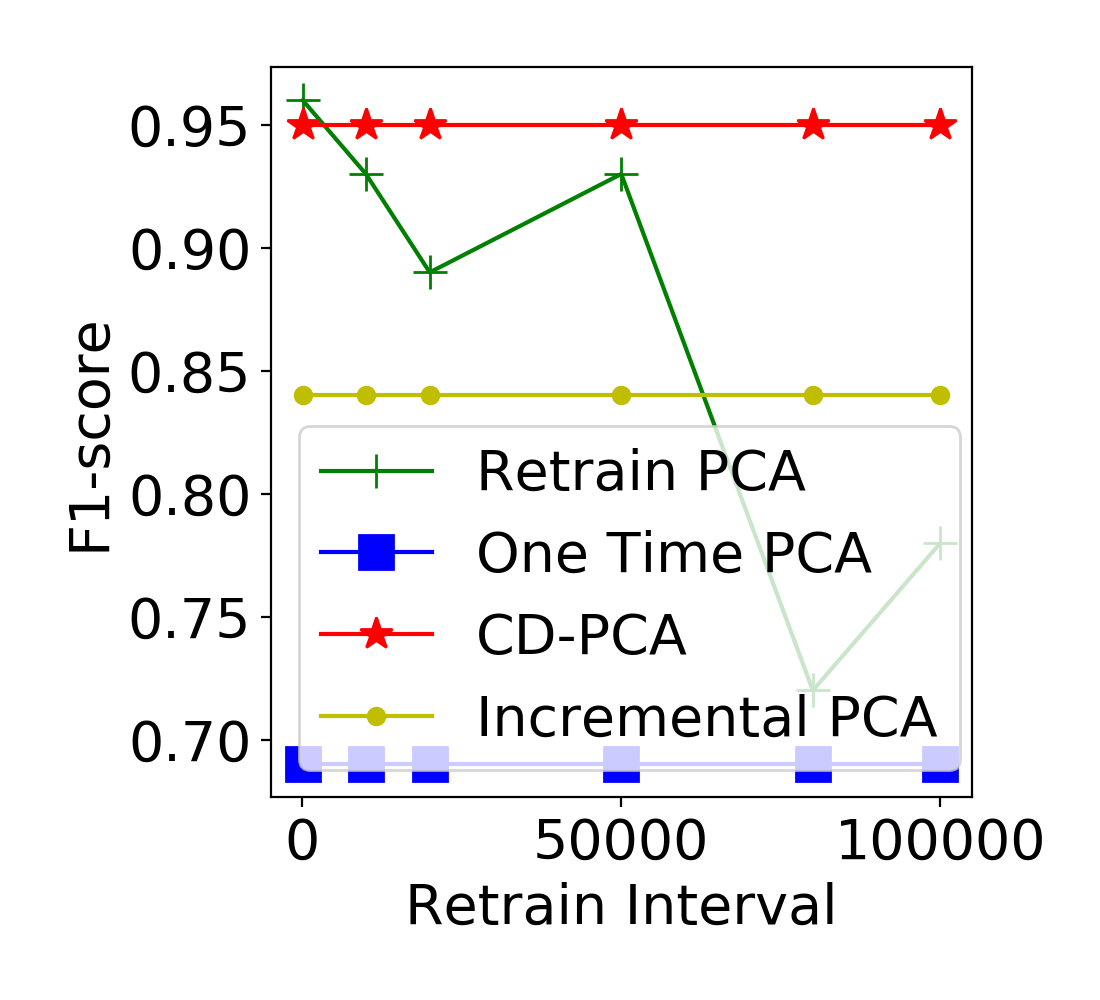

<IPython.core.display.Javascript object>


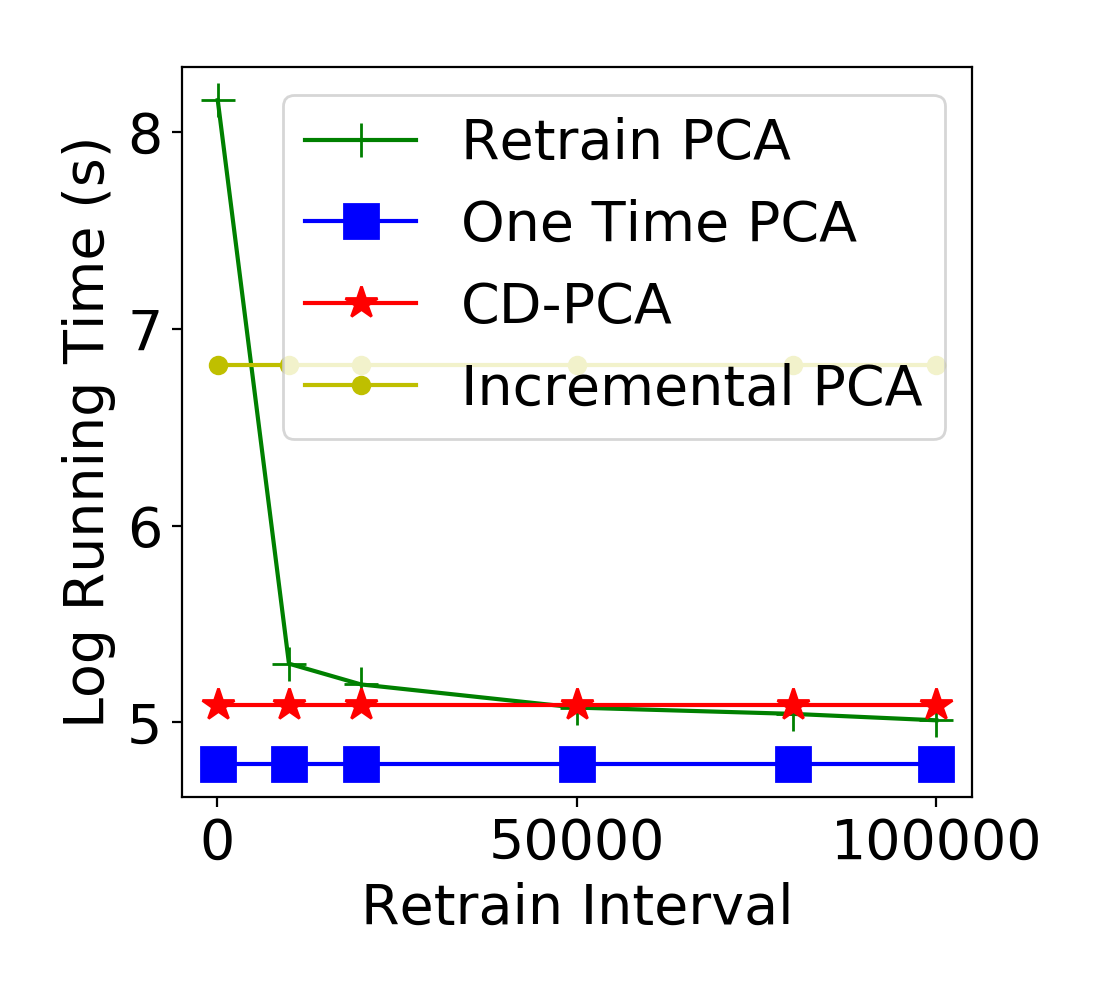

<IPython.core.display.Javascript object>


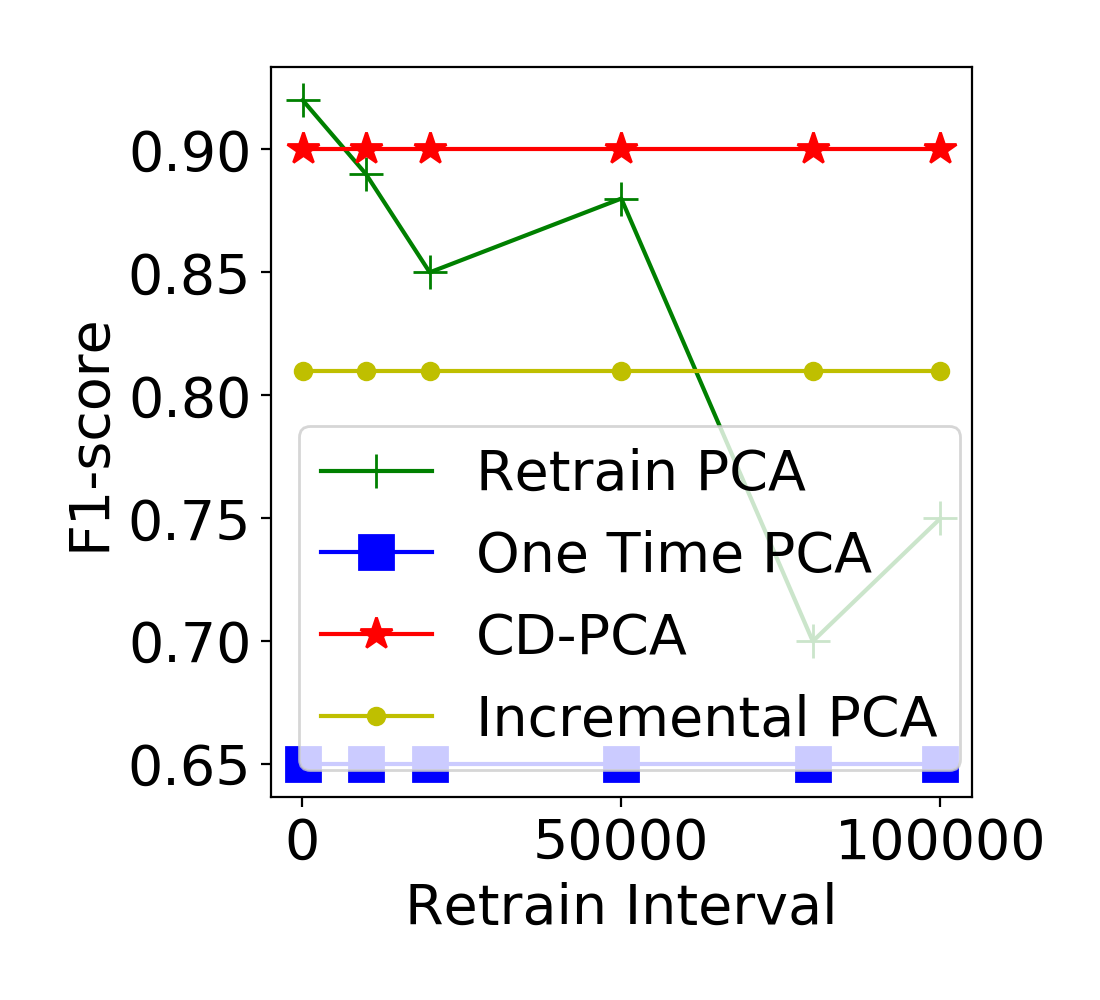

<IPython.core.display.Javascript object>


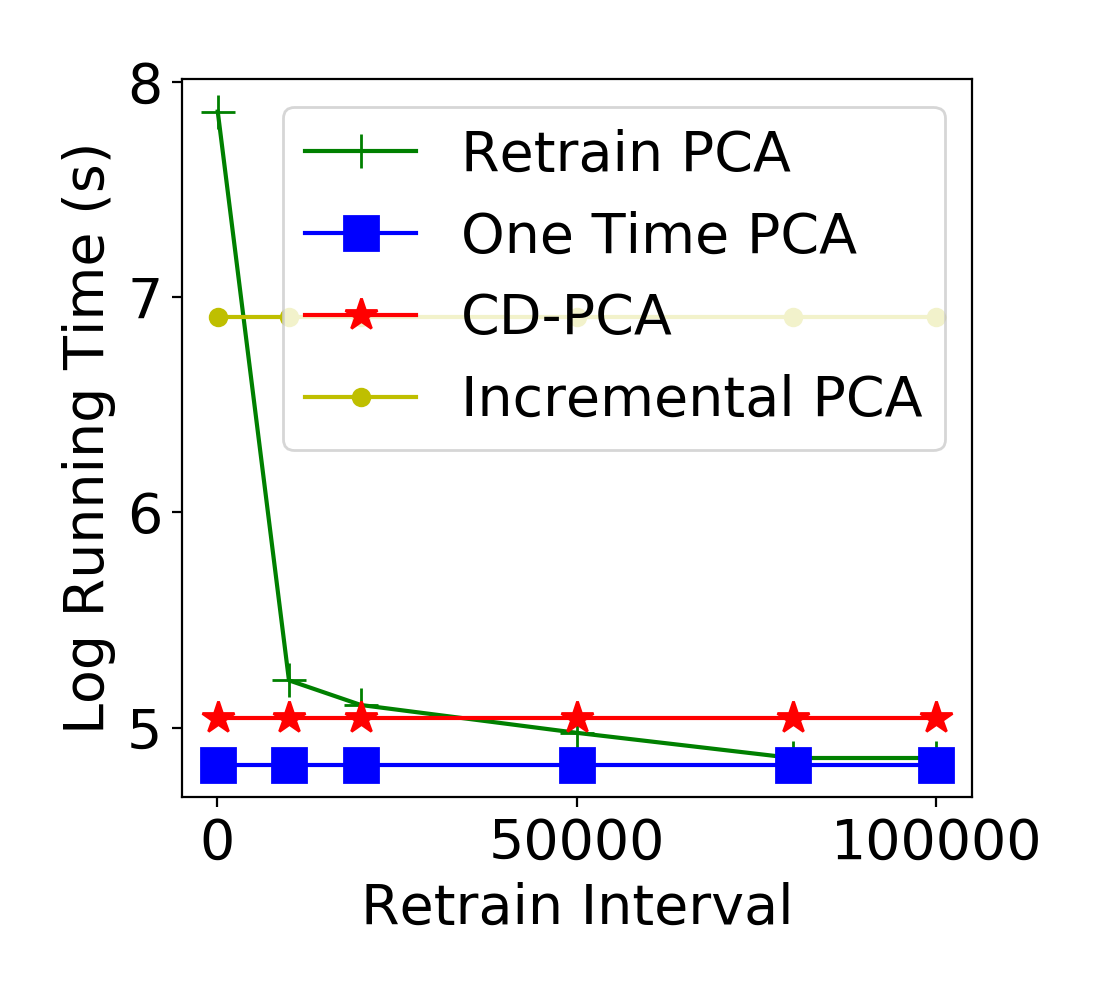

In [167]:
# Error Type: Gaussian
#Fc dataset
# F1-score
plt.figure(figsize=figure_size)
retrain_intervals = [100, 10000, 20000, 50000, 80000, 100000]
retrain_score_fc = [0.96, 0.92, 0.9, 0.92, 0.83, 0.83]
one_time_fc = [0.76, 0.76, 0.76, 0.76, 0.76, 0.76]
cd_fc = [0.93, 0.93, 0.93, 0.93, 0.93, 0.93]
incremental_fc = [0.81, 0.81, 0.81, 0.81, 0.81, 0.81]
plt.plot(retrain_intervals, retrain_score_fc, color='g', marker='+',markersize=12, label="Retrain PCA")
plt.plot( retrain_intervals, one_time_fc,color='b', marker='s',markersize=12, label="One Time PCA")
plt.plot(retrain_intervals, cd_fc, color='r', marker='*',markersize=12, label="CD-PCA")
plt.plot(retrain_intervals, incremental_fc, color='y', marker='.',markersize=12, label="Incremental PCA")
plt.legend()
plt.xlabel("Retrain Interval")
plt.ylabel("F1-score")
#plt.title("F1-score - FC, Error Type = Gaussian")
plt.show()
plt.tight_layout()
plt.savefig("pca_f1_score_fc_gaussian.pdf")
#Running Time
retrain_score_runtime = np.log([5023, 275, 220, 200, 195, 177])
one_time_fc_runtime = np.log([160, 160,160, 160,160, 160])
cd_fc_runtime = np.log([215, 215, 215, 215, 215, 215])
incremental_fc_runtime = np.log([1114, 1114, 1114, 1114, 1114, 1114])
plt.figure(figsize=figure_size)
plt.plot(retrain_intervals, retrain_score_runtime, color='g', marker='+',markersize=12, label="Retrain PCA")
plt.plot( retrain_intervals, one_time_fc_runtime,color='b', marker='s',markersize=12, label="One Time PCA")
plt.plot(retrain_intervals, cd_fc_runtime, color='r', marker='*',markersize=12, label="CD-PCA")
plt.plot(retrain_intervals, incremental_fc_runtime, color='y', marker='.',markersize=12, label="Incremental PCA")
plt.legend()
plt.xlabel("Retrain Interval")
plt.ylabel("Log Running Time (s)")
#plt.title("Log Running Time - FC, Error Type = Gaussian")
plt.show()
plt.tight_layout()
plt.savefig("pca_runtime_fc_gaussian.pdf")
# Ethylen dataset
# F1-score

retrain_score_ethyl = [0.96, 0.91, 0.86, 0.9, 0.7, 0.69]
one_time_ethyl = [0.58, 0.58, 0.58, 0.58, 0.58, 0.58]
cd_ethyl = [0.94, 0.94, 0.94, 0.94, 0.94, 0.94]
incremental_ethyl = [0.72, 0.72, 0.72, 0.72, 0.72, 0.72]
plt.figure(figsize=figure_size)
plt.plot(retrain_intervals, retrain_score_ethyl, color='g', marker='+',markersize=12, label="Retrain PCA")
plt.plot( retrain_intervals, one_time_ethyl,color='b', marker='s',markersize=12, label="One Time PCA")
plt.plot(retrain_intervals, cd_ethyl, color='r', marker='*',markersize=12, label="CD-PCA")
plt.plot(retrain_intervals, incremental_ethyl, color='y', marker='.',markersize=12, label="Incremental PCA")

plt.legend()
plt.xlabel("Retrain Interval")
plt.ylabel("F1-score")
#plt.title("F1-score - Ethylen, Error Type = Gaussian")
plt.show()
plt.tight_layout()
plt.savefig("pca_f1_score_em_gaussian.pdf")
# Run time
retrain_score_runtime_ethyl = np.log([5945, 295, 230, 185, 170, 150])
one_time_ethyl_runtime = np.log([135, 135, 135, 135, 135, 135])
cd_ethyl_runtim = np.log([170, 170, 170, 170, 170, 170])
incremental_ethyl_runtime = np.log([900, 900, 900,900, 900, 900])
plt.figure(figsize=figure_size)
plt.plot(retrain_intervals, retrain_score_runtime_ethyl, color='g', marker='+',markersize=12, label="Retrain PCA")
plt.plot( retrain_intervals, one_time_ethyl_runtime,color='b', marker='s',markersize=12, label="One Time PCA")
plt.plot(retrain_intervals, cd_ethyl_runtim, color='r', marker='*',markersize=12, label="CD-PCA")
plt.plot(retrain_intervals, incremental_ethyl_runtime, color='y', marker='.',markersize=12, label="Incremental PCA")


plt.legend()
plt.xlabel("Retrain Interval")
plt.ylabel("Log Running Time (s)")
#plt.title("Log Running Time - Ethylen, Error Type = Gaussian")
plt.show()
plt.tight_layout()
plt.savefig("pca_runtime_em_gaussian.pdf")

# HPC dataset
# F1-score
retrain_score_hpc = [0.96, 0.93, 0.89, 0.93, 0.72, 0.78]
one_time_hpc = [0.69, 0.69, 0.69, 0.69, 0.69, 0.69]
cd_hpc = [0.95, 0.95, 0.95, 0.95, 0.95, 0.95]
incremental_hpc = [0.84, 0.84, 0.84, 0.84, 0.84, 0.84]
plt.figure(figsize=figure_size)
plt.plot(retrain_intervals, retrain_score_hpc, color='g', marker='+',markersize=12, label="Retrain PCA")
plt.plot( retrain_intervals, one_time_hpc,color='b', marker='s',markersize=12, label="One Time PCA")
plt.plot(retrain_intervals, cd_hpc, color='r', marker='*',markersize=12, label="CD-PCA")
plt.plot(retrain_intervals, incremental_hpc, color='y', marker='.',markersize=12, label="Incremental PCA")

plt.legend()
plt.xlabel("Retrain Interval")
plt.ylabel("F1-score")
#plt.title("F1-score - HPC, Error Type = Gaussian")
plt.show()
plt.tight_layout()
plt.savefig("pca_f1_score_hpc_gaussian.pdf")
# Run time
retrain_score_runtime_hpc = np.log([3500, 200, 180, 160, 155, 150])
one_time_hpc_runtime = np.log([120, 120, 120, 120, 120, 120])
cd_hpc_runtime = np.log([162, 162, 162, 162, 162, 162])
incremental_hpc_runtime = np.log([910, 910, 910, 910, 910, 910])
plt.figure(figsize=figure_size)
plt.plot(retrain_intervals, retrain_score_runtime_hpc, color='g', marker='+',markersize=12, label="Retrain PCA")
plt.plot( retrain_intervals, one_time_hpc_runtime,color='b', marker='s',markersize=12, label="One Time PCA")
plt.plot(retrain_intervals, cd_hpc_runtime, color='r', marker='*',markersize=12, label="CD-PCA")
plt.plot(retrain_intervals, incremental_hpc_runtime, color='y', marker='.',markersize=12, label="Incremental PCA")
plt.legend()
plt.xlabel("Retrain Interval")
plt.ylabel("Log Running Time (s)")
#plt.title("Log Running Time - HPC, Error Type = Gaussian")
plt.show()
plt.tight_layout()
plt.savefig("pca_runtime_hpc_gaussian.pdf")
# TAO dataset
retrain_score_tao = [0.92, 0.89, 0.85, 0.88, 0.7, 0.75]
one_time_tao = [0.65, 0.65, 0.65, 0.65, 0.65, 0.65]
cd_tao = [0.9, 0.9, 0.9, 0.9, 0.9, 0.9]
incremental_tao = [0.81, 0.81, 0.81, 0.81, 0.81, 0.81]
plt.figure(figsize=figure_size)
plt.plot(retrain_intervals, retrain_score_tao, color='g', marker='+',markersize=12, label="Retrain PCA")
plt.plot( retrain_intervals, one_time_tao, color='b', marker='s',markersize=12, label="One Time PCA")
plt.plot(retrain_intervals, cd_tao, color='r', marker='*',markersize=12, label="CD-PCA")
plt.plot(retrain_intervals, incremental_tao, color='y', marker='.',markersize=12, label="Incremental PCA")

plt.legend()
plt.xlabel("Retrain Interval")
plt.ylabel("F1-score")
#plt.title("F1-score - TAO, Error Type = Gaussian")
plt.show()
plt.tight_layout()
plt.savefig("pca_f1_score_tao_gaussian.pdf")
# Run time
retrain_score_runtime_tao = np.log([2596, 185, 165, 145, 129, 129])
one_time_tao_runtime = np.log([125, 125, 125, 125, 125, 125])
cd_tao_runtime = np.log([155, 155, 155, 155, 155, 155])
incremental_tao_runtime = np.log([1000, 1000, 1000, 1000, 1000, 1000])
plt.figure(figsize=figure_size)
plt.plot(retrain_intervals, retrain_score_runtime_tao, color='g', marker='+',markersize=12, label="Retrain PCA")
plt.plot( retrain_intervals, one_time_tao_runtime,color='b', marker='s',markersize=12, label="One Time PCA")
plt.plot(retrain_intervals, cd_tao_runtime, color='r', marker='*',markersize=12, label="CD-PCA")
plt.plot(retrain_intervals, incremental_tao_runtime, color='y', marker='.',markersize=12, label="Incremental PCA")


plt.legend()
plt.xlabel("Retrain Interval")
plt.ylabel("Log Running Time (s)")
#plt.title("Log Running Time - TAO, Error Type = Gaussian")
plt.show()
plt.tight_layout()

plt.savefig("pca_runtime_tao_gaussian.pdf")

<IPython.core.display.Javascript object>


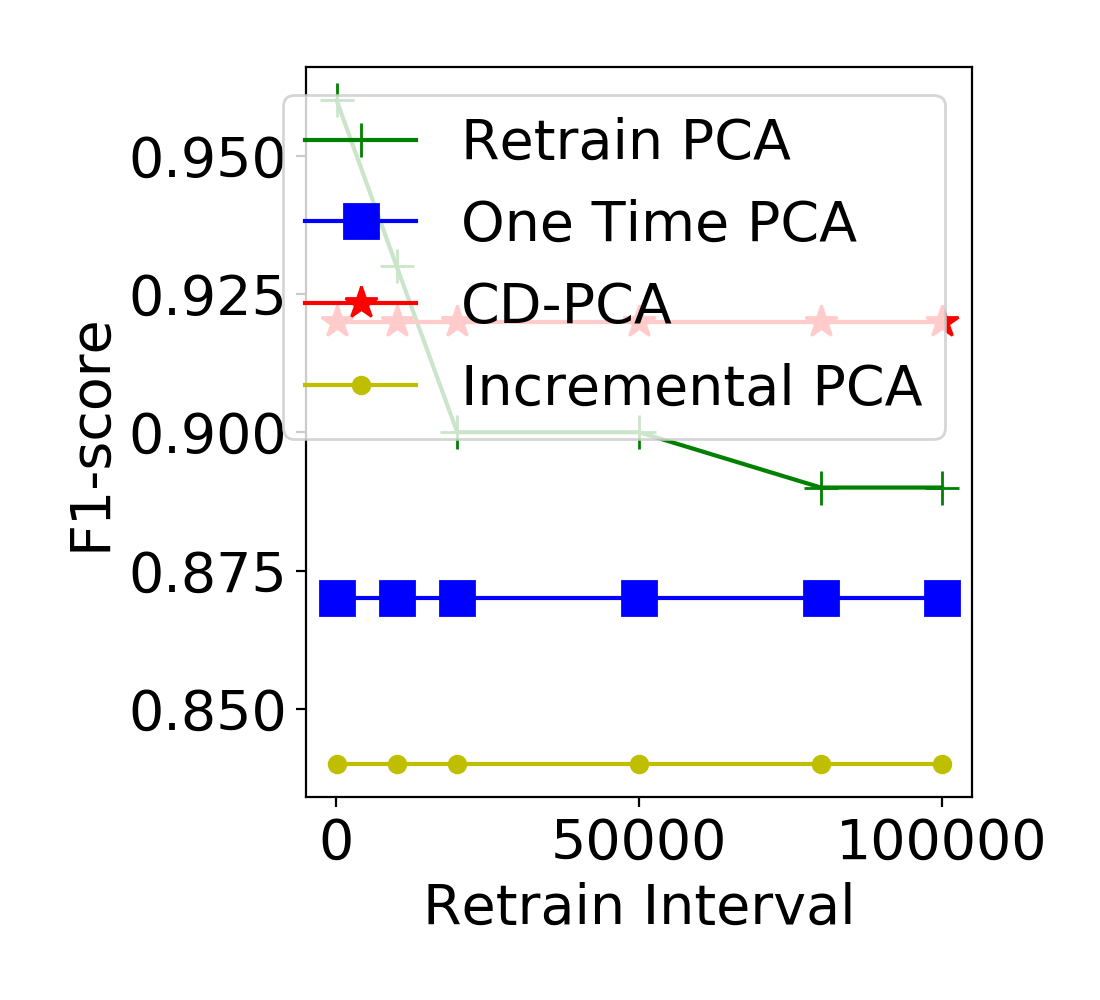

<IPython.core.display.Javascript object>


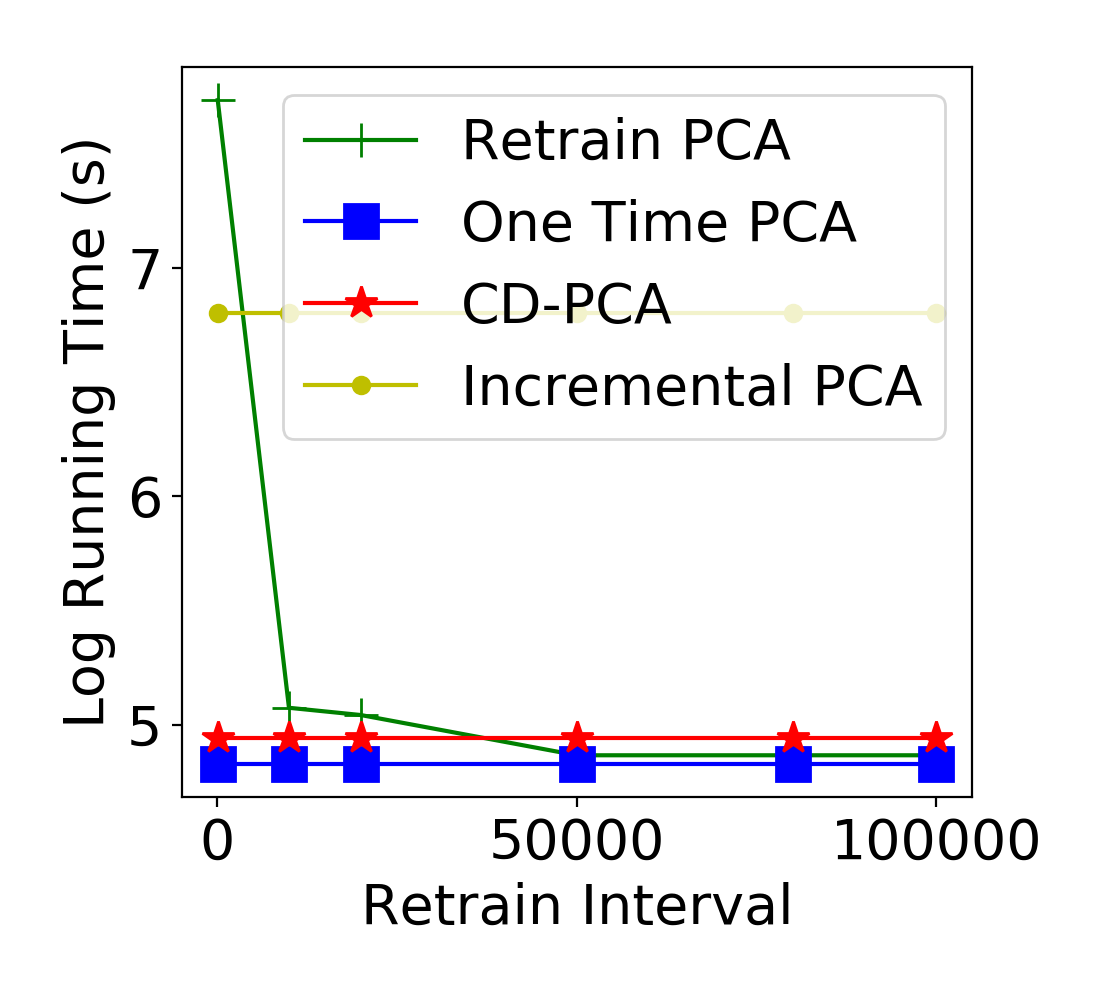

<IPython.core.display.Javascript object>


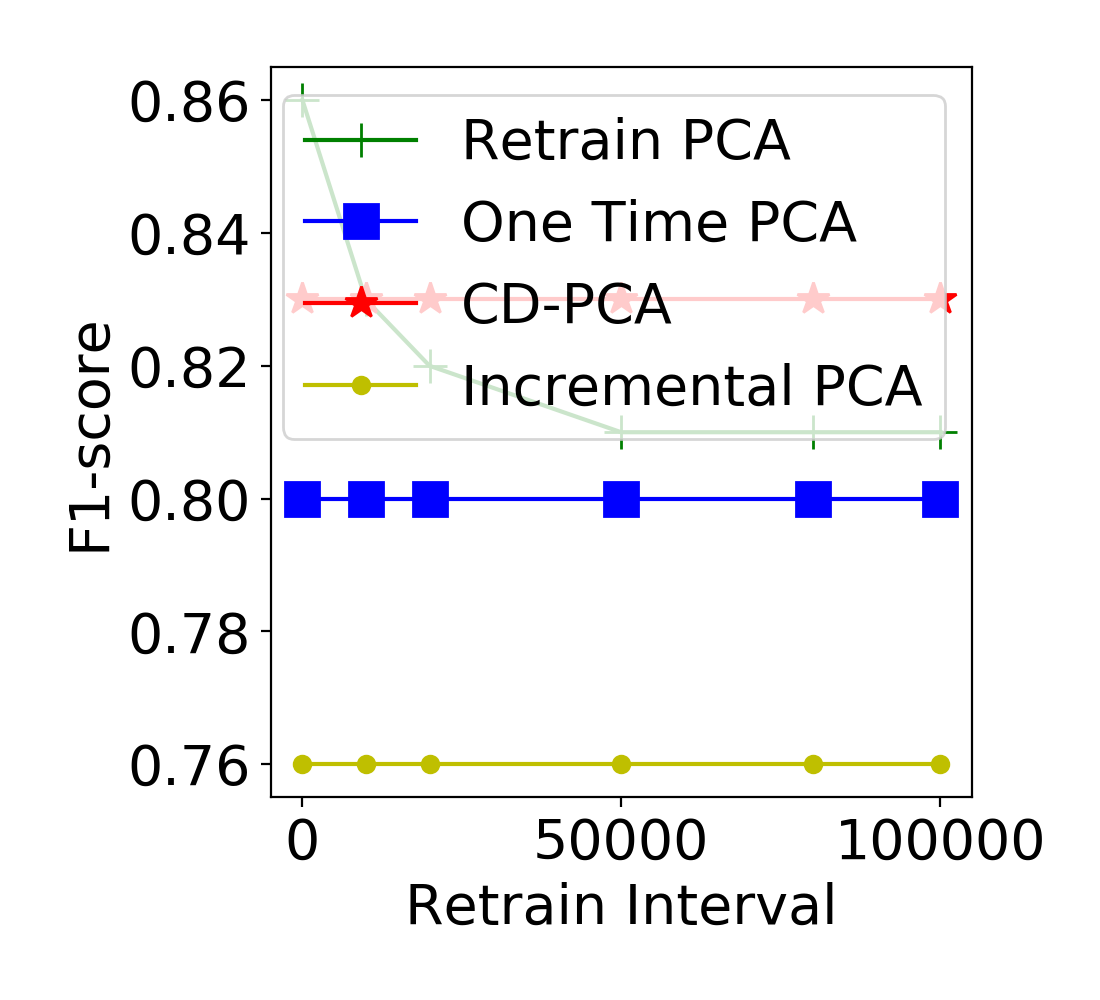

<IPython.core.display.Javascript object>


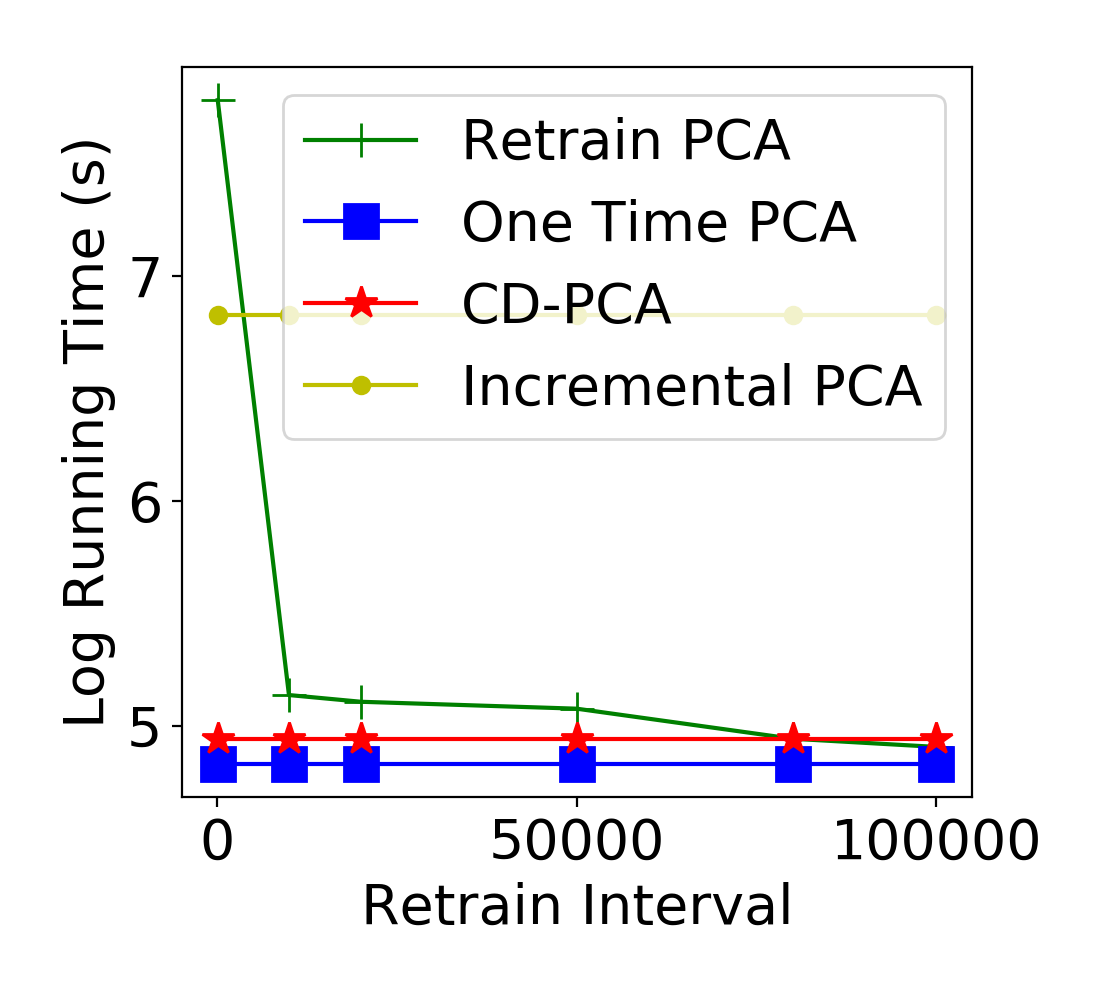

<IPython.core.display.Javascript object>


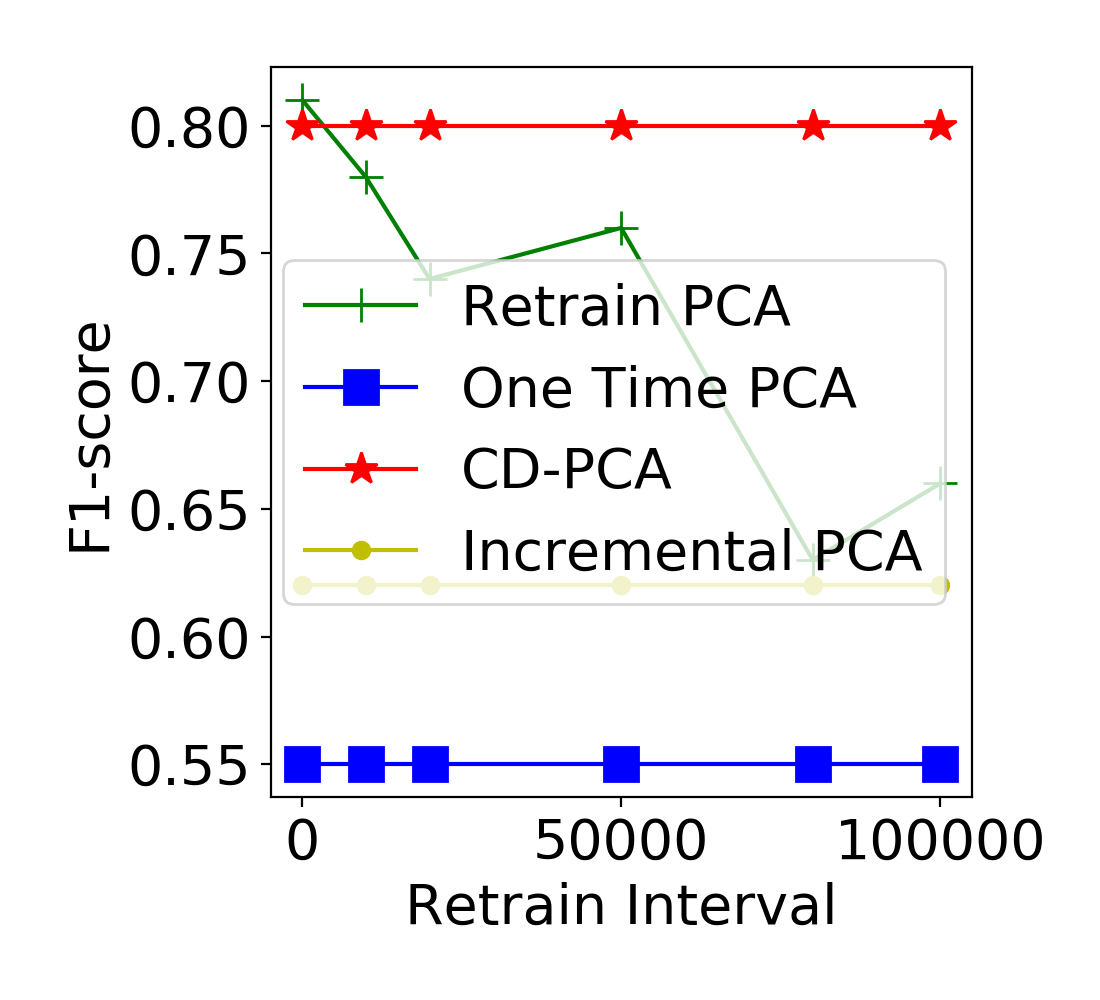

<IPython.core.display.Javascript object>


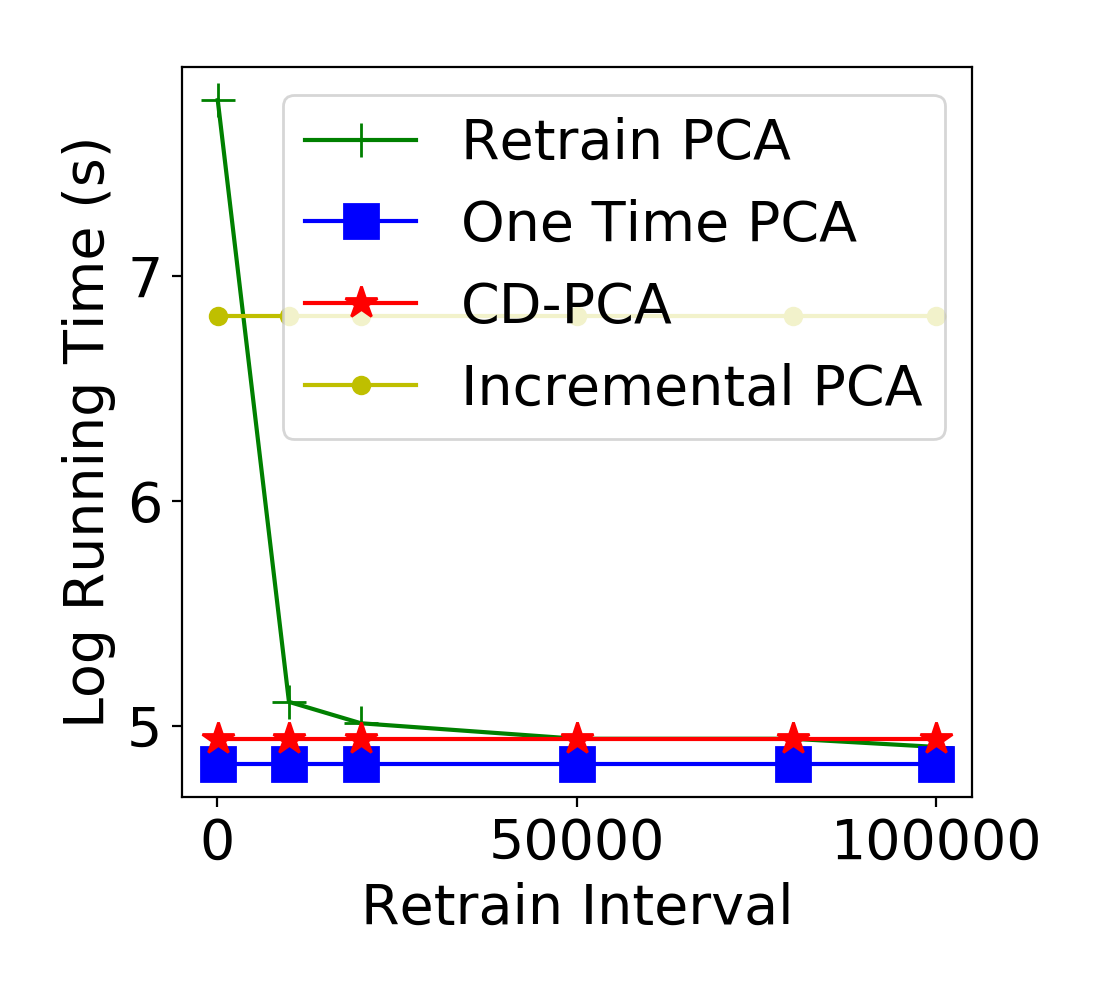

In [168]:
#Synthetic dataset
retrain_score_change_mean = [0.96, 0.93, 0.9, 0.9 , 0.89, 0.89]
one_time_change_mean = [0.87, 0.87, 0.87, 0.87, 0.87, 0.87]
cd_change_mean = [0.92, 0.92, 0.92, 0.92, 0.92, 0.92]
incremental_change_mean = [0.84, 0.84, 0.84, 0.84, 0.84, 0.84]
plt.figure(figsize=figure_size)
plt.plot(retrain_intervals, retrain_score_change_mean, color='g', marker='+',markersize=12, label="Retrain PCA")
plt.plot( retrain_intervals, one_time_change_mean, color='b', marker='s',markersize=12, label="One Time PCA")
plt.plot(retrain_intervals, cd_change_mean, color='r', marker='*',markersize=12, label="CD-PCA")
plt.plot(retrain_intervals, incremental_change_mean, color='y', marker='.',markersize=12, label="Incremental PCA")

plt.legend()
plt.xlabel("Retrain Interval")
plt.ylabel("F1-score")
#plt.title("F1-score - Change Mean")
plt.show()
plt.tight_layout()
plt.savefig("pca_f1_score_change_mean.pdf")
# Run time
retrain_score_runtime_change_mean = np.log([456*5, 32*5 ,31*5, 26*5, 26*5, 26*5])
one_time_change_mean_runtime = np.log([125, 125, 125, 125, 125, 125])
cd_change_mean_runtime = np.log([140, 140, 140, 140, 140, 140])
incremental_change_mean_runtime = np.log([900, 900, 900, 900, 900, 900])
plt.figure(figsize=figure_size)
plt.plot(retrain_intervals, retrain_score_runtime_change_mean, color='g', marker='+',markersize=12, label="Retrain PCA")
plt.plot( retrain_intervals, one_time_change_mean_runtime,color='b', marker='s',markersize=12, label="One Time PCA")
plt.plot(retrain_intervals, cd_change_mean_runtime, color='r', marker='*',markersize=12, label="CD-PCA")
plt.plot(retrain_intervals, incremental_change_mean_runtime, color='y', marker='.',markersize=12, label="Incremental PCA")


plt.legend()
plt.xlabel("Retrain Interval")
plt.ylabel("Log Running Time (s)")
#plt.title("Log Running Time - Change Mean")
plt.show()
plt.tight_layout()

plt.savefig("pca_runtime_change_mean.pdf")



#Synthetic dataset
retrain_score_change_std = [0.86, 0.83, 0.82, 0.81, 0.81, 0.81]
one_time_change_std = [0.8,0.8,0.8,0.8,0.8,0.8]
cd_change_std = [0.83, 0.83,0.83, 0.83,0.83, 0.83]
incremental_std = [0.76,0.76,0.76,0.76,0.76,0.76]
plt.figure(figsize=figure_size)
plt.plot(retrain_intervals, retrain_score_change_std, color='g', marker='+',markersize=12, label="Retrain PCA")
plt.plot( retrain_intervals, one_time_change_std, color='b', marker='s',markersize=12, label="One Time PCA")
plt.plot(retrain_intervals, cd_change_std, color='r', marker='*',markersize=12, label="CD-PCA")
plt.plot(retrain_intervals, incremental_std, color='y', marker='.',markersize=12, label="Incremental PCA")

plt.legend()
plt.xlabel("Retrain Interval")
plt.ylabel("F1-score")
#plt.title("F1-score - Change STD")
plt.show()
plt.tight_layout()
plt.savefig("pca_f1_score_change_std.pdf")
# Run time
retrain_score_runtime_change_std = np.log([478*5, 34*5, 33*5, 32*5, 28*5,27*5])
one_time_change_std_runtime = np.log([25*5,25*5,25*5,25*5,25*5,25*5])
cd_change_std_runtime = np.log([140, 140, 140, 140, 140, 140])
incremental_change_std_runtime = np.log([920, 920, 920, 920, 920, 920])
plt.figure(figsize=figure_size)
plt.plot(retrain_intervals, retrain_score_runtime_change_std, color='g', marker='+',markersize=12, label="Retrain PCA")
plt.plot( retrain_intervals, one_time_change_std_runtime,color='b', marker='s',markersize=12, label="One Time PCA")
plt.plot(retrain_intervals, cd_change_std_runtime, color='r', marker='*',markersize=12, label="CD-PCA")
plt.plot(retrain_intervals, incremental_change_std_runtime, color='y', marker='.',markersize=12, label="Incremental PCA")


plt.legend()
plt.xlabel("Retrain Interval")
plt.ylabel("Log Running Time (s)")
#plt.title("Log Running Time - Change STD")
plt.show()
plt.tight_layout()

plt.savefig("pca_runtime_change_std.pdf")


#Synthetic dataset
retrain_score_change_corr = [0.81, 0.78, 0.74, 0.76 , 0.63, 0.66]
one_time_change_corr = [0.55,0.55,0.55,0.55,0.55,0.55]
cd_change_corr = [0.8, 0.8,0.8, 0.8,0.8, 0.8]
incremental_corr = [0.62, 0.62,0.62,0.62,0.62,0.62]
plt.figure(figsize=figure_size)
plt.plot(retrain_intervals, retrain_score_change_corr, color='g', marker='+',markersize=12, label="Retrain PCA")
plt.plot( retrain_intervals, one_time_change_corr, color='b', marker='s',markersize=12, label="One Time PCA")
plt.plot(retrain_intervals, cd_change_corr, color='r', marker='*',markersize=12, label="CD-PCA")
plt.plot(retrain_intervals, incremental_corr, color='y', marker='.',markersize=12, label="Incremental PCA")

plt.legend()
plt.xlabel("Retrain Interval")
plt.ylabel("F1-score")
#plt.title("F1-score - Change Correlation")
plt.show()
plt.tight_layout()
plt.savefig("pca_f1_score_change_corr.pdf")
# Run time
retrain_score_runtime_change_corr = np.log([480*5, 33*5, 30*5, 28*5, 28*5, 27*5])
one_time_change_corr_runtime = np.log([25*5,25*5,25*5,25*5,25*5,25*5])
cd_change_corr_runtime = np.log([140, 140, 140, 140, 140, 140])
incremental_change_corr_runtime = np.log([920, 920, 920, 920, 920, 920])
plt.figure(figsize=figure_size)
plt.plot(retrain_intervals, retrain_score_runtime_change_corr, color='g', marker='+',markersize=12, label="Retrain PCA")
plt.plot( retrain_intervals, one_time_change_corr_runtime,color='b', marker='s',markersize=12, label="One Time PCA")
plt.plot(retrain_intervals, cd_change_corr_runtime, color='r', marker='*',markersize=12, label="CD-PCA")
plt.plot(retrain_intervals, incremental_change_corr_runtime, color='y', marker='.',markersize=12, label="Incremental PCA")


plt.legend()
plt.xlabel("Retrain Interval")
plt.ylabel("Log Running Time (s)")
#plt.title("Log Running Time - Change Correlation")
plt.show()
plt.tight_layout()

plt.savefig("pca_runtime_change_corr.pdf")


<IPython.core.display.Javascript object>


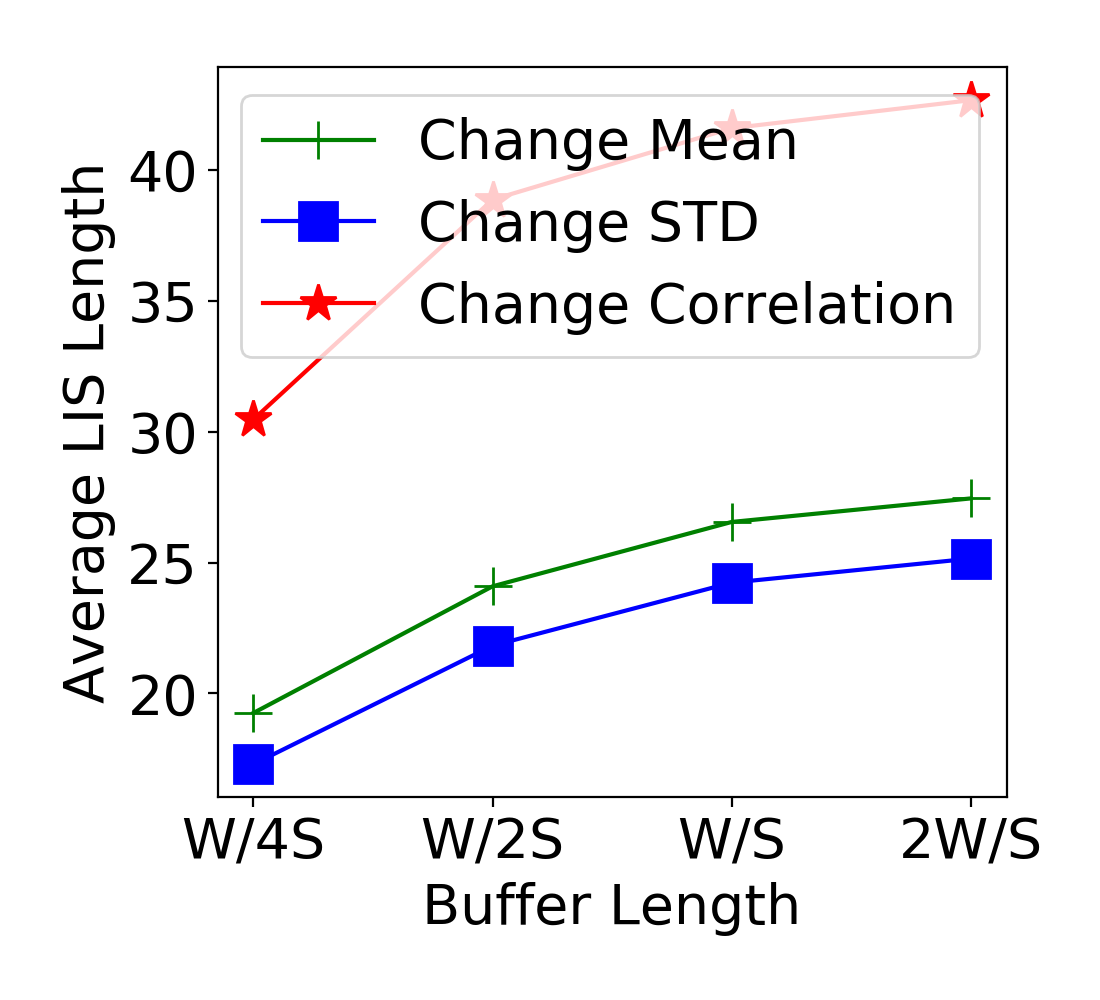

<IPython.core.display.Javascript object>


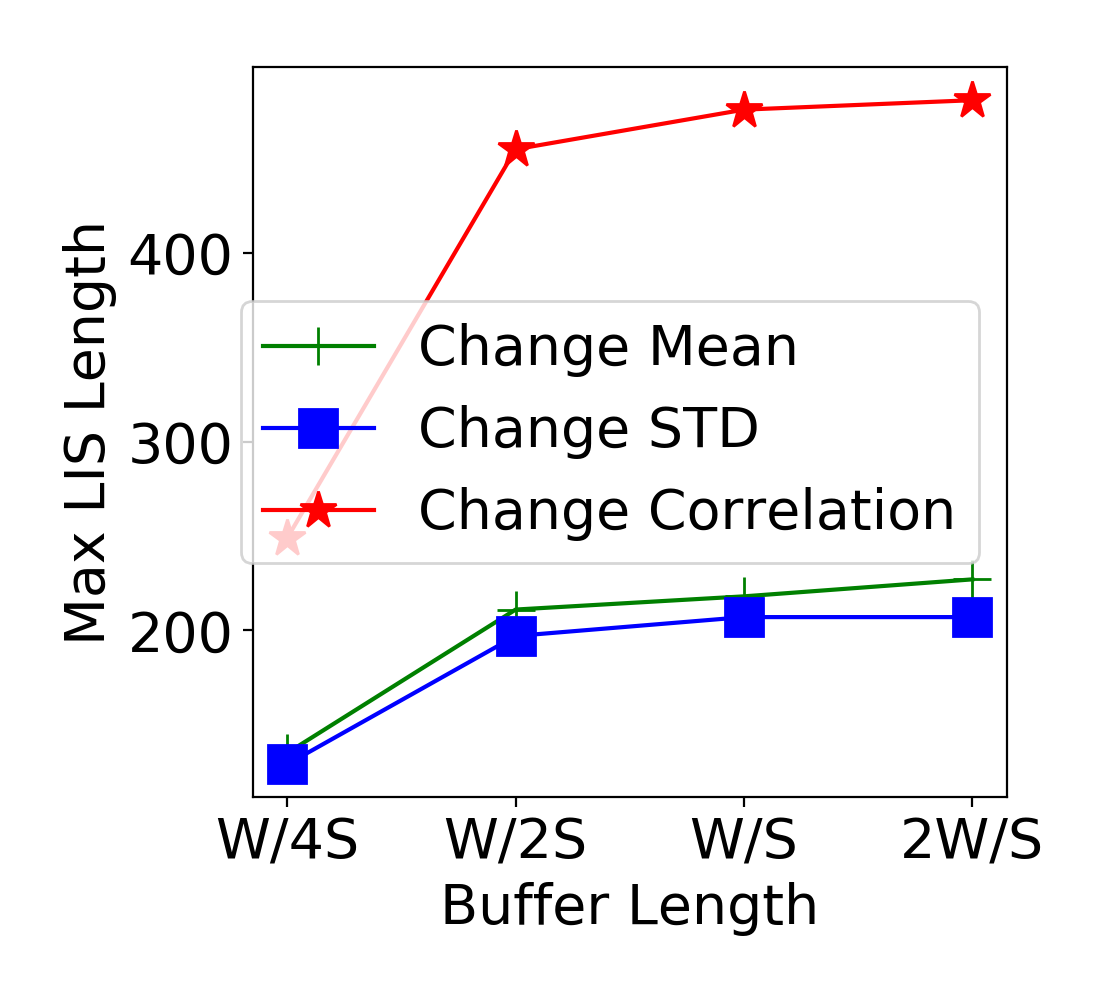

In [162]:


matplotlib.rcParams.update({'font.size': 20})

# plot Average LIS Length 
dummy_x_range = [1,2,3,4]
buffer_length = ["W/4S", "W/2S", "W/S", "2W/S"]
average_lis_change_mean = [19.25, 24.09, 26.55, 27.45]
average_lis_change_std = [17.29, 21.82, 24.23, 25.15]
average_lis_change_corr = [30.47, 38.87, 41.60, 42.67]
#plt.style.use('default')
plt.figure(figsize=figure_size,dpi=100)
#plt.tick_params(labelsize=20)
plt.plot(dummy_x_range, average_lis_change_mean, color='g', marker='+',markersize=14, label="Change Mean")
plt.plot(dummy_x_range, average_lis_change_std, color='b', marker='s',markersize=14, label="Change STD")
plt.plot(dummy_x_range, average_lis_change_corr, color='r', marker='*',markersize=14, label="Change Correlation")
plt.legend()
plt.xlabel("Buffer Length")
plt.ylabel("Average LIS Length")
#plt.title("Average LIS Length")
plt.xticks(dummy_x_range, buffer_length)

plt.show()
plt.tight_layout(rect=[0, 0, 1, 1])
plt.savefig("average_lis_vary_buffer.pdf")


max_lis_change_mean = [135, 211, 218, 227]
max_lis_change_std = [129, 197, 207, 207]
max_lis_change_corr = [249, 455, 476, 481]

plt.figure(figsize=figure_size)
plt.plot(dummy_x_range, max_lis_change_mean, color='g', marker='+',markersize=14, label="Change Mean")
plt.plot(dummy_x_range, max_lis_change_std, color='b', marker='s',markersize=14, label="Change STD")
plt.plot(dummy_x_range, max_lis_change_corr, color='r', marker='*',markersize=14, label="Change Correlation")
plt.legend()
plt.xlabel("Buffer Length")
plt.ylabel("Max LIS Length")
#plt.title("Max LIS Length - Varying Buffer Length")
plt.xticks(dummy_x_range, buffer_length)
plt.show()
plt.tight_layout()
plt.savefig("max_lis_vary_buffer.pdf")


In [132]:
plt.style.available

[u'seaborn-darkgrid',
 u'Solarize_Light2',
 u'seaborn-notebook',
 u'classic',
 u'seaborn-ticks',
 u'grayscale',
 u'bmh',
 u'seaborn-talk',
 u'dark_background',
 u'ggplot',
 u'fivethirtyeight',
 u'_classic_test',
 u'seaborn-colorblind',
 u'seaborn-deep',
 u'seaborn-whitegrid',
 u'seaborn-bright',
 u'seaborn-poster',
 u'seaborn-muted',
 u'seaborn-paper',
 u'seaborn-white',
 u'fast',
 u'seaborn-pastel',
 u'seaborn-dark',
 u'seaborn',
 u'seaborn-dark-palette']

In [35]:
step_from_beginning = 0
m_current = 0
M_current = 0
averaged_sc = 0
def change_PHDT(curScore, Sigma, delta):
    global step_from_beginning
    global m_current
    global M_current
    global averaged_sc
    averaged_sc = (averaged_sc * step_from_beginning + curScore)*1.0/(step_from_beginning+1)
    m_current = m_current + averaged_sc  - curScore + delta
    if abs(m_current) > M_current:
        M_current = abs(m_current)
    theta_t = Sigma * averaged_sc
    if (M_current - m_current) > theta_t:
        return True
    
    step_from_beginning += 1
    return False
Sigma = 500
delta = 0.0005

def change_detection_PHDT(data, window_size, slide_size):
    
    change_detection_time = 0
    global step_from_beginning
    global averaged_sc
    global m_current 
    global M_current
    
    
    changes = []
    global Sigma
    global delta
    dim = len(data[0,:])
    num_selected_components = 0
    #print("dim = "+ str(dim))
    start_idx = 0
    end_idx = window_size
    ref_end_idx = end_idx
    #get reference 
    reference_window = data[0:window_size,:]
    #print(reference_window[4999])
    
    step_from_beginning = 0
    averaged_sc = 0
    start_time = time.time()
    reference_window, bin_edges, dim, pca, ref_hists,num_selected_components = get_reference_window(reference_window, dim)
    change_detection_time += time.time() - start_time
    count_slide = 0
    start_idx += slide_size
    end_idx += slide_size
    distances = []
    
    
    while(end_idx < len(data)):
        count_slide +=1
        
        start_time = time.time()    
        current_window = data[start_idx: end_idx]
        current_window = pca.transform(current_window)
        #get current hist
        current_hists = get_hists(current_window,num_selected_components, bin_edges)
        distance = distance1(current_hists,ref_hists)
        distances.append(distance)
        
        if count_slide %50000 == 0:
            #print("Count slide = "+ str(count_slide))
            #print("averaged_sc = "+ str(averaged_sc))
            #print("Distance = " + str(distance))
            #print("M = "+str(M_current))
            #print("m = "+ str(m_current))
            pass
        if(start_idx > ref_end_idx and  change_PHDT(distance, Sigma, delta)):
            print("Change at : "+ str(end_idx))
            
            averaged_sc = 0
            M_current = 0
            m_current = 0
            step_from_beginning = 0
            changes.append(end_idx)
            start_idx = end_idx
            end_idx = start_idx + window_size
            #update reference
            reference_window, bin_edges, dim, pca , ref_hists, num_selected_components= get_reference_window(data[start_idx: end_idx], dim)
            ref_end_idx = end_idx
        change_detection_time += time.time() - start_time
        end_idx += slide_size
        start_idx += slide_size
    return changes, change_detection_time
truncating_number = 3
threshold_avg = 1.5
def change_detection_AVG(data, window_size, slide_size):
    
    change_detection_time= 0 
    global threshold_avg
    threshold = threshold_avg
    
    global alpha
    
    dim = len(data[0,:])
    #print("dim = "+ str(dim))
    start_idx = 0
    end_idx = window_size
    #get reference 
    reference_window = data[0:window_size,:]
    #print(reference_window[4999])
    ref_hists = []
    bin_edges = []
    num_selected_components = 0
    
    start_time = time.time()
    reference_window, bin_edges, dim, pca, ref_hists,num_selected_components = get_reference_window(reference_window, dim)
    change_detection_time += time.time() - start_time
    #time_for_getting_ref += time.time() - start_time
    #alpha = x1/(len(bin_edges)-1)
    #print("Num bin = " + str(len(bin_edges[0])))
    
    count_slide = 0
    start_idx += slide_size
    end_idx += slide_size
    ref_end_idx = end_idx
    distances = []
    lis_sequence = []
    changes = []
    
    possible_lis = 0
    
    
    
    current_hists = ref_hists[:]


    
    current_avg = 0
    count_avg =0
    avg_Sc = 0
    
    current_hists = ref_hists[:]
    while(end_idx < len(data)):
        count_slide +=1
        #current_window = pca.transform(data[start_idx: end_idx])
        start_time = time.time()
        expired_slide = pca.transform(data[(start_idx-slide_size): start_idx])
        
        new_slide = pca.transform(data[(end_idx - slide_size): end_idx])
        #current_window = pca.transform(preprocessing.normalize(current_window, norm='l2'))
        #current_window = pca.transform(current_window)
        #get current hist
        expired_hists = get_hists(expired_slide,num_selected_components, bin_edges)
        
        #current_hists2 = get_hists(current_window,num_selected_components, bin_edges)
        new_hists = get_hists(new_slide,num_selected_components, bin_edges)

        current_hists = np.subtract(current_hists, expired_hists)
        current_hists = np.add(current_hists, new_hists)
        #distance = distance2(current_hists,ref_hists, pca)
        distance = distance_max2(ref_hists,current_hists, pca)
        #distance = distance_min(current_hists,ref_hists, pca)
        #distance = distance_sum(current_hists,ref_hists, pca)
        #distance = distance_sum_square(current_hists,ref_hists, pca)
        if count_slide %50000 == 0:
            #print("Count slide = "+ str(count_slide))
            #print("distance = "+ str(distance))
            pass
        if start_idx > ref_end_idx:
            distances.append(distance)
        
        
        
        
        if len(distances) > window_size/slide_size:
            del distances[0]
            current_avg = np.sum(distances)/len(distances)
            avg_Sc = (avg_Sc * count_avg + current_avg) /(count_avg +1)
            count_avg +=1
        #print(distance)
        if start_idx > ref_end_idx:
            if start_idx > ref_end_idx and avg_Sc > 0 and current_avg/avg_Sc > threshold:
                print("Change at "+ str(end_idx))
                changes.append(end_idx)
                #update reference
                start_idx = end_idx
                end_idx = start_idx + window_size
                reference_window, bin_edges, dim, pca , ref_hists, num_selected_components= get_reference_window(data[start_idx: end_idx], dim)
                ref_end_idx = end_idx
                current_avg = 0
                distances = []
        change_detection_time += time.time() - start_time
        start_idx += slide_size
        end_idx += slide_size
        #lis_sequence.append(lis)
        
        
        
        
    #fig = plt.figure()
    #plt.plot(lis_sequence)
    #fig.show()
    
    return changes, change_detection_time

truncating_number = 4
def change_detection_truncate(data, window_size, slide_size):
    change_detection_time = 0
    threshold = 2*math.sqrt(window_size/slide_size)
    
    #time_for_getting_ref = 0
    
    #threshold = window_size/slide_size*0.5
    global truncating_number
    global alpha
    
    dim = len(data[0,:])
    #print("dim = "+ str(dim))
    start_idx = 0
    end_idx = window_size
    #get reference 
    reference_window = data[0:window_size,:]
    #print(reference_window[4999])
    ref_hists = []
    bin_edges = []
    num_selected_components = 0
    
    start_time = time.time()
    reference_window, bin_edges, dim, pca, ref_hists,num_selected_components = get_reference_window(reference_window, dim)
    change_detection_time += time.time() - start_time
    #time_for_getting_ref += time.time() - start_time
    #alpha = x1/(len(bin_edges)-1)
    #print("Num bin = " + str(len(bin_edges[0])))
    
    count_slide = 0
    start_idx += slide_size
    end_idx += slide_size
    ref_end_idx = end_idx
    distances = []
    lis_sequence = []
    changes = []
    
    possible_lis = 0
    
    
    
    current_hists = ref_hists[:]
    
    while(end_idx < len(data)):
        count_slide +=1
        
        #current_window = pca.transform(data[start_idx: end_idx])
        start_time = time.time()
        expired_slide = pca.transform(data[(start_idx-slide_size): start_idx])
        
        new_slide = pca.transform(data[(end_idx - slide_size): end_idx])
        #get current hist
        expired_hists = get_hists(expired_slide,num_selected_components, bin_edges)
        
        #current_hists2 = get_hists(current_window,num_selected_components, bin_edges)
        new_hists = get_hists(new_slide,num_selected_components, bin_edges)
        current_hists = np.subtract(current_hists, expired_hists)
        current_hists = np.add(current_hists, new_hists)
        #current_hists = np.array(current_hists) - np.array(expired_hists) + np.array(new_hists)
        change_detection_time += time.time() - start_time    
        #distance = distance2(current_hists,ref_hists, pca)
        distance = distance_max2(current_hists,ref_hists,pca)
        #distance = distance_min2(current_hists,ref_hists,pca)
        distance = round (Decimal(distance),truncating_number)
        if start_idx > ref_end_idx:
            distances.append(distance)
        
        
        
        
        if len(distances) > window_size/slide_size:
            del distances[0]
        #print(distance)
        if start_idx > ref_end_idx:
            possible_lis +=1 
        
        if possible_lis > threshold:
            lis = len(subsequence(distances))
            possible_lis = lis
            if start_idx > ref_end_idx and lis > threshold:
                #print("Change at "+ str(end_idx))
                changes.append(end_idx)
                #update reference
                #start_idx = end_idx
                #end_idx = start_idx + window_size
                start_time = time.time()
                reference_window, bin_edges, dim, pca , ref_hists, num_selected_components= get_reference_window(data[start_idx: end_idx], dim)
                change_detection_time += time.time() - start_time
                current_hists = ref_hists[:]
                #expired_slide = reference_window[0:slide_size]
                ref_end_idx = end_idx
                possible_lis = 0
                distances = []
        
        start_idx += slide_size
        end_idx += slide_size
    
    return changes, change_detection_time
 

    
    

def change_detection_AVG_new(data, window_size, slide_size):
    global threshold_avg
    threshold = threshold_avg
    current_avg = 0
    count_avg =0
    avg_Sc = 0
    
    
    change_detection_time = 0
    threshold = 2*math.sqrt(window_size/slide_size)

    #time_for_getting_ref = 0

    #threshold = window_size/slide_size*0.5
    global truncating_number
    global alpha

    dim = len(data[0,:])
    #print("dim = "+ str(dim))
    start_idx = 0
    end_idx = window_size
    #get reference 
    reference_window = data[0:window_size,:]
    #print(reference_window[4999])
    ref_hists = []
    bin_edges = []
    num_selected_components = 0

    start_time = time.time()
    reference_window, bin_edges, dim, pca, ref_hists,num_selected_components = get_reference_window(reference_window, dim)
    change_detection_time += time.time() - start_time
    #time_for_getting_ref += time.time() - start_time
    #alpha = x1/(len(bin_edges)-1)
    #print("Num bin = " + str(len(bin_edges[0])))

    count_slide = 0
    start_idx += slide_size
    end_idx += slide_size
    ref_end_idx = end_idx
    distances = []
    lis_sequence = []
    changes = []

    possible_lis = 0



    current_hists = ref_hists[:]

    while(end_idx < len(data)):
        count_slide +=1

        #current_window = pca.transform(data[start_idx: end_idx])
        start_time = time.time()
        expired_slide = pca.transform(data[(start_idx-slide_size): start_idx])

        new_slide = pca.transform(data[(end_idx - slide_size): end_idx])
        #get current hist
        expired_hists = get_hists(expired_slide,num_selected_components, bin_edges)

        #current_hists2 = get_hists(current_window,num_selected_components, bin_edges)
        new_hists = get_hists(new_slide,num_selected_components, bin_edges)
        current_hists = np.subtract(current_hists, expired_hists)
        current_hists = np.add(current_hists, new_hists)
        #current_hists = np.array(current_hists) - np.array(expired_hists) + np.array(new_hists)
        change_detection_time += time.time() - start_time    
        #distance = distance2(current_hists,ref_hists, pca)
        distance = distance_max2(current_hists,ref_hists,pca)
        #distance = distance_min2(current_hists,ref_hists,pca)
        distance = round (Decimal(distance),truncating_number)
        if start_idx > ref_end_idx:
            distances.append(distance)




        
        if len(distances) > window_size/slide_size:
            del distances[0]
            current_avg = np.sum(distances)/len(distances)
            avg_Sc = (avg_Sc * count_avg + current_avg) /(count_avg +1)
            count_avg +=1
        #print(distance)
        if start_idx > ref_end_idx:
            if start_idx > ref_end_idx and avg_Sc > 0 and current_avg/avg_Sc > threshold:
                print("Change at "+ str(end_idx))
                changes.append(end_idx)
                #update reference
                start_idx = end_idx
                end_idx = start_idx + window_size
                reference_window, bin_edges, dim, pca , ref_hists, num_selected_components= get_reference_window(data[start_idx: end_idx], dim)
                ref_end_idx = end_idx
                current_avg = 0
                distances = []

        start_idx += slide_size
        end_idx += slide_size

    return changes, change_detection_time

def change_detection_PHDT_New(data, window_size, slide_size):
    global step_from_beginning
    global averaged_sc
    global m_current 
    global M_current
    
    
    changes = []
    global Sigma
    global delta
    global threshold_avg
    threshold = threshold_avg
    current_avg = 0
    count_avg =0
    avg_Sc = 0
    averaged_sc = 0
    
    change_detection_time = 0
    threshold = 2*math.sqrt(window_size/slide_size)

    #time_for_getting_ref = 0

    #threshold = window_size/slide_size*0.5
    global truncating_number
    global alpha

    dim = len(data[0,:])
    #print("dim = "+ str(dim))
    start_idx = 0
    end_idx = window_size
    #get reference 
    reference_window = data[0:window_size,:]
    #print(reference_window[4999])
    ref_hists = []
    bin_edges = []
    num_selected_components = 0

    start_time = time.time()
    reference_window, bin_edges, dim, pca, ref_hists,num_selected_components = get_reference_window(reference_window, dim)
    change_detection_time += time.time() - start_time
    #time_for_getting_ref += time.time() - start_time
    #alpha = x1/(len(bin_edges)-1)
    #print("Num bin = " + str(len(bin_edges[0])))

    count_slide = 0
    start_idx += slide_size
    end_idx += slide_size
    ref_end_idx = end_idx
    distances = []
    lis_sequence = []
    changes = []

    possible_lis = 0



    current_hists = ref_hists[:]

    while(end_idx < len(data)):
        count_slide +=1

        #current_window = pca.transform(data[start_idx: end_idx])
        start_time = time.time()
        expired_slide = pca.transform(data[(start_idx-slide_size): start_idx])

        new_slide = pca.transform(data[(end_idx - slide_size): end_idx])
        #get current hist
        expired_hists = get_hists(expired_slide,num_selected_components, bin_edges)

        #current_hists2 = get_hists(current_window,num_selected_components, bin_edges)
        new_hists = get_hists(new_slide,num_selected_components, bin_edges)
        current_hists = np.subtract(current_hists, expired_hists)
        current_hists = np.add(current_hists, new_hists)
        #current_hists = np.array(current_hists) - np.array(expired_hists) + np.array(new_hists)
        change_detection_time += time.time() - start_time    
        #distance = distance2(current_hists,ref_hists, pca)
        distance = distance_max2(current_hists,ref_hists,pca)
        #distance = distance_min2(current_hists,ref_hists,pca)
        distance = round (Decimal(distance),truncating_number)


        #print(distance)
        if(start_idx > ref_end_idx and  change_PHDT(distance, Sigma, delta)):
            #print("Change at : "+ str(end_idx))
            
            averaged_sc = 0
            M_current = 0
            m_current = 0
            step_from_beginning = 0
            changes.append(end_idx)
            start_idx = end_idx
            end_idx = start_idx + window_size
            #update reference
            reference_window, bin_edges, dim, pca , ref_hists, num_selected_components= get_reference_window(data[start_idx: end_idx], dim)
            ref_end_idx = end_idx

        start_idx += slide_size
        end_idx += slide_size

    return changes, change_detection_time






In [41]:
import time

all_result = {}


outlier_rate = 0.05
slide = 100


mean = [0.01, 0.01, 0.01, 0.01, 0.01]
cov = [[0.04, 0.02, 0.02, 0.02, 0.02],[0.02, 0.04, 0.02, 0.02, 0.02],[0.02, 0.02, 0.04, 0.02, 0.02],[0.02, 0.02, 0.02, 0.04, 0.02],[0.02, 0.02, 0.02, 0.02, 0.04]]
groud_truth = [] 
change_value = 0.2
change_type = "sudden"
change_param = "correlation"
#d = generate_dataset("gauss",5, 50000,mean, cov, change_value, change_type, change_param, 10)
no_change,groud_truth = sample_dataset_no_change("VLDB/household.txt", "double", 50000, 10)
#only for fc
#no_change = no_change[:,0:10]
#print(groud_truth)
d = add_change_to_data(no_change, groud_truth, "double")

#print(groud_truth)
#print(len(d[0]))



truncating_number = 3

for t in range(2):
    for window in [10000, 20000, 30000, 40000, 50000]:
        print("Window size "+ str(window))
        start_time = time.time()
        changes, running_time = change_detection_truncate(d, window, slide)
        print("Change detection time DLIS = "+ str(running_time))

        start_time = time.time()
        changes, running_time = change_detection_AVG_new(d, window, slide)
        print("Change detection time AVG = "+ str(running_time))

        #start_time = time.time()
        #changes, running_time = change_detection_PHDT_New(d, window, slide)
        #print("Change detection time PHDT = "+ str(running_time))




Window size 10000
Change detection time DLIS = 4.88677048683
Change detection time AVG = 3.85685110092
Window size 20000
Change detection time DLIS = 3.99792766571
Change detection time AVG = 4.42632460594
Window size 30000
Change detection time DLIS = 4.64699172974
Change detection time AVG = 3.9439022541
Window size 40000
Change detection time DLIS = 3.61800432205
Change detection time AVG = 3.85929346085
Window size 50000
Change detection time DLIS = 4.18531155586
Change detection time AVG = 3.76284360886
Window size 10000
Change detection time DLIS = 3.96056413651
Change detection time AVG = 3.70066976547
Window size 20000
Change detection time DLIS = 4.08677458763
Change detection time AVG = 3.73025560379
Window size 30000
Change detection time DLIS = 3.7831223011
Change detection time AVG = 3.93755745888
Window size 40000
Change detection time DLIS = 3.52539849281
Change detection time AVG = 3.8425757885
Window size 50000
Change detection time DLIS = 4.19040298462
Change detectio